# ML model in pytorch:

## Setting up:
### Additional installations

In [2]:
! pip install cartopy
! pip install pyproj
! pip install wandb
! pip install -U -q PyDrive
! pip uninstall shapely
! pip install shapely --no-binary shapely

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 10.8 MB 6.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 25.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 34.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 12.1 MB 23.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 46 kB 4.1 MB/s 
  Created wheel for cartopy: filename=Cartopy-0.19.0.post1-cp37-cp37m-linux_x86_64.whl size=12516280 sha256=96b6a7c1a53607bf40dd1b1c25c30c19a54f007c55e6d3252e913be57da19200
  Stored in directory: /root/.cache/pip/whee

### Imports:

In [3]:
# Basics
from matplotlib import pyplot as plt
import matplotlib.path as mpath
import os
import sys
from pathlib import Path
from os import listdir
from os.path import isfile, join
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
from re import search
from math import cos,sin,pi
import random as rn
from google.colab import auth
from google.colab import files

# xarray and cartopy plots
import xarray as xr

import cartopy
import cartopy.crs as ccrs
import pyproj
from pyproj import Transformer

# ML
from scipy import ndimage
import torch
import tensorflow as tf 
import torch.nn as nn
import torch.nn.functional as F
import argparse
import logging
import wandb
from torch import optim
from torch.utils.data import DataLoader, random_split
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset
from torchvision import datasets
from torchvision.transforms import ToTensor

from sklearn.model_selection import train_test_split
#import setGPU

%matplotlib inline
%load_ext autoreload
%autoreload 2

### Set up CUDA:

In [4]:
print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
  
# Storing ID of current CUDA device
if torch.cuda.is_available():
  cuda_id = torch.cuda.current_device()
  print(f"ID of current CUDA device:{torch.cuda.current_device()}")
          
  print(f"Name of current CUDA device:{torch.cuda.get_device_name(cuda_id)}")

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Is CUDA supported by this system? True
CUDA version: 11.3
ID of current CUDA device:0
Name of current CUDA device:Tesla P100-PCIE-16GB


### Helper scripts:

In [5]:
# Load configuration file:
from config import *
from dataFunctions import *
from makeInputs import *

# Import custom scripts
#sys.path.append('../')
#from GC_scripts import * # Google cloud scripts

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Set up Google Cloud:

In [6]:
"""
auth.authenticate_user()
# Give our project ID
project_id = 'ee-iceshelf-gee4geo'
!gcloud config set project {project_id}
# Download the file from a given Google Cloud Storage bucket.
!gsutil cp gs://ee-downscalingclimatemodels/test.txt /tmp/gsutil_download.txt
# Print the result to make sure the transfer worked.
!cat /tmp/gsutil_download.txt"""

"\nauth.authenticate_user()\n# Give our project ID\nproject_id = 'ee-iceshelf-gee4geo'\n!gcloud config set project {project_id}\n# Download the file from a given Google Cloud Storage bucket.\n!gsutil cp gs://ee-downscalingclimatemodels/test.txt /tmp/gsutil_download.txt\n# Print the result to make sure the transfer worked.\n!cat /tmp/gsutil_download.txt"

### Set up Google Drive:

In [7]:
# Code to read csv file into Colaboratory:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
Googledrive = GoogleDrive(gauth)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
!ls /content/gdrive/My\ Drive/Master-thesis/saved_models/

## Load data:

### (Input) Global climate model:

In [ ]:
if DOWNLOAD_FROM_GC:
    downloadFileFromGC(pathGC, "", fileGCMLike)
    GCMLike = xr.open_dataset(fileGCMLike)
    os.remove(fileGCMLike)
else:
    idGCMLike = '1AVOnOqvV9YPiJTPoPWHWu3uk7293dqAo'
    downloaded = Googledrive.CreateFile({'id':idGCMLike}) 
    downloaded.GetContentFile(fileGCMLike)  
    GCMLike = xr.open_dataset(fileGCMLike)
    os.remove(fileGCMLike)
print(GCMLike.dims)
GCMLike

In [ ]:
fig = plt.figure(figsize=(20, 10))
ax = plt.subplot(2, 1, 1, projection=ccrs.SouthPolarStereo())
GCMLike.SMB.isel(time=0).plot(
    x="x", ax=ax, transform=ccrs.SouthPolarStereo(), add_colorbar=False
)
ax.coastlines("10m", color="black")
ax.gridlines(draw_labels=True)

ax = plt.subplot(2, 1, 2, projection=ccrs.PlateCarree())
GCMLike.SMB.isel(time=0).plot(
    x="x", ax=ax, transform=ccrs.SouthPolarStereo(), add_colorbar=False
)
ax.coastlines("10m", color="black")
ax.gridlines(draw_labels=True)

### (Target) Regional climate model:

In [ ]:
%%time
if DOWNLOAD_FROM_GC:
    downloadFileFromGC(pathGC, "", fileTarget)
    target_dataset = xr.open_dataset(fileTarget)
    os.remove(fileTarget)
else:
    idTarget = '15Kd81r9k6SA-1gTnpNZqBf4snl1UksbI'
    downloaded = Googledrive.CreateFile({'id':idTarget}) 
    downloaded.GetContentFile(fileTarget) 
    target_dataset = xr.open_dataset(fileTarget)
    os.remove(fileTarget)
print(target_dataset.dims)

# Cut a small part of on the right that is not too important
N = 160
max_x = (N / 2) * 35 * 1000
max_y = (N / 2) * 35 * 1000

target_dataset = cutBoundaries(target_dataset, max_x, max_y)
print("New target dimensions:", target_dataset.dims)

### Real GCM:

In [ ]:
%%time
if DOWNLOAD_FROM_GC:
    downloadFileFromGC(pathGC, "", fileGCM)
    GCMLike = xr.open_dataset(fileGCM)
    os.remove(fileGCM)
else:
    idGCM = '1kAJPKhgQ3pMAgeOaQ5nzllCO-rF9kXIO'
    downloaded = Googledrive.CreateFile({'id':idGCM}) 
    downloaded.GetContentFile(fileGCM)  
    GCM = xr.open_dataset(fileGCM)
    os.remove(fileGCM)
GCM = GCM.rename_vars({'psl':'SP', 'uas':'VVP', 'vas':'UUP', 'pr':'RF', 'rlut': 'LWD', 'tas': 'TT', 'rsut':'SWD'})

In [ ]:
GCM

In [ ]:
ds = createLowerInput(GCM, region='Larsen', Nx=35, Ny=25, print_=False)
ds = ds.where(ds.y > 0, drop=True)
ax = plt.subplot(1,1,1, projection=ccrs.SouthPolarStereo() )
ds.TT.isel(time = 1).plot(x='x', ax = ax, transform=ccrs.SouthPolarStereo())
ax.coastlines("10m", color="black")
ax.gridlines()

In [ ]:
plotAllVar2Xr(
    GCMLike.drop(['SMB']),  # xr.Dataset
    GCM
)

## Input and target for model:

**Z**:
- (ignore for now) External forcing also given to RCM → total concentration of greenhouse gases and solar and ozone forcings
- Cosinus, sinus vector to encode information about day of year
- Daily spatial means and standard deviations time series for each $X_{i,j,m}$ (because normalising 2D variables removes temporal information)

**X**: 
SHAPE `[nbmonths, x, y, nb_vars]`

For pytorch need to put into `[nbmonths, nb_vars, x, y]`

### Input:

In [ ]:
if REGION == "Combined":
    inputs_2D = []
    inputs_1D = []
    inputs_2D_ns = []
    inputs_1D_ns = []
    i = 0
    for r in REGIONS:
        i1D, i2D, i1D_ns, i2D_ns, VAR_LIST = make_inputs(
            GCMLike, SIZE_INPUT_DOMAIN, Region=r, regionNbr=i
        )
        inputs_1D.append(i1D)
        inputs_2D.append(i2D)
        inputs_1D_ns.append(i1D_ns)
        inputs_2D_ns.append(i2D_ns)
        i+=1
else:
    i1D, i2D, i1D_ns, i2D_ns, VAR_LIST = make_inputs(
        GCMLike = GCMLike, GCM = None, size_input_domain = SIZE_INPUT_DOMAIN, Region=REGION, dropvar = None
    )
    inputs_2D_ns = [i2D_ns]
    inputs_1D_ns = [i1D_ns]
    inputs_2D = [i2D]
    inputs_1D = [i1D]
    REGIONS = [REGION]

# Full input to model
full_input = [np.concatenate(inputs_2D, axis=0), np.concatenate(inputs_1D, axis=0)]
full_input_ns = [
    np.concatenate(inputs_2D_ns, axis=0),
    np.concatenate(inputs_1D_ns, axis=0),
]

### Target:

In [ ]:
if REGION == "Combined":
    targets, target_times = [], []
    for r in REGIONS:
        t, t_times = target_maker(target_dataset, region=r, resize=False)
        targets.append(t[0])
        target_times.append(t_times[0])
else:
    targets, target_times = target_maker(target_dataset, region=REGION, resize=False)
# Full target to model
full_target = np.concatenate(targets, axis=0)
target_time = np.concatenate(target_times, axis=0)
target_lon = target_dataset["x"]
target_lat = target_dataset["y"]

print("Shapes of targets and inputs:\n---------------------------")
print("Target:", full_target.shape)
print("Input 2D:", full_input[0].shape)
print("Input 1D:", full_input[1].shape)

### Example of each region of Antarctica:
Plot an example of each region that is used.

In [ ]:
f = plt.figure(figsize=(20, 5))
i = 1
for r in REGIONS:
    targets, target_times = target_maker(target_dataset, region=r, resize=False)
    full_target_test = np.concatenate(targets, axis=0)[0, :, :, :]
    ax = plt.subplot(1, 4, i, projection=ccrs.SouthPolarStereo())
    vmin = np.min(full_target_test)
    vmax = np.max(full_target_test)
    plotTarget(target_dataset, full_target_test, ax, vmin, vmax, region=r)
    ax.set_title(r)
    i += 1

### Examples of input to model:
Show an example of process of how dataset is

In [ ]:
#  Create pytorch tensors:
X = torch.tensor(full_input[0].transpose(0, 3, 1, 2))
Z = torch.tensor(full_input[1].transpose(0, 3, 1, 2))
Y = torch.tensor(full_target.transpose(0, 3, 1, 2))
R = regionEncoder(X, REGION) # region encoder
X.shape, Z.shape, Y.shape, len(R)

# 1. Create dataset
dataset = TensorDataset(X, Z, Y, R)
loader = DataLoader(dataset, batch_size=BATCH_SIZE)

# Example:
(x, z, y, r) = next(iter(loader))
print(f"2D Feature batch shape: {x.size()}")
print(f"1D Feature batch shape: {z.size()}")
print(f"Labels batch shape: {y.size()}")

# 2. Split into train / validation partitions
n_val = int(len(dataset) * VAL_PERCENT)
n_train = len(dataset) - n_val
train_set, val_set = random_split(
    dataset, [n_train, n_val], generator=torch.Generator().manual_seed(SEED)
)

# 3. Create data loaders
loader_args = dict(batch_size=BATCH_SIZE)
train_loader = DataLoader(train_set, shuffle=False, batch_size=BATCH_SIZE)
val_loader = DataLoader(val_set, shuffle=False, batch_size=BATCH_SIZE)

# 4. Display input and targets.
N = 5 
f = plt.figure(figsize=(20, 30))

for i in range(N):
  train_X, train_Z, train_Y, train_R = next(iter(loader))
  randTime = rn.randint(0, len(train_X)-1)
  sample2dtrain_ = train_X.numpy().transpose(0, 2, 3, 1)[randTime]
  sampletarget_ = train_Y.numpy().transpose(0, 2, 3, 1)[randTime]
  sampleregion = train_R[randTime]
  dt = pd.to_datetime([GCMLike.time.isel(time=randTime).values])
  time = str(dt.date[0])

  if REGION != "Whole Antarctica":
      sample2dtrain_ = resize(sample2dtrain_, 25, 48, print_=False)
  else:
      sample2dtrain_ = resize(sample2dtrain_, 25, 90, print_=False)
  vmin = np.min(sampletarget_)
  vmax = np.max(sampletarget_)

  M = 2
  for m in range(M):
    if m == 0:
      ax = plt.subplot(N, 2, (i * M) + m + 1, projection=ccrs.SouthPolarStereo())
      plotTrain(GCMLike, sample2dtrain_, 4, ax, time, VAR_LIST, region=REGIONS[sampleregion])
    if m == 1:
      ax = plt.subplot(N, 2, (i * M) + m + 1, projection=ccrs.SouthPolarStereo())
      plotTarget(target_dataset, sampletarget_, ax, vmin, vmax, region=REGIONS[sampleregion])

## U-Net:

In [ ]:
from unet import *
from SmaAt_UNet import *

In [ ]:
from dataFunctions import *
from makeInputs import *
from config import *

In [ ]:
from training import *
from prediction import *
from metrics import *

In [ ]:
SEED

## Training

## Larsen, Baseline - MSE:

In [ ]:
from dataFunctions import *
from makeInputs import *
from config import *
from training import *
from metrics import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Variables: ['LWD', 'RF', 'SP', 'SWD', 'TT', 'UUP', 'VVP']
Return input of GCMLike
Variables: ['LWD', 'RF', 'SP', 'SWD', 'TT', 'UUP', 'VVP']
Return input of GCMLike


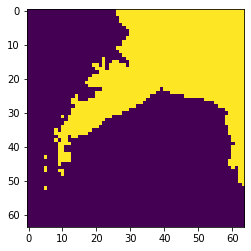

In [ ]:
REGION = "Larsen"
# Make target
targets, target_times = target_maker(target_dataset, region=REGION, resize=False)
# Full target to model
full_target = np.concatenate(targets, axis=0)
target_time = np.concatenate(target_times, axis=0)
target_lon = target_dataset["x"]
target_lat = target_dataset["y"]

# Make input
i1D, i2D, i1D_ns, i2D_ns, VAR_LIST = make_inputs(
    GCMLike, 
    GCM = None,
    size_input_domain=SIZE_INPUT_DOMAIN, 
    Region=REGION, 
    dropvar = None
)
full_input = [np.concatenate([i2D], axis=0), np.concatenate([i1D], axis=0)]
full_input_ns = [
    np.concatenate([i2D_ns], axis=0),
    np.concatenate([i1D_ns], axis=0),
]

REGIONS = [REGION]

mask = createMask(full_target[0,:,:], onechannel = True)
plt.imshow(mask)

In [ ]:
%%time
seed_all(SEED)
NUM_EPOCHS = 30
LOSS_ = 'MSE'
TYPENET = 'Baseline'
LR = 0.005
# Parameters used in training
trainingParam = dict(
    num_epochs=NUM_EPOCHS, 
    batch_size=BATCH_SIZE, 
    lr=LR,
    seed=SEED, 
    amp=AMP,
    test_percent = TEST_PERCENT,
    val_percent = VAL_PERCENT, 
    loss_ = LOSS_, 
    typeNet = TYPENET,
    ignoreSea = False,
    nrmse_maxmin = True, # normalise by (max-min) or by mean of target
    earlystopping = 10,
)
print(trainingParam)
# Load datasets and U-Net 
train_loss_e, val_loss_e, train_set, test_set, net, nameModel = trainFlow(
    full_input,
    full_target,
    torch.tensor(mask),
    region=REGION,
    train=True, # train True so that actually trains
    randomSplit = False, # don't take random time samples but take future as test, 
    **trainingParam
)

INFO: Using device cuda
INFO: Baseline model


{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 0, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'MSE', 'typeNet': 'Baseline', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 10}


INFO: Network:
	7 input channels X
	16 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 7, 32, 32])


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:13<00:00, 78.03timestep/s, loss (batch)=1.36]
INFO: Checkpoint 2 saved!
Epoch 3/30: 100%|██████████| 1046/1046 [00:13<00:00, 77.57timestep/s, loss (batch)=1.16]
INFO: Checkpoint 3 saved!
Epoch 5/30: 100%|██████████| 1046/1046 [00:13<00:00, 76.50timestep/s, loss (batch)=0.775]
INFO: Checkpoint 5 saved!
Epoch 6/30: 100%|██████████| 1046/1046 [00:13<00:00, 74.85timestep/s, loss (batch)=0.642]
INFO: Checkpoint 6 saved!
Epoch 7/30: 100%|██████████| 1046/1046 [00:13<00:00, 76.15timestep/s, loss (batch)=0.61]
INFO: Checkpoint 7 saved!
Epoch 8/30: 100%|██████████| 1046/1046 [00:13<00:00, 75.97timestep/s, loss (batch)=0.561]
INFO: Checkpoint 8 saved!
Epoch 11/30: 100%|██████████| 1046/1046 [00:13<00:00, 75.29timestep/s, loss (batch)=0.471]


Epoch 00025: reducing learning rate of group 0 to 5.0000e-04.


Epoch 26/30: 100%|██████████| 1046/1046 [00:14<00:00, 74.21timestep/s, loss (batch)=0.4]
INFO: Checkpoint 26 saved!
Epoch 27/30: 100%|██████████| 1046/1046 [00:14<00:00, 74.06timestep/s, loss (batch)=0.405]
INFO: Checkpoint 27 saved!
Epoch 30/30: 100%|██████████| 1046/1046 [00:14<00:00, 73.94timestep/s, loss (batch)=0.398]
INFO: Saving model on google drive


CPU times: user 5min 14s, sys: 2min 14s, total: 7min 28s
Wall time: 7min 40s


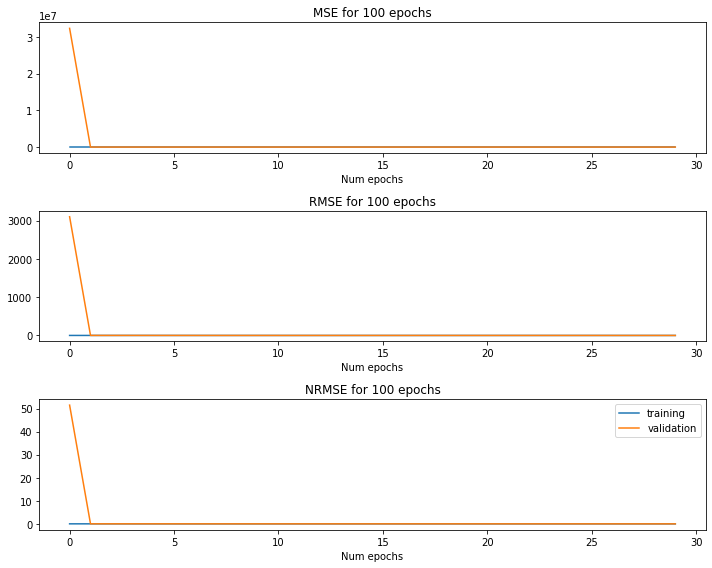

In [ ]:
plotLoss(train_loss_e, val_loss_e)

## Larsen, Attention - NRMSE:

In [ ]:
from dataFunctions import *
from makeInputs import *
from config import *
from training import *
from prediction import *
from metrics import *
from reproducibility import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
SEED

0

Variables: ['LWD', 'RF', 'SP', 'SWD', 'TT', 'UUP', 'VVP']
Return input of GCMLike
Variables: ['LWD', 'RF', 'SP', 'SWD', 'TT', 'UUP', 'VVP']
Return input of GCMLike


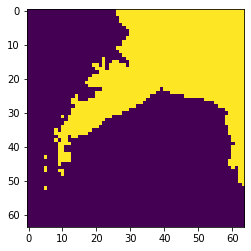

In [ ]:
REGION = "Larsen"
# Make target
targets, target_times = target_maker(target_dataset, region=REGION, resize=False)
# Full target to model
full_target = np.concatenate(targets, axis=0)
target_time = np.concatenate(target_times, axis=0)
target_lon = target_dataset["x"]
target_lat = target_dataset["y"]

# Make input
i1D, i2D, i1D_ns, i2D_ns, VAR_LIST = make_inputs(
    GCMLike = GCMLike, 
    GCM = None,
    size_input_domain=SIZE_INPUT_DOMAIN, 
    Region=REGION, 
    dropvar = None
)
full_input = [np.concatenate([i2D], axis=0), np.concatenate([i1D], axis=0)]
full_input_ns = [
    np.concatenate([i2D_ns], axis=0),
    np.concatenate([i1D_ns], axis=0),
]

REGIONS = [REGION]

mask = createMask(full_target[0,:,:], onechannel = True)
plt.imshow(mask)

In [ ]:
%%time
NUM_EPOCHS = 50
LOSS_ = 'NRMSE'
TYPENET = 'Attention'
LR = 0.005
# Parameters used in training
trainingParam = dict(
    num_epochs=NUM_EPOCHS, 
    batch_size=BATCH_SIZE, 
    lr=LR,
    seed=SEED, 
    amp=AMP,
    test_percent = TEST_PERCENT,
    val_percent = VAL_PERCENT, 
    loss_ = LOSS_, 
    typeNet = TYPENET,
    ignoreSea = False,
    nrmse_maxmin = True, # normalise by (max-min) or by mean of target
    earlystopping = 15,
)
print(trainingParam)
# Load datasets and U-Net 
train_loss_e, val_loss_e, train_set, test_set, net, nameModel = trainFlow(
    full_input,
    full_target,
    torch.tensor(mask),
    region=REGION,
    train=True, # train True so that actually trains
    randomSplit = False, # don't take random time samples but take future as test, 
    **trainingParam
)

INFO: Using device cuda
INFO: Attention SmAt_UNet model


{'num_epochs': 50, 'batch_size': 32, 'lr': 0.005, 'seed': 0, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 15}


INFO: Network:
	7 input channels X
	16 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 7, 32, 32])


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅█████████████
learning rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train loss,█▅▅▆▄▃▅▄▃▃▄▂▄▅▃▄▅▃▃▄▃▄▃▃▂▂▄▂▃▂▂▂▃▂▁▂▂▂▁▃
validation mse,████████▇▆▅▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▅▁▁▅▃
epoch,3
learning rate,0.005
step,99
train loss,0.01404
validation mse,0.01698


INFO: Starting training:
		Epochs:          50
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/50: 100%|██████████| 1046/1046 [00:09<00:00, 108.62timestep/s, loss (batch)=0.0159]
INFO: Checkpoint 2 saved!
Epoch 3/50: 100%|██████████| 1046/1046 [00:09<00:00, 107.93timestep/s, loss (batch)=0.0142]
INFO: Checkpoint 3 saved!
Epoch 5/50: 100%|██████████| 1046/1046 [00:09<00:00, 107.68timestep/s, loss (batch)=0.0135]
INFO: Checkpoint 5 saved!
Epoch 9/50: 100%|██████████| 1046/1046 [00:09<00:00, 107.38timestep/s, loss (batch)=0.0124]
INFO: Checkpoint 9 saved!
Epoch 15/50: 100%|██████████| 1046/1046 [00:09<00:00, 107.01timestep/s, loss (batch)=0.0115]


Epoch 00015: reducing learning rate of group 0 to 5.0000e-04.


Epoch 16/50: 100%|██████████| 1046/1046 [00:10<00:00, 103.06timestep/s, loss (batch)=0.0118]
INFO: Checkpoint 16 saved!
Epoch 22/50: 100%|██████████| 1046/1046 [00:09<00:00, 106.22timestep/s, loss (batch)=0.0101]


Epoch 00022: reducing learning rate of group 0 to 5.0000e-05.


Epoch 27/50: 100%|██████████| 1046/1046 [00:09<00:00, 106.19timestep/s, loss (batch)=0.0097]


Epoch 00027: reducing learning rate of group 0 to 5.0000e-06.


Epoch 31/50: 100%|██████████| 1046/1046 [00:09<00:00, 105.14timestep/s, loss (batch)=0.00966]
INFO: Stopping early --> mean val score 0.014789510518312454 has not decreased over 15 epochs compared to best 0.01487814448773861 
INFO: Saving model on google drive


CPU times: user 3min 11s, sys: 2min 10s, total: 5min 21s
Wall time: 5min 20s


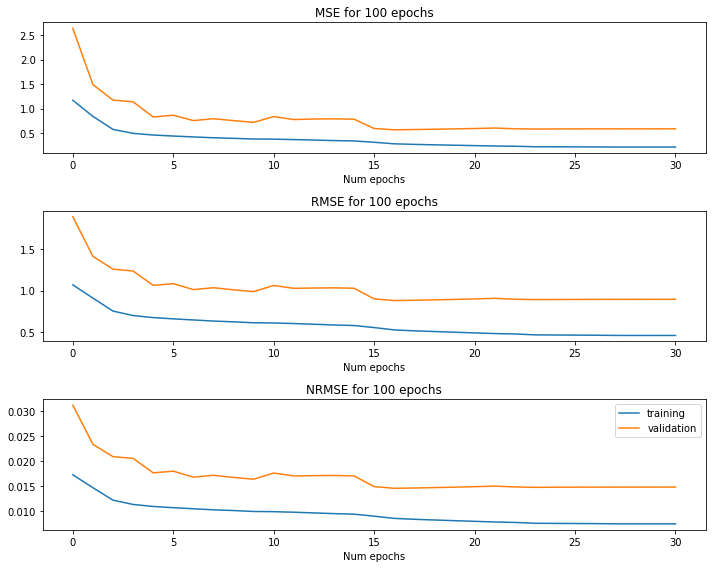

In [ ]:
plotLoss(train_loss_e, val_loss_e)

## Feature selection:

In [ ]:
import itertools

variables = ["RF", "SP", "LWD", "SWD", "TT", "VVP", "UUP"]
list_comb = []
for i in range(1, 4):
    combinations = itertools.combinations(variables, i)
    for comb in combinations:
        list_comb.append([el for el in comb])
len(list_comb)

In [ ]:
metrics_per_params,loss_per_params = [], []

numiter = 1
N = len(list_comb)
for var in list_comb[:int(N/2)]:
  print(f'Number of iteration:{numiter}/{int(N/2)}')
  loss_ = 'NRMSE'
  typenet_ = 'Attention'
  lr = LR # 0.005
  NUM_EPOCHS = 35

  REGION = "Larsen"
  # Make target
  targets, target_times = target_maker(target_dataset, region=REGION, resize=False)
  # Full target to model
  full_target = np.concatenate(targets, axis=0)
  target_time = np.concatenate(target_times, axis=0)
  target_lon = target_dataset["x"]
  target_lat = target_dataset["y"]

  # Make input
  i1D, i2D, i1D_ns, i2D_ns, VAR_LIST = make_inputs(
      GCMLike = GCMLike, 
      GCM = None,
      size_input_domain=SIZE_INPUT_DOMAIN, 
      Region=REGION, 
      dropvar = var
  )
  full_input = [np.concatenate([i2D], axis=0), np.concatenate([i1D], axis=0)]
  full_input_ns = [
      np.concatenate([i2D_ns], axis=0),
      np.concatenate([i1D_ns], axis=0),
  ]

  REGIONS = [REGION]

  mask = createMask(full_target[0,:,:], onechannel = True)
  
  # Parameters used in training
  trainingParam = dict(
      num_epochs=NUM_EPOCHS, 
      batch_size=BATCH_SIZE, 
      lr=lr,
      seed=SEED, 
      amp=AMP,
      test_percent = TEST_PERCENT,
      val_percent = VAL_PERCENT, 
      loss_ = loss_, 
      typeNet = typenet_,
      ignoreSea = False,
      nrmse_maxmin = True, # normalise by (max-min) or by mean of target
      earlystopping = 15,
      savetoGD = False # no need to save to google cloud
  )
  print(trainingParam)
  # Load datasets and U-Net 
  train_loss_e, val_loss_e, train_set, test_set, net, nameModel = trainFlow(
      full_input,
      full_target,
      torch.tensor(mask),
      region=REGION,
      train=True, # train True so that actually trains
      randomSplit = False, # don't take random time samples but take future as test, 
      **trainingParam
  )

  # calculate metrics on model saved locally
  today = str(date.today())
  dir_checkpoint = Path("./checkpoints/")
  model = str(dir_checkpoint / nameModel)

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  
  # make predictions
  (preds_Larsen,
      x_Larsen,
      z_Larsen,
      true_smb_Larsen,
      r_Larsen,
  ) = predict(net, device, test_set, model)

  PearsonCorr, Wasserstein, ROV, MSE, RMSE, NRMSE, PearsonCorrAn, ROD = calculateMetrics(
      preds_Larsen,
      true_smb_Larsen,
      target_dataset,
      train_set,
      REGION,
      ignoreSea = True,
  )
  metrics = [{'mean':np.nanmean(RMSE)}, {'mean':np.nanmean(PearsonCorr)}, {'mean':np.nanmean(Wasserstein)}]
  l = {'MSE':val_loss_e['MSE'][-1], 'RMSE':val_loss_e['RMSE'][-1], 'NRMSE':val_loss_e['NRMSE'][-1]}
  metrics_per_params.append(metrics)
  loss_per_params.append(l)
  numiter += 1

In [ ]:
dfs = []
for i in range(len(metrics_per_params)):
  df = pd.DataFrame(metrics_per_params[i], index=["RMSE","Corr", "Wass"])
  df["Var"] = [listtostring(list_comb[i]) for j in range(len(df))]
  df = df.reset_index()
  dfs.append(df)

df = pd.concat(dfs).groupby(['Var', 'index']).mean()
df = pd.pivot_table(df, columns = ['index'], index = ['Var'])
df.columns = df.columns.droplevel()
df

In [ ]:
pathGD = f"/content/gdrive/My Drive/Master-thesis/features_1.csv"
df.to_csv(pathGD)

In [ ]:
metrics_per_params,loss_per_params = [], []

numiter = 1
N = len(list_comb)
for var in list_comb[int(N/2):]:
  print(f'Number of iteration:{numiter}/{int(N/2)}')
  loss_ = 'NRMSE'
  typenet_ = 'Attention'
  lr = LR # 0.005
  NUM_EPOCHS = 35

  REGION = "Larsen"
  # Make target
  targets, target_times = target_maker(target_dataset, region=REGION, resize=False)
  # Full target to model
  full_target = np.concatenate(targets, axis=0)
  target_time = np.concatenate(target_times, axis=0)
  target_lon = target_dataset["x"]
  target_lat = target_dataset["y"]

  # Make input
  i1D, i2D, i1D_ns, i2D_ns, VAR_LIST = make_inputs(
      GCMLike = GCMLike, 
      GCM = None,
      size_input_domain=SIZE_INPUT_DOMAIN, 
      Region=REGION, 
      dropvar = var
  )
  full_input = [np.concatenate([i2D], axis=0), np.concatenate([i1D], axis=0)]
  full_input_ns = [
      np.concatenate([i2D_ns], axis=0),
      np.concatenate([i1D_ns], axis=0),
  ]

  REGIONS = [REGION]

  mask = createMask(full_target[0,:,:], onechannel = True)
  
  # Parameters used in training
  trainingParam = dict(
      num_epochs=NUM_EPOCHS, 
      batch_size=BATCH_SIZE, 
      lr=lr,
      seed=SEED, 
      amp=AMP,
      test_percent = TEST_PERCENT,
      val_percent = VAL_PERCENT, 
      loss_ = loss_, 
      typeNet = typenet_,
      ignoreSea = False,
      nrmse_maxmin = True, # normalise by (max-min) or by mean of target
      earlystopping = 15,
      savetoGD = False # no need to save to google cloud
  )
  print(trainingParam)
  # Load datasets and U-Net 
  train_loss_e, val_loss_e, train_set, test_set, net, nameModel = trainFlow(
      full_input,
      full_target,
      torch.tensor(mask),
      region=REGION,
      train=True, # train True so that actually trains
      randomSplit = False, # don't take random time samples but take future as test, 
      **trainingParam
  )

  # calculate metrics on model saved locally
  today = str(date.today())
  dir_checkpoint = Path("./checkpoints/")
  model = str(dir_checkpoint / nameModel)

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  
  # make predictions
  (preds_Larsen,
      x_Larsen,
      z_Larsen,
      true_smb_Larsen,
      r_Larsen,
  ) = predict(net, device, test_set, model)

  PearsonCorr, Wasserstein, ROV, MSE, RMSE, NRMSE, PearsonCorrAn, ROD = calculateMetrics(
      preds_Larsen,
      true_smb_Larsen,
      target_dataset,
      train_set,
      REGION,
      ignoreSea = True,
  )
  metrics = [{'mean':np.nanmean(RMSE)}, {'mean':np.nanmean(PearsonCorr)}, {'mean':np.nanmean(Wasserstein)}]
  l = {'MSE':val_loss_e['MSE'][-1], 'RMSE':val_loss_e['RMSE'][-1], 'NRMSE':val_loss_e['NRMSE'][-1]}
  metrics_per_params.append(metrics)
  loss_per_params.append(l)
  numiter += 1

dfs = []
for i in range(len(metrics_per_params)):
  df = pd.DataFrame(metrics_per_params[i], index=["RMSE","Corr", "Wass"])
  df["Var"] = [listtostring(list_comb[i]) for j in range(len(df))]
  df = df.reset_index()
  dfs.append(df)

df = pd.concat(dfs).groupby(['Var', 'index']).mean()
df = pd.pivot_table(df, columns = ['index'], index = ['Var'])
df.columns = df.columns.droplevel()
pathGD = f"/content/gdrive/My Drive/Master-thesis/features_2.csv"
df.to_csv(pathGD)

Number of iteration:1/31
Variables: ['LWD', 'SWD', 'TT', 'UUP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['LWD', 'SWD', 'TT', 'UUP']
Return input of GCMLike
{'num_epochs': 35, 'batch_size': 32, 'lr': 0.005, 'seed': 0, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 15, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
learning rate,████████▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▅▄▄▃▃▂▃▂▂▂▃▃▃▃▂▂▂▂▂▂▂▂▃▂▃▂▂▂▂▂▂▂▂▃▂▃▂▂▁
validation mse,▂▁▂█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,29
learning rate,0.0
step,957
train loss,0.01113
validation mse,0.01859


INFO: Starting training:
		Epochs:          35
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 3/35: 100%|██████████| 1046/1046 [00:21<00:00, 48.82timestep/s, loss (batch)=0.0138]
INFO: Checkpoint 3 saved!
Epoch 4/35: 100%|██████████| 1046/1046 [00:21<00:00, 49.30timestep/s, loss (batch)=0.0135]
INFO: Checkpoint 4 saved!
Epoch 5/35: 100%|██████████| 1046/1046 [00:21<00:00, 49.79timestep/s, loss (batch)=0.0132]
INFO: Checkpoint 5 saved!
Epoch 7/35: 100%|██████████| 1046/1046 [00:20<00:00, 50.13timestep/s, loss (batch)=0.0128]
INFO: Checkpoint 7 saved!
Epoch 13/35: 100%|██████████| 1046/1046 [00:20<00:00, 50.39timestep/s, loss (batch)=0.0119]
INFO: Checkpoint 13 saved!
Epoch 20/35: 100%|██████████| 1046/1046 [00:21<00:00, 49.73timestep/s, loss (batch)=0.0114]


Epoch 00020: reducing learning rate of group 0 to 5.0000e-04.


Epoch 21/35: 100%|██████████| 1046/1046 [00:20<00:00, 50.04timestep/s, loss (batch)=0.0109]
INFO: Checkpoint 21 saved!
Epoch 26/35: 100%|██████████| 1046/1046 [00:21<00:00, 49.73timestep/s, loss (batch)=0.00951]


Epoch 00026: reducing learning rate of group 0 to 5.0000e-05.


Epoch 31/35: 100%|██████████| 1046/1046 [00:21<00:00, 49.39timestep/s, loss (batch)=0.00908]


Epoch 00031: reducing learning rate of group 0 to 5.0000e-06.


Epoch 35/35: 100%|██████████| 1046/1046 [00:21<00:00, 49.36timestep/s, loss (batch)=0.00906]
INFO: Loading saved model checkpoints/MODEL_2022-05-29_Larsen_35_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than 

Number of iteration:2/31
Variables: ['LWD', 'SWD', 'TT', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['LWD', 'SWD', 'TT', 'VVP']
Return input of GCMLike
{'num_epochs': 35, 'batch_size': 32, 'lr': 0.005, 'seed': 0, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 15, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
learning rate,███████████████████████▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▇▄▄▄▃▄▄▃▄▃▃▃▂▂▃▃▄▄▄▃▂▃▃▂▂▁▂▂▂▁▁▂▂▂▂▃▃▂▁
validation mse,▂█▃▂▃▂▂▂▃▂▁▁▁▂▂▃▁▂▁▁▁▁▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▂▁
epoch,35
learning rate,1e-05
step,1155
train loss,0.00906
validation mse,0.01552


INFO: Starting training:
		Epochs:          35
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 3/35: 100%|██████████| 1046/1046 [00:21<00:00, 49.34timestep/s, loss (batch)=0.0136]
INFO: Checkpoint 3 saved!
Epoch 4/35: 100%|██████████| 1046/1046 [00:21<00:00, 49.57timestep/s, loss (batch)=0.0133]
INFO: Checkpoint 4 saved!
Epoch 5/35: 100%|██████████| 1046/1046 [00:21<00:00, 49.26timestep/s, loss (batch)=0.0133]
INFO: Checkpoint 5 saved!
Epoch 12/35: 100%|██████████| 1046/1046 [00:21<00:00, 48.80timestep/s, loss (batch)=0.0122]
INFO: Checkpoint 12 saved!
Epoch 15/35: 100%|██████████| 1046/1046 [00:21<00:00, 49.39timestep/s, loss (batch)=0.0118]
INFO: Checkpoint 15 saved!
Epoch 23/35: 100%|██████████| 1046/1046 [00:21<00:00, 48.90timestep/s, loss (batch)=0.0108]


Epoch 00023: reducing learning rate of group 0 to 5.0000e-04.


Epoch 24/35: 100%|██████████| 1046/1046 [00:21<00:00, 48.62timestep/s, loss (batch)=0.0107]
INFO: Checkpoint 24 saved!
Epoch 31/35: 100%|██████████| 1046/1046 [00:21<00:00, 48.06timestep/s, loss (batch)=0.00918]


Epoch 00031: reducing learning rate of group 0 to 5.0000e-05.


Epoch 35/35: 100%|██████████| 1046/1046 [00:21<00:00, 48.39timestep/s, loss (batch)=0.00891]
INFO: Loading saved model checkpoints/MODEL_2022-05-29_Larsen_35_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than 

Number of iteration:3/31
Variables: ['SP', 'TT', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['SP', 'TT', 'UUP', 'VVP']
Return input of GCMLike
{'num_epochs': 35, 'batch_size': 32, 'lr': 0.005, 'seed': 0, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 15, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
learning rate,██████████████████████████▂▂▂▂▂▂▂▂▂▁▁▁▁▁
step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▇▄▄▄▃▄▄▂▄▃▃▃▂▂▃▃▄▄▄▃▂▃▂▂▃▂▃▃▃▂▁▂▂▂▂▃▂▁▁
validation mse,▂█▂▁▃▁▂▂▃▁▁▁▁▂▁▂▁▂▁▁▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,35
learning rate,5e-05
step,1155
train loss,0.00891
validation mse,0.01275


INFO: Starting training:
		Epochs:          35
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/35: 100%|██████████| 1046/1046 [00:21<00:00, 48.47timestep/s, loss (batch)=0.0168]
INFO: Checkpoint 2 saved!
Epoch 5/35: 100%|██████████| 1046/1046 [00:21<00:00, 48.33timestep/s, loss (batch)=0.0138]
INFO: Checkpoint 5 saved!
Epoch 7/35: 100%|██████████| 1046/1046 [00:21<00:00, 48.23timestep/s, loss (batch)=0.0131]
INFO: Checkpoint 7 saved!
Epoch 15/35: 100%|██████████| 1046/1046 [00:21<00:00, 48.30timestep/s, loss (batch)=0.012]


Epoch 00015: reducing learning rate of group 0 to 5.0000e-04.


Epoch 17/35: 100%|██████████| 1046/1046 [00:21<00:00, 48.29timestep/s, loss (batch)=0.0117]
INFO: Checkpoint 17 saved!
Epoch 22/35: 100%|██████████| 1046/1046 [00:21<00:00, 48.34timestep/s, loss (batch)=0.0111]


Epoch 00022: reducing learning rate of group 0 to 5.0000e-05.


Epoch 27/35: 100%|██████████| 1046/1046 [00:21<00:00, 48.03timestep/s, loss (batch)=0.0105]


Epoch 00027: reducing learning rate of group 0 to 5.0000e-06.


Epoch 32/35: 100%|██████████| 1046/1046 [00:21<00:00, 47.93timestep/s, loss (batch)=0.0105]
INFO: Stopping early --> mean val score 0.02119365520775318 has not decreased over 15 epochs compared to best 0.020801573991775513 


Epoch 00032: reducing learning rate of group 0 to 5.0000e-07.


INFO: Loading saved model checkpoints/MODEL_2022-05-29_Larsen_31_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib

Number of iteration:4/31
Variables: ['SP', 'SWD', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['SP', 'SWD', 'UUP', 'VVP']
Return input of GCMLike
{'num_epochs': 35, 'batch_size': 32, 'lr': 0.005, 'seed': 0, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 15, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
learning rate,███████████████████▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▇▅▄▃▃▃▃▃▄▄▃▃▃▂▂▂▃▄▂▂▃▂▂▂▂▂▂▂▃▂▂▂▂▁▁▂▂▂▃
validation mse,▃▂▃█▄▂▁▅▁▁▁▂▂▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,32
learning rate,1e-05
step,1056
train loss,0.01052
validation mse,0.01538


INFO: Starting training:
		Epochs:          35
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/35: 100%|██████████| 1046/1046 [00:22<00:00, 45.81timestep/s, loss (batch)=0.0147]
INFO: Checkpoint 2 saved!
Epoch 3/35: 100%|██████████| 1046/1046 [00:22<00:00, 47.51timestep/s, loss (batch)=0.0142]
INFO: Checkpoint 3 saved!
Epoch 4/35: 100%|██████████| 1046/1046 [00:21<00:00, 47.68timestep/s, loss (batch)=0.0136]
INFO: Checkpoint 4 saved!
Epoch 6/35: 100%|██████████| 1046/1046 [00:22<00:00, 47.44timestep/s, loss (batch)=0.0129]
INFO: Checkpoint 6 saved!
Epoch 7/35: 100%|██████████| 1046/1046 [00:21<00:00, 47.64timestep/s, loss (batch)=0.0128]
INFO: Checkpoint 7 saved!
Epoch 18/35: 100%|██████████| 1046/1046 [00:22<00:00, 47.12timestep/s, loss (batch)=0.011]


Epoch 00018: reducing learning rate of group 0 to 5.0000e-04.


Epoch 19/35: 100%|██████████| 1046/1046 [00:22<00:00, 47.26timestep/s, loss (batch)=0.0112]
INFO: Checkpoint 19 saved!
Epoch 25/35: 100%|██████████| 1046/1046 [00:22<00:00, 46.87timestep/s, loss (batch)=0.00983]


Epoch 00025: reducing learning rate of group 0 to 5.0000e-05.


Epoch 30/35: 100%|██████████| 1046/1046 [00:22<00:00, 47.12timestep/s, loss (batch)=0.0094]


Epoch 00030: reducing learning rate of group 0 to 5.0000e-06.


Epoch 34/35: 100%|██████████| 1046/1046 [00:22<00:00, 47.09timestep/s, loss (batch)=0.00937]
INFO: Stopping early --> mean val score 0.014916149899363518 has not decreased over 15 epochs compared to best 0.0153170395642519 
INFO: Loading saved model checkpoints/MODEL_2022-05-29_Larsen_33_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:40: UserWarning: To copy construct from a

Number of iteration:5/31
Variables: ['SP', 'SWD', 'TT', 'UUP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['SP', 'SWD', 'TT', 'UUP']
Return input of GCMLike
{'num_epochs': 35, 'batch_size': 32, 'lr': 0.005, 'seed': 0, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 15, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
learning rate,█████████████████████▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▇▅▃▄▄▄▄▂▅▄▄▃▂▄▂▃▄▂▃▃▄▂▂▁▂▂▁▂▂▁▁▁▂▂▂▂▃▃▂
validation mse,█▇▄▅▄▃▂▂▂▂▃▂▂▂▁▁▃▄▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,34
learning rate,1e-05
step,1122
train loss,0.00937
validation mse,0.01086


INFO: Starting training:
		Epochs:          35
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/35: 100%|██████████| 1046/1046 [00:22<00:00, 46.04timestep/s, loss (batch)=0.0146]
INFO: Checkpoint 2 saved!
Epoch 3/35: 100%|██████████| 1046/1046 [00:22<00:00, 46.19timestep/s, loss (batch)=0.0139]
INFO: Checkpoint 3 saved!
Epoch 4/35: 100%|██████████| 1046/1046 [00:22<00:00, 45.76timestep/s, loss (batch)=0.0131]
INFO: Checkpoint 4 saved!
Epoch 6/35: 100%|██████████| 1046/1046 [00:22<00:00, 46.15timestep/s, loss (batch)=0.0128]
INFO: Checkpoint 6 saved!
Epoch 14/35: 100%|██████████| 1046/1046 [00:22<00:00, 45.83timestep/s, loss (batch)=0.0121]
INFO: Checkpoint 14 saved!
Epoch 24/35: 100%|██████████| 1046/1046 [00:22<00:00, 45.70timestep/s, loss (batch)=0.0112]


Epoch 00024: reducing learning rate of group 0 to 5.0000e-04.


Epoch 25/35: 100%|██████████| 1046/1046 [00:23<00:00, 45.39timestep/s, loss (batch)=0.011]
INFO: Checkpoint 25 saved!
Epoch 30/35: 100%|██████████| 1046/1046 [00:22<00:00, 45.49timestep/s, loss (batch)=0.00973]


Epoch 00030: reducing learning rate of group 0 to 5.0000e-05.


Epoch 35/35: 100%|██████████| 1046/1046 [00:23<00:00, 45.33timestep/s, loss (batch)=0.00942]


Epoch 00035: reducing learning rate of group 0 to 5.0000e-06.


INFO: Loading saved model checkpoints/MODEL_2022-05-29_Larsen_35_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib

Number of iteration:6/31
Variables: ['SP', 'SWD', 'TT', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['SP', 'SWD', 'TT', 'VVP']
Return input of GCMLike
{'num_epochs': 35, 'batch_size': 32, 'lr': 0.005, 'seed': 0, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 15, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
learning rate,████████████████████████████▂▂▂▂▂▂▁▁▁▁▁▁
step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▆▄▃▃▂▃▄▂▃▃▃▂▂▂▃▃▄▄▃▂▂▃▂▂▂▂▃▃▂▁▁▁▂▁▂▃▂▁▁
validation mse,█▅▇▃▅▂▂▃▂▂▁▂▁▃▂▁▁▁▂▂▁▁▂▂▁▁▃▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch,35
learning rate,5e-05
step,1155
train loss,0.00942
validation mse,0.01112


INFO: Starting training:
		Epochs:          35
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/35: 100%|██████████| 1046/1046 [00:23<00:00, 45.24timestep/s, loss (batch)=0.0146]
INFO: Checkpoint 2 saved!
Epoch 4/35: 100%|██████████| 1046/1046 [00:23<00:00, 45.30timestep/s, loss (batch)=0.0131]
INFO: Checkpoint 4 saved!
Epoch 5/35: 100%|██████████| 1046/1046 [00:23<00:00, 44.93timestep/s, loss (batch)=0.0128]
INFO: Checkpoint 5 saved!
Epoch 6/35: 100%|██████████| 1046/1046 [00:23<00:00, 44.87timestep/s, loss (batch)=0.0126]
INFO: Checkpoint 6 saved!
Epoch 12/35: 100%|██████████| 1046/1046 [00:22<00:00, 45.54timestep/s, loss (batch)=0.0122]
INFO: Checkpoint 12 saved!
Epoch 17/35: 100%|██████████| 1046/1046 [00:23<00:00, 45.02timestep/s, loss (batch)=0.0111]


Epoch 00017: reducing learning rate of group 0 to 5.0000e-04.


Epoch 19/35: 100%|██████████| 1046/1046 [00:23<00:00, 44.78timestep/s, loss (batch)=0.0109]
INFO: Checkpoint 19 saved!
Epoch 24/35: 100%|██████████| 1046/1046 [00:23<00:00, 45.30timestep/s, loss (batch)=0.00989]


Epoch 00024: reducing learning rate of group 0 to 5.0000e-05.


Epoch 29/35: 100%|██████████| 1046/1046 [00:23<00:00, 45.18timestep/s, loss (batch)=0.00951]


Epoch 00029: reducing learning rate of group 0 to 5.0000e-06.


Epoch 34/35: 100%|██████████| 1046/1046 [00:23<00:00, 44.70timestep/s, loss (batch)=0.00947]
INFO: Stopping early --> mean val score 0.017200548201799393 has not decreased over 15 epochs compared to best 0.015604864805936813 


Epoch 00034: reducing learning rate of group 0 to 5.0000e-07.


INFO: Loading saved model checkpoints/MODEL_2022-05-30_Larsen_33_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib

Number of iteration:7/31
Variables: ['LWD', 'SP', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['LWD', 'SP', 'UUP', 'VVP']
Return input of GCMLike
{'num_epochs': 35, 'batch_size': 32, 'lr': 0.005, 'seed': 0, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 15, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
learning rate,████████████████████▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▇▄▃▄▄▄▄▃▅▄▄▃▂▄▂▃▄▃▃▃▃▂▂▁▂▂▁▃▂▁▁▁▂▂▂▂▃▃▂
validation mse,█▄▆▄▆▂▂▂▂▂▂▁▁▂▁▂▂▂▂▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
epoch,34
learning rate,1e-05
step,1122
train loss,0.00947
validation mse,0.01259


INFO: Starting training:
		Epochs:          35
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/35: 100%|██████████| 1046/1046 [00:23<00:00, 44.44timestep/s, loss (batch)=0.0154]
INFO: Checkpoint 2 saved!
Epoch 7/35: 100%|██████████| 1046/1046 [00:23<00:00, 44.29timestep/s, loss (batch)=0.013]


Epoch 00007: reducing learning rate of group 0 to 5.0000e-04.


Epoch 12/35: 100%|██████████| 1046/1046 [00:23<00:00, 44.17timestep/s, loss (batch)=0.0121]


Epoch 00012: reducing learning rate of group 0 to 5.0000e-05.


Epoch 17/35: 100%|██████████| 1046/1046 [00:23<00:00, 44.12timestep/s, loss (batch)=0.0116]


Epoch 00017: reducing learning rate of group 0 to 5.0000e-06.


Epoch 21/35: 100%|██████████| 1046/1046 [00:23<00:00, 44.66timestep/s, loss (batch)=0.0116]
INFO: Stopping early --> mean val score 0.03125572204589844 has not decreased over 15 epochs compared to best 0.02214726060628891 
INFO: Loading saved model checkpoints/MODEL_2022-05-30_Larsen_20_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:40: UserWarning: To copy construct from a 

Number of iteration:8/31
Variables: ['LWD', 'SP', 'TT', 'UUP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['LWD', 'SP', 'TT', 'UUP']
Return input of GCMLike
{'num_epochs': 35, 'batch_size': 32, 'lr': 0.005, 'seed': 0, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 15, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
learning rate,█████████████▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▆▅▄▃▃▂▃▂▂▃▃▃▃▂▃▂▂▂▂▂▂▁▂▁▂▂▂▂▂▃▂▃▂▂▂▂▁▃▂
validation mse,█▇▃▂▃▅▅▃▅▁▅▃█▄▄▄▆▄█▅▇▆▆▅▇▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇
epoch,21
learning rate,1e-05
step,693
train loss,0.01161
validation mse,0.02336


INFO: Starting training:
		Epochs:          35
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/35: 100%|██████████| 1046/1046 [00:23<00:00, 44.59timestep/s, loss (batch)=0.0148]
INFO: Checkpoint 2 saved!
Epoch 5/35: 100%|██████████| 1046/1046 [00:23<00:00, 43.91timestep/s, loss (batch)=0.013]
INFO: Checkpoint 5 saved!
Epoch 8/35: 100%|██████████| 1046/1046 [00:23<00:00, 44.27timestep/s, loss (batch)=0.0127]
INFO: Checkpoint 8 saved!
Epoch 14/35: 100%|██████████| 1046/1046 [00:23<00:00, 43.94timestep/s, loss (batch)=0.0121]


Epoch 00014: reducing learning rate of group 0 to 5.0000e-04.


Epoch 15/35: 100%|██████████| 1046/1046 [00:23<00:00, 43.95timestep/s, loss (batch)=0.0118]
INFO: Checkpoint 15 saved!
Epoch 20/35: 100%|██████████| 1046/1046 [00:23<00:00, 43.85timestep/s, loss (batch)=0.011]


Epoch 00020: reducing learning rate of group 0 to 5.0000e-05.


Epoch 25/35: 100%|██████████| 1046/1046 [00:24<00:00, 43.57timestep/s, loss (batch)=0.0106]


Epoch 00025: reducing learning rate of group 0 to 5.0000e-06.


Epoch 30/35: 100%|██████████| 1046/1046 [00:24<00:00, 43.18timestep/s, loss (batch)=0.0106]
INFO: Stopping early --> mean val score 0.01859554648399353 has not decreased over 15 epochs compared to best 0.017293553799390793 


Epoch 00030: reducing learning rate of group 0 to 5.0000e-07.


INFO: Loading saved model checkpoints/MODEL_2022-05-30_Larsen_29_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib

Number of iteration:9/31
Variables: ['LWD', 'SP', 'TT', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['LWD', 'SP', 'TT', 'VVP']
Return input of GCMLike
{'num_epochs': 35, 'batch_size': 32, 'lr': 0.005, 'seed': 0, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 15, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
learning rate,███████████████████▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▆▄▄▃▃▂▃▃▄▄▃▃▃▂▂▂▂▃▂▂▃▃▂▃▂▂▂▂▂▂▁▂▂▂▁▁▂▁▂
validation mse,█▆▂▃▄▃▂▂▂▁▃▁▂▂▁▅▂▁▃▂▁▁▂▂▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
epoch,30
learning rate,1e-05
step,990
train loss,0.0106
validation mse,0.01369


INFO: Starting training:
		Epochs:          35
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/35: 100%|██████████| 1046/1046 [00:23<00:00, 43.75timestep/s, loss (batch)=0.0149]
INFO: Checkpoint 2 saved!
Epoch 3/35: 100%|██████████| 1046/1046 [00:24<00:00, 43.50timestep/s, loss (batch)=0.0138]
INFO: Checkpoint 3 saved!
Epoch 4/35: 100%|██████████| 1046/1046 [00:23<00:00, 43.66timestep/s, loss (batch)=0.0137]
INFO: Checkpoint 4 saved!
Epoch 9/35: 100%|██████████| 1046/1046 [00:24<00:00, 43.20timestep/s, loss (batch)=0.0126]
INFO: Checkpoint 9 saved!
Epoch 15/35: 100%|██████████| 1046/1046 [00:24<00:00, 43.43timestep/s, loss (batch)=0.0118]


Epoch 00015: reducing learning rate of group 0 to 5.0000e-04.


Epoch 16/35: 100%|██████████| 1046/1046 [00:24<00:00, 43.42timestep/s, loss (batch)=0.0119]
INFO: Checkpoint 16 saved!
Epoch 22/35: 100%|██████████| 1046/1046 [00:24<00:00, 43.34timestep/s, loss (batch)=0.0112]


Epoch 00022: reducing learning rate of group 0 to 5.0000e-05.


Epoch 27/35: 100%|██████████| 1046/1046 [00:24<00:00, 43.20timestep/s, loss (batch)=0.0106]


Epoch 00027: reducing learning rate of group 0 to 5.0000e-06.


Epoch 31/35: 100%|██████████| 1046/1046 [00:24<00:00, 43.33timestep/s, loss (batch)=0.0105]
INFO: Stopping early --> mean val score 0.015208768658339977 has not decreased over 15 epochs compared to best 0.015006428584456444 
INFO: Loading saved model checkpoints/MODEL_2022-05-30_Larsen_30_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:40: UserWarning: To copy construct from 

Number of iteration:10/31
Variables: ['LWD', 'SP', 'SWD', 'UUP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['LWD', 'SP', 'SWD', 'UUP']
Return input of GCMLike
{'num_epochs': 35, 'batch_size': 32, 'lr': 0.005, 'seed': 0, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 15, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
learning rate,████████████████████▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▆▄▅▃▄▂▃▃▂▄▃▃▃▃▃▂▂▃▃▂▂▂▂▂▁▂▂▂▂▂▂▂▂▁▁▂▁▂▂
validation mse,█▆▄▅▂▂▂▄▂▁▁▃▂▁▄▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,31
learning rate,1e-05
step,1023
train loss,0.01054
validation mse,0.01108


INFO: Starting training:
		Epochs:          35
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/35: 100%|██████████| 1046/1046 [00:24<00:00, 43.28timestep/s, loss (batch)=0.0148]
INFO: Checkpoint 2 saved!
Epoch 3/35: 100%|██████████| 1046/1046 [00:24<00:00, 43.08timestep/s, loss (batch)=0.014]
INFO: Checkpoint 3 saved!
Epoch 4/35: 100%|██████████| 1046/1046 [00:24<00:00, 42.89timestep/s, loss (batch)=0.0136]
INFO: Checkpoint 4 saved!
Epoch 5/35: 100%|██████████| 1046/1046 [00:24<00:00, 42.76timestep/s, loss (batch)=0.0134]
INFO: Checkpoint 5 saved!
Epoch 8/35: 100%|██████████| 1046/1046 [00:24<00:00, 43.02timestep/s, loss (batch)=0.0126]
INFO: Checkpoint 8 saved!
Epoch 19/35: 100%|██████████| 1046/1046 [00:24<00:00, 42.98timestep/s, loss (batch)=0.0114]


Epoch 00019: reducing learning rate of group 0 to 5.0000e-04.


Epoch 20/35: 100%|██████████| 1046/1046 [00:24<00:00, 42.64timestep/s, loss (batch)=0.0112]
INFO: Checkpoint 20 saved!
Epoch 26/35: 100%|██████████| 1046/1046 [00:24<00:00, 42.90timestep/s, loss (batch)=0.00982]


Epoch 00026: reducing learning rate of group 0 to 5.0000e-05.


Epoch 31/35: 100%|██████████| 1046/1046 [00:24<00:00, 42.68timestep/s, loss (batch)=0.00934]


Epoch 00031: reducing learning rate of group 0 to 5.0000e-06.


Epoch 35/35: 100%|██████████| 1046/1046 [00:24<00:00, 43.07timestep/s, loss (batch)=0.00931]
INFO: Stopping early --> mean val score 0.015294977463781834 has not decreased over 15 epochs compared to best 0.015299723483622074 
INFO: Loading saved model checkpoints/MODEL_2022-05-30_Larsen_34_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:40: UserWarning: To copy construct from

Number of iteration:11/31
Variables: ['LWD', 'SP', 'SWD', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['LWD', 'SP', 'SWD', 'VVP']
Return input of GCMLike
{'num_epochs': 35, 'batch_size': 32, 'lr': 0.005, 'seed': 0, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 15, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
learning rate,██████████████████████▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▇▄▃▄▃▃▄▂▄▃▃▃▂▂▃▃▄▄▄▃▂▂▂▂▂▁▂▂▂▁▁▁▂▂▂▃▃▂▁
validation mse,█▅▅▃▂▂▂▂▂▂▁▂▂▃▂▁▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,35
learning rate,1e-05
step,1155
train loss,0.00931
validation mse,0.01113


INFO: Starting training:
		Epochs:          35
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 6/35: 100%|██████████| 1046/1046 [00:24<00:00, 43.00timestep/s, loss (batch)=0.0127]


Epoch 00006: reducing learning rate of group 0 to 5.0000e-04.


Epoch 11/35: 100%|██████████| 1046/1046 [00:24<00:00, 42.92timestep/s, loss (batch)=0.012]


Epoch 00011: reducing learning rate of group 0 to 5.0000e-05.


Epoch 16/35: 100%|██████████| 1046/1046 [00:24<00:00, 42.68timestep/s, loss (batch)=0.0117]


Epoch 00016: reducing learning rate of group 0 to 5.0000e-06.


Epoch 21/35: 100%|██████████| 1046/1046 [00:24<00:00, 42.47timestep/s, loss (batch)=0.0116]
INFO: Stopping early --> mean val score 0.04243260622024536 has not decreased over 15 epochs compared to best 0.03764410316944122 


Epoch 00021: reducing learning rate of group 0 to 5.0000e-07.


INFO: Loading saved model checkpoints/MODEL_2022-05-30_Larsen_20_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib

Number of iteration:12/31
Variables: ['LWD', 'SP', 'SWD', 'TT']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['LWD', 'SP', 'SWD', 'TT']
Return input of GCMLike
{'num_epochs': 35, 'batch_size': 32, 'lr': 0.005, 'seed': 0, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 15, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
learning rate,████████████▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▆▄▄▃▃▂▃▃▂▃▃▂▃▂▃▂▂▃▂▂▂▁▂▁▂▂▂▂▂▃▂▃▂▂▂▂▁▃▂
validation mse,▁▁▆█▅▁▇▁▃▁▃▂▂▁▂▁▂▁▂▁▂▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
epoch,21
learning rate,1e-05
step,693
train loss,0.01163
validation mse,0.03119


INFO: Starting training:
		Epochs:          35
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/35: 100%|██████████| 1046/1046 [00:24<00:00, 41.88timestep/s, loss (batch)=0.0148]
INFO: Checkpoint 2 saved!
Epoch 3/35: 100%|██████████| 1046/1046 [00:24<00:00, 42.01timestep/s, loss (batch)=0.0141]
INFO: Checkpoint 3 saved!
Epoch 7/35: 100%|██████████| 1046/1046 [00:24<00:00, 42.23timestep/s, loss (batch)=0.0127]
INFO: Checkpoint 7 saved!
Epoch 12/35: 100%|██████████| 1046/1046 [00:25<00:00, 41.82timestep/s, loss (batch)=0.0122]
INFO: Checkpoint 12 saved!
Epoch 17/35: 100%|██████████| 1046/1046 [00:25<00:00, 41.62timestep/s, loss (batch)=0.0119]


Epoch 00017: reducing learning rate of group 0 to 5.0000e-04.


Epoch 22/35: 100%|██████████| 1046/1046 [00:25<00:00, 41.72timestep/s, loss (batch)=0.011]


Epoch 00022: reducing learning rate of group 0 to 5.0000e-05.


Epoch 27/35: 100%|██████████| 1046/1046 [00:25<00:00, 41.66timestep/s, loss (batch)=0.0103]
INFO: Stopping early --> mean val score 0.024773791432380676 has not decreased over 15 epochs compared to best 0.017004922032356262 


Epoch 00027: reducing learning rate of group 0 to 5.0000e-06.


INFO: Loading saved model checkpoints/MODEL_2022-05-30_Larsen_26_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib

Number of iteration:13/31
Variables: ['RF', 'TT', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['RF', 'TT', 'UUP', 'VVP']
Return input of GCMLike
{'num_epochs': 35, 'batch_size': 32, 'lr': 0.005, 'seed': 0, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 15, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
learning rate,█████████████████████████▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▆▅▃▃▃▄▂▃▃▃▄▃▃▃▃▃▂▂▂▂▂▂▃▂▂▂▂▂▂▁▁▂▂▁▃▂▂▁▁
validation mse,▂▆▄▃▁▃▂▃▂▂▁▂▂▁▂▃▁▁█▂▂▂▂▂▂▁▁▂▂▁▂▂▂▂▂▂▂▂▂▂
epoch,27
learning rate,5e-05
step,891
train loss,0.01034
validation mse,0.01836


INFO: Starting training:
		Epochs:          35
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/35: 100%|██████████| 1046/1046 [00:24<00:00, 41.93timestep/s, loss (batch)=0.0147]
INFO: Checkpoint 2 saved!
Epoch 4/35: 100%|██████████| 1046/1046 [00:24<00:00, 41.91timestep/s, loss (batch)=0.0131]
INFO: Checkpoint 4 saved!
Epoch 7/35: 100%|██████████| 1046/1046 [00:24<00:00, 41.99timestep/s, loss (batch)=0.013]
INFO: Checkpoint 7 saved!
Epoch 12/35: 100%|██████████| 1046/1046 [00:25<00:00, 41.82timestep/s, loss (batch)=0.0125]
INFO: Checkpoint 12 saved!
Epoch 17/35: 100%|██████████| 1046/1046 [00:24<00:00, 41.94timestep/s, loss (batch)=0.0118]


Epoch 00017: reducing learning rate of group 0 to 5.0000e-04.


Epoch 18/35: 100%|██████████| 1046/1046 [00:25<00:00, 41.83timestep/s, loss (batch)=0.0114]
INFO: Checkpoint 18 saved!
Epoch 19/35: 100%|██████████| 1046/1046 [00:24<00:00, 41.91timestep/s, loss (batch)=0.0111]
INFO: Checkpoint 19 saved!
Epoch 24/35: 100%|██████████| 1046/1046 [00:25<00:00, 41.79timestep/s, loss (batch)=0.0102]


Epoch 00024: reducing learning rate of group 0 to 5.0000e-05.


Epoch 29/35: 100%|██████████| 1046/1046 [00:25<00:00, 41.68timestep/s, loss (batch)=0.00979]


Epoch 00029: reducing learning rate of group 0 to 5.0000e-06.


Epoch 34/35: 100%|██████████| 1046/1046 [00:25<00:00, 41.29timestep/s, loss (batch)=0.00977]
INFO: Stopping early --> mean val score 0.016185179352760315 has not decreased over 15 epochs compared to best 0.015459565445780754 


Epoch 00034: reducing learning rate of group 0 to 5.0000e-07.


INFO: Loading saved model checkpoints/MODEL_2022-05-30_Larsen_33_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib

Number of iteration:14/31
Variables: ['RF', 'SWD', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['RF', 'SWD', 'UUP', 'VVP']
Return input of GCMLike
{'num_epochs': 35, 'batch_size': 32, 'lr': 0.005, 'seed': 0, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 15, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
learning rate,████████████████████▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▇▄▃▃▃▃▄▂▅▄▄▃▂▄▂▃▄▃▃▃▃▂▂▁▂▂▁▂▂▁▁▁▂▂▂▂▃▃▂
validation mse,█▅▄▇▃▇▄▂▃▄▂▃▂▂▂▃▂▂▅▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,34
learning rate,1e-05
step,1122
train loss,0.00977
validation mse,0.01163


INFO: Starting training:
		Epochs:          35
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/35: 100%|██████████| 1046/1046 [00:25<00:00, 41.14timestep/s, loss (batch)=0.0144]
INFO: Checkpoint 2 saved!
Epoch 3/35: 100%|██████████| 1046/1046 [00:25<00:00, 41.02timestep/s, loss (batch)=0.0139]
INFO: Checkpoint 3 saved!
Epoch 4/35: 100%|██████████| 1046/1046 [00:25<00:00, 41.07timestep/s, loss (batch)=0.0135]
INFO: Checkpoint 4 saved!
Epoch 6/35: 100%|██████████| 1046/1046 [00:25<00:00, 40.54timestep/s, loss (batch)=0.013]
INFO: Checkpoint 6 saved!
Epoch 10/35: 100%|██████████| 1046/1046 [00:25<00:00, 40.61timestep/s, loss (batch)=0.0124]
INFO: Checkpoint 10 saved!
Epoch 17/35: 100%|██████████| 1046/1046 [00:25<00:00, 40.57timestep/s, loss (batch)=0.0114]


Epoch 00017: reducing learning rate of group 0 to 5.0000e-04.


Epoch 18/35: 100%|██████████| 1046/1046 [00:25<00:00, 40.65timestep/s, loss (batch)=0.0111]
INFO: Checkpoint 18 saved!
Epoch 24/35: 100%|██████████| 1046/1046 [00:25<00:00, 40.24timestep/s, loss (batch)=0.00979]


Epoch 00024: reducing learning rate of group 0 to 5.0000e-05.


Epoch 29/35: 100%|██████████| 1046/1046 [00:25<00:00, 40.56timestep/s, loss (batch)=0.0093]


Epoch 00029: reducing learning rate of group 0 to 5.0000e-06.


Epoch 33/35: 100%|██████████| 1046/1046 [00:26<00:00, 40.06timestep/s, loss (batch)=0.00927]
INFO: Stopping early --> mean val score 0.014969024807214737 has not decreased over 15 epochs compared to best 0.015066918917000294 
INFO: Loading saved model checkpoints/MODEL_2022-05-30_Larsen_32_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:40: UserWarning: To copy construct from

Number of iteration:15/31
Variables: ['RF', 'SWD', 'TT', 'UUP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['RF', 'SWD', 'TT', 'UUP']
Return input of GCMLike
{'num_epochs': 35, 'batch_size': 32, 'lr': 0.005, 'seed': 0, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 15, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇████
learning rate,█████████████████████▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▆▄▃▃▄▄▄▄▅▄▃▃▃▄▃▂▂▄▄▄▂▃▂▂▁▂▂▃▂▂▁▁▁▂▂▂▂▃▃
validation mse,█▄▃▅▂▁▂▂▂▃▁▁▁▂▂▁▁▁▂▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,33
learning rate,1e-05
step,1089
train loss,0.00927
validation mse,0.01091


INFO: Starting training:
		Epochs:          35
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/35: 100%|██████████| 1046/1046 [00:26<00:00, 39.99timestep/s, loss (batch)=0.0145]
INFO: Checkpoint 2 saved!
Epoch 3/35: 100%|██████████| 1046/1046 [00:25<00:00, 40.34timestep/s, loss (batch)=0.0138]
INFO: Checkpoint 3 saved!
Epoch 4/35: 100%|██████████| 1046/1046 [00:25<00:00, 40.50timestep/s, loss (batch)=0.0131]
INFO: Checkpoint 4 saved!
Epoch 5/35: 100%|██████████| 1046/1046 [00:26<00:00, 40.10timestep/s, loss (batch)=0.013]
INFO: Checkpoint 5 saved!
Epoch 7/35: 100%|██████████| 1046/1046 [00:26<00:00, 39.92timestep/s, loss (batch)=0.013]
INFO: Checkpoint 7 saved!
Epoch 9/35: 100%|██████████| 1046/1046 [00:26<00:00, 40.16timestep/s, loss (batch)=0.0126]
INFO: Checkpoint 9 saved!
Epoch 15/35: 100%|██████████| 1046/1046 [00:25<00:00, 40.38timestep/s, loss (batch)=

Epoch 00015: reducing learning rate of group 0 to 5.0000e-04.


Epoch 16/35: 100%|██████████| 1046/1046 [00:26<00:00, 40.17timestep/s, loss (batch)=0.0115]
INFO: Checkpoint 16 saved!
Epoch 22/35: 100%|██████████| 1046/1046 [00:26<00:00, 40.17timestep/s, loss (batch)=0.0104]


Epoch 00022: reducing learning rate of group 0 to 5.0000e-05.


Epoch 27/35: 100%|██████████| 1046/1046 [00:26<00:00, 40.07timestep/s, loss (batch)=0.0098]


Epoch 00027: reducing learning rate of group 0 to 5.0000e-06.


Epoch 31/35: 100%|██████████| 1046/1046 [00:25<00:00, 40.24timestep/s, loss (batch)=0.00978]
INFO: Stopping early --> mean val score 0.015025807544589043 has not decreased over 15 epochs compared to best 0.015098312869668007 
INFO: Loading saved model checkpoints/MODEL_2022-05-30_Larsen_30_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:40: UserWarning: To copy construct from

Number of iteration:16/31
Variables: ['RF', 'SWD', 'TT', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['RF', 'SWD', 'TT', 'VVP']
Return input of GCMLike
{'num_epochs': 35, 'batch_size': 32, 'lr': 0.005, 'seed': 0, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 15, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
learning rate,████████████████████▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▅▄▅▃▄▂▃▃▂▄▄▃▃▃▃▂▃▃▃▃▂▂▂▂▁▂▂▂▂▁▂▂▂▁▁▂▁▂▂
validation mse,█▅▃▃▂▃▂▂▂▁▂▂▁▁▂▃▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,31
learning rate,1e-05
step,1023
train loss,0.00978
validation mse,0.01094


INFO: Starting training:
		Epochs:          35
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/35: 100%|██████████| 1046/1046 [00:26<00:00, 40.12timestep/s, loss (batch)=0.0163]
INFO: Checkpoint 2 saved!
Epoch 3/35: 100%|██████████| 1046/1046 [00:26<00:00, 40.02timestep/s, loss (batch)=0.0139]
INFO: Checkpoint 3 saved!
Epoch 7/35: 100%|██████████| 1046/1046 [00:26<00:00, 39.93timestep/s, loss (batch)=0.0127]
INFO: Checkpoint 7 saved!
Epoch 9/35: 100%|██████████| 1046/1046 [00:26<00:00, 39.95timestep/s, loss (batch)=0.0125]
INFO: Checkpoint 9 saved!
Epoch 14/35: 100%|██████████| 1046/1046 [00:26<00:00, 40.02timestep/s, loss (batch)=0.0118]


Epoch 00014: reducing learning rate of group 0 to 5.0000e-04.


Epoch 15/35: 100%|██████████| 1046/1046 [00:26<00:00, 39.67timestep/s, loss (batch)=0.0117]
INFO: Checkpoint 15 saved!
Epoch 21/35: 100%|██████████| 1046/1046 [00:29<00:00, 35.70timestep/s, loss (batch)=0.0102]


Epoch 00021: reducing learning rate of group 0 to 5.0000e-05.


Epoch 26/35: 100%|██████████| 1046/1046 [00:26<00:00, 39.31timestep/s, loss (batch)=0.00968]


Epoch 00026: reducing learning rate of group 0 to 5.0000e-06.


Epoch 30/35: 100%|██████████| 1046/1046 [00:26<00:00, 39.43timestep/s, loss (batch)=0.00966]
INFO: Stopping early --> mean val score 0.014788484200835228 has not decreased over 15 epochs compared to best 0.014462910592556 
INFO: Loading saved model checkpoints/MODEL_2022-05-30_Larsen_29_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:40: UserWarning: To copy construct from a 

Number of iteration:17/31
Variables: ['LWD', 'RF', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['LWD', 'RF', 'UUP', 'VVP']
Return input of GCMLike
{'num_epochs': 35, 'batch_size': 32, 'lr': 0.005, 'seed': 0, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 15, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
learning rate,███████████████████▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▅▄▅▄▃▃▃▃▃▄▃▃▃▃▂▃▂▃▂▂▄▃▂▃▂▂▂▂▂▂▂▂▂▂▁▁▂▁▂
validation mse,█▅▅▃▂▂▃▂▂▃▃▁▂▁▂▄▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,30
learning rate,1e-05
step,990
train loss,0.00966
validation mse,0.01078


INFO: Starting training:
		Epochs:          35
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/35: 100%|██████████| 1046/1046 [00:26<00:00, 38.97timestep/s, loss (batch)=0.0145]
INFO: Checkpoint 2 saved!
Epoch 3/35: 100%|██████████| 1046/1046 [00:26<00:00, 38.99timestep/s, loss (batch)=0.0139]
INFO: Checkpoint 3 saved!
Epoch 8/35: 100%|██████████| 1046/1046 [00:26<00:00, 38.92timestep/s, loss (batch)=0.0129]


Epoch 00008: reducing learning rate of group 0 to 5.0000e-04.


Epoch 13/35: 100%|██████████| 1046/1046 [00:27<00:00, 38.60timestep/s, loss (batch)=0.0122]
INFO: Checkpoint 13 saved!
Epoch 16/35: 100%|██████████| 1046/1046 [00:26<00:00, 39.00timestep/s, loss (batch)=0.0119]
INFO: Checkpoint 16 saved!
Epoch 18/35: 100%|██████████| 1046/1046 [00:27<00:00, 38.32timestep/s, loss (batch)=0.0117]
INFO: Checkpoint 18 saved!
Epoch 25/35: 100%|██████████| 1046/1046 [00:26<00:00, 39.01timestep/s, loss (batch)=0.0103]
INFO: Checkpoint 25 saved!
Epoch 31/35: 100%|██████████| 1046/1046 [00:27<00:00, 38.40timestep/s, loss (batch)=0.0103]


Epoch 00031: reducing learning rate of group 0 to 5.0000e-05.


Epoch 35/35: 100%|██████████| 1046/1046 [00:27<00:00, 38.22timestep/s, loss (batch)=0.00941]
INFO: Loading saved model checkpoints/MODEL_2022-05-30_Larsen_35_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than 

Number of iteration:18/31
Variables: ['LWD', 'RF', 'TT', 'UUP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['LWD', 'RF', 'TT', 'UUP']
Return input of GCMLike
{'num_epochs': 35, 'batch_size': 32, 'lr': 0.005, 'seed': 0, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 15, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
learning rate,██████████▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▆▃▃▃▂▃▃▂▃▂▂▂▁▂▂▂▃▄▃▂▂▂▂▂▂▁▂▂▂▁▁▁▂▂▂▂▂▁▁
validation mse,▂▆▂▂█▂▂▂▃▁▁▂▂▂▂▂▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
epoch,35
learning rate,5e-05
step,1155
train loss,0.00941
validation mse,0.01978


INFO: Starting training:
		Epochs:          35
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 4/35: 100%|██████████| 1046/1046 [00:27<00:00, 38.44timestep/s, loss (batch)=0.0135]
INFO: Checkpoint 4 saved!
Epoch 6/35: 100%|██████████| 1046/1046 [00:26<00:00, 38.75timestep/s, loss (batch)=0.0127]
INFO: Checkpoint 6 saved!
Epoch 9/35: 100%|██████████| 1046/1046 [00:27<00:00, 38.62timestep/s, loss (batch)=0.013]
INFO: Checkpoint 9 saved!
Epoch 14/35: 100%|██████████| 1046/1046 [00:27<00:00, 37.87timestep/s, loss (batch)=0.0118]


Epoch 00014: reducing learning rate of group 0 to 5.0000e-04.


Epoch 15/35: 100%|██████████| 1046/1046 [00:27<00:00, 38.41timestep/s, loss (batch)=0.0116]
INFO: Checkpoint 15 saved!
Epoch 20/35: 100%|██████████| 1046/1046 [00:27<00:00, 37.71timestep/s, loss (batch)=0.0108]


Epoch 00020: reducing learning rate of group 0 to 5.0000e-05.


Epoch 25/35: 100%|██████████| 1046/1046 [00:27<00:00, 37.64timestep/s, loss (batch)=0.0103]


Epoch 00025: reducing learning rate of group 0 to 5.0000e-06.


Epoch 30/35: 100%|██████████| 1046/1046 [00:27<00:00, 37.55timestep/s, loss (batch)=0.0102]
INFO: Stopping early --> mean val score 0.02465854398906231 has not decreased over 15 epochs compared to best 0.023225756362080574 


Epoch 00030: reducing learning rate of group 0 to 5.0000e-07.


INFO: Loading saved model checkpoints/MODEL_2022-05-30_Larsen_29_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib

Number of iteration:19/31
Variables: ['LWD', 'RF', 'TT', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['LWD', 'RF', 'TT', 'VVP']
Return input of GCMLike
{'num_epochs': 35, 'batch_size': 32, 'lr': 0.005, 'seed': 0, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 15, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
learning rate,███████████████████▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▅▄▄▃▃▂▃▃▃▄▂▃▃▂▂▂▂▃▂▂▃▂▂▃▂▂▁▂▂▂▁▂▂▂▁▁▂▁▂
validation mse,▃█▆▆▄▄▂▂▄▁▂▄▂▄▁▂▅▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
epoch,30
learning rate,1e-05
step,990
train loss,0.01024
validation mse,0.01799


INFO: Starting training:
		Epochs:          35
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 3/35: 100%|██████████| 1046/1046 [00:28<00:00, 37.35timestep/s, loss (batch)=0.0141]
INFO: Checkpoint 3 saved!
Epoch 4/35: 100%|██████████| 1046/1046 [00:28<00:00, 37.29timestep/s, loss (batch)=0.0135]
INFO: Checkpoint 4 saved!
Epoch 5/35: 100%|██████████| 1046/1046 [00:28<00:00, 37.01timestep/s, loss (batch)=0.0131]
INFO: Checkpoint 5 saved!
Epoch 10/35: 100%|██████████| 1046/1046 [00:27<00:00, 37.50timestep/s, loss (batch)=0.0123]


Epoch 00010: reducing learning rate of group 0 to 5.0000e-04.


Epoch 11/35: 100%|██████████| 1046/1046 [00:27<00:00, 37.53timestep/s, loss (batch)=0.0123]
INFO: Checkpoint 11 saved!
Epoch 12/35:  55%|█████▌    | 576/1046 [00:13<00:09, 49.11timestep/s, loss (batch)=0.00825]

In [ ]:
def listtostring(list_):
  m = list_[0]
  if len(list_)>1:
    for i in list_[1:]:
      m += ','+i
    return m
  else:
    return m

In [ ]:
dfs = []
for i in range(len(metrics_per_params)):
  df = pd.DataFrame(metrics_per_params[i], index=["RMSE","Corr", "Wasserstein"])
  df["Var"] = [listtostring(list_comb[i]) for j in range(len(df))]
  df = df.reset_index()
  dfs.append(df)

df = pd.concat(dfs).groupby(['Var', 'index']).mean()
df = pd.pivot_table(df, columns = ['index'], index = ['Var'])
df.columns = df.columns.droplevel()
df

In [ ]:
df.sort_values(by = 'Corr', axis = 0, ascending = False)[(df['Corr']>0.57)&(df['RMSE']<1.1)]

### Feature selection with GCM:

In [ ]:
import itertools
variables = ['RF', 'SP', 'LWD', 'SWD', 'TT', 'VVP', 'UUP']
list_comb = []
for i in range(1,4):
  combinations = itertools.combinations(variables, i)
  for comb in combinations:
    list_comb.append([el for el in comb])
print('Number of combinations:',len(list_comb))

Number of combinations: 63


In [ ]:
%%time
metrics_per_params,loss_per_params = [], []
for var in list_comb:
  loss_ = 'NRMSE'
  typenet_ = 'Attention'
  lr = 0.005
  NUM_EPOCHS = 30

  REGION = "Larsen"
  # Make target
  targets, target_times = target_maker(target_dataset, region=REGION, resize=False)
  # Full target to model
  full_target = np.concatenate(targets, axis=0)
  target_time = np.concatenate(target_times, axis=0)
  target_lon = target_dataset["x"]
  target_lat = target_dataset["y"]

  # Make input
  i1D, i2D, i1D_ns, i2D_ns, VAR_LIST = make_inputs(
      GCMLike = GCMLike, 
      GCM = None,
      size_input_domain=SIZE_INPUT_DOMAIN, 
      Region=REGION, 
      regionNbr=0,
      dropvar = var
  )
  full_input = [np.concatenate([i2D], axis=0), np.concatenate([i1D], axis=0)]
  REGIONS = [REGION]
  mask = createMask(full_target[0,:,:], onechannel = True)
  
  # Parameters used in training
  trainingParam = dict(
      num_epochs=NUM_EPOCHS, 
      batch_size=BATCH_SIZE, 
      lr=lr,
      seed=SEED, 
      amp=AMP,
      test_percent = TEST_PERCENT,
      val_percent = VAL_PERCENT, 
      loss_ = loss_, 
      typeNet = typenet_,
      ignoreSea = False,
      nrmse_maxmin = True, # normalise by (max-min) or by mean of target
      earlystopping = 8,
      savetoGD = False # no need to save to google cloud
  )
  print(trainingParam)
  # Load datasets and U-Net 
  train_loss_e, val_loss_e, train_set, test_set, net, nameModel = trainFlow(
      full_input,
      full_target,
      torch.tensor(mask),
      region=REGION,
      train=True, # train True so that actually trains
      randomSplit = False, # don't take random time samples but take future as test, 
      **trainingParam
  )

  # Calulate metrics on GCM:
  # Make input
  i1D_GCM, i2D_GCM, i1D_ns, i2D_ns, VAR_LIST = make_inputs(
      GCMLike = GCMLike, GCM = GCM, size_input_domain=SIZE_INPUT_DOMAIN, Region=REGION, regionNbr=0, 
      dropvar = var
  )
  full_input_GCM = [np.concatenate([i2D_GCM], axis=0), np.concatenate([i1D_GCM], axis=0)]
  # Load datasets and U-Net
  train_set, test_set, net = trainFlow(
      full_input_GCM,
      full_target,
      mask,
      region=REGION,
      train=False,
      randomSplit=False,
      **trainingParam,
  )
  loader_args = dict(batch_size=1, num_workers=2, pin_memory=True)
  test_loader = DataLoader(test_set, shuffle=False, **loader_args)

  # Calculate metrics on model saved locally
  today = str(date.today())
  dir_checkpoint = Path("./checkpoints/")
  model = str(dir_checkpoint / nameModel)

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  
  # Make predictions
  (preds_Larsen,
      x_Larsen,
      z_Larsen,
      true_smb_Larsen,
      r_Larsen,
  ) = predict(net, device, test_loader, model)

  PearsonCorr, Wasserstein, ROV, MSE, RMSE, NRMSE, PearsonCorrAn, ROD = calculateMetrics(
      preds_Larsen,
      true_smb_Larsen,
      target_dataset,
      train_set,
      REGION,
      ignoreSea = True,
  )
  metrics = [{'mean':np.nanmean(RMSE)}, {'mean':np.nanmean(PearsonCorr)}, {'mean':np.nanmean(Wasserstein)}]
  l = {'MSE':val_loss_e['MSE'][-1], 'RMSE':val_loss_e['RMSE'][-1], 'NRMSE':val_loss_e['NRMSE'][-1]}
  metrics_per_params.append(metrics)
  loss_per_params.append(l)

Variables: ['LWD', 'SP', 'SWD', 'TT', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['LWD', 'SP', 'SWD', 'TT', 'UUP', 'VVP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	6 input channels X
	14 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 6, 32, 32])


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
learning rate,█████████████████████▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▅▅▅▃▄▂▃▄▄▂▃▂▃▂▃▃▂▃▂▂▂▂▂▃▂▂▁▂▁▃▂▂▂▂▁▁▂▁▁
validation mse,██▄▄▃▃▁▂▁▂▁▁▁▁▁▃▁▁▂▂▁▁▁▂▂▁▂▁▂▁▂▂▂▂▂▂▂▂▂▂
epoch,21
learning rate,5e-05
step,693
train loss,0.00997
validation mse,0.01251


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 6/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.97timestep/s, loss (batch)=0.0123]


Epoch 00006: reducing learning rate of group 0 to 5.0000e-04.


Epoch 8/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.93timestep/s, loss (batch)=0.0124]
INFO: Checkpoint 8 saved!
Epoch 12/30: 100%|██████████| 1046/1046 [00:05<00:00, 204.74timestep/s, loss (batch)=0.012]
INFO: Checkpoint 12 saved!
Epoch 14/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.40timestep/s, loss (batch)=0.0118]
INFO: Checkpoint 14 saved!
Epoch 16/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.58timestep/s, loss (batch)=0.0114]
INFO: Checkpoint 16 saved!
Epoch 19/30: 100%|██████████| 1046/1046 [00:05<00:00, 204.50timestep/s, loss (batch)=0.0108]
INFO: Checkpoint 19 saved!
Epoch 27/30: 100%|██████████| 1046/1046 [00:05<00:00, 201.60timestep/s, loss (batch)=0.0097]
INFO: Stopping early --> mean val score 0.020275000482797623 has not decreased over 8 epochs compared to best 0.02054518647491932 


Epoch 00027: reducing learning rate of group 0 to 5.0000e-05.
Variables: ['LWD', 'SP', 'SWD', 'TT', 'UUP', 'VVP']
Return input of GCM
Variables: ['LWD', 'SP', 'SWD', 'TT', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	6 input channels X
	14 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_26_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 6, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['LWD', 'RF', 'SWD', 'TT', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['LWD', 'RF', 'SWD', 'TT', 'UUP', 'VVP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	6 input channels X
	14 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 6, 32, 32])


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
learning rate,█████████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▅▅▃▄▃▃▄▄▂▃▃▃▃▃▃▂▃▃▂▃▂▂▂▃▂▂▂▂▂▂▂▁▁▂▃▂▂▂▂
validation mse,▂▂▃▄█▂▃▃▂▂▂▂▂▂▁▂▁▂▂▂▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
epoch,27
learning rate,0.0005
step,891
train loss,0.0097
validation mse,0.01784


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.73timestep/s, loss (batch)=0.0157]
INFO: Checkpoint 2 saved!
Epoch 3/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.98timestep/s, loss (batch)=0.0137]
INFO: Checkpoint 3 saved!
Epoch 5/30: 100%|██████████| 1046/1046 [00:05<00:00, 201.87timestep/s, loss (batch)=0.0124]
INFO: Checkpoint 5 saved!
Epoch 11/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.07timestep/s, loss (batch)=0.0114]
INFO: Checkpoint 11 saved!
Epoch 21/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.57timestep/s, loss (batch)=0.00995]
INFO: Stopping early --> mean val score 0.0165114663541317 has not decreased over 8 epochs compared to best 0.01601588726043701 


Epoch 00021: reducing learning rate of group 0 to 5.0000e-04.
Variables: ['LWD', 'RF', 'SWD', 'TT', 'UUP', 'VVP']
Return input of GCM
Variables: ['LWD', 'RF', 'SWD', 'TT', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	6 input channels X
	14 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_20_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 6, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['RF', 'SP', 'SWD', 'TT', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['RF', 'SP', 'SWD', 'TT', 'UUP', 'VVP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	6 input channels X
	14 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 6, 32, 32])


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
learning rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▅▅▅▃▄▂▂▃▃▂▃▂▂▂▃▃▂▃▂▂▂▂▂▃▂▂▁▂▁▂▂▃▂▂▂▁▂▁▁
validation mse,██▄▃▃▃▂▄▁▃▂▂▁▁▁▃▁▁▂▁▁▁▁▂▄▁▄▂▃▁▁▁▂▂▁▂▂▁▂▄
epoch,21
learning rate,0.005
step,693
train loss,0.00995
validation mse,0.01415


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 201.64timestep/s, loss (batch)=0.0145]
INFO: Checkpoint 2 saved!
Epoch 4/30: 100%|██████████| 1046/1046 [00:05<00:00, 204.23timestep/s, loss (batch)=0.0123]
INFO: Checkpoint 4 saved!
Epoch 8/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.68timestep/s, loss (batch)=0.0116]
INFO: Checkpoint 8 saved!
Epoch 16/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.57timestep/s, loss (batch)=0.0101]


Epoch 00016: reducing learning rate of group 0 to 5.0000e-04.


Epoch 17/30: 100%|██████████| 1046/1046 [00:05<00:00, 201.46timestep/s, loss (batch)=0.0107]
INFO: Checkpoint 17 saved!
Epoch 18/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.84timestep/s, loss (batch)=0.0102]
INFO: Checkpoint 18 saved!
Epoch 23/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.63timestep/s, loss (batch)=0.00902]


Epoch 00023: reducing learning rate of group 0 to 5.0000e-05.


Epoch 26/30: 100%|██████████| 1046/1046 [00:05<00:00, 191.83timestep/s, loss (batch)=0.0085]
INFO: Stopping early --> mean val score 0.014803418889641762 has not decreased over 8 epochs compared to best 0.014097956009209156 


Variables: ['RF', 'SP', 'SWD', 'TT', 'UUP', 'VVP']
Return input of GCM
Variables: ['RF', 'SP', 'SWD', 'TT', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	6 input channels X
	14 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_25_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 6, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['LWD', 'RF', 'SP', 'TT', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['LWD', 'RF', 'SP', 'TT', 'UUP', 'VVP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	6 input channels X
	14 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 6, 32, 32])


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
learning rate,█████████████████████████▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▅▄▃▄▃▃▄▃▂▂▂▃▃▃▂▃▂▂▂▂▂▂▂▃▂▂▂▂▂▂▁▂▂▁▂▁▂▂▁
validation mse,█▆▂▃▃▃▃▂▂▂▁▂▃▃▂▂▁▂▄▂▄▁▂▃▆▁▁▁▁▁▁▁▁▂▁▂▁▁▁▁
epoch,26
learning rate,5e-05
step,858
train loss,0.0085
validation mse,0.01081


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 201.63timestep/s, loss (batch)=0.0169]
INFO: Checkpoint 2 saved!
Epoch 3/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.77timestep/s, loss (batch)=0.0144]
INFO: Checkpoint 3 saved!
Epoch 4/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.95timestep/s, loss (batch)=0.0136]
INFO: Checkpoint 4 saved!
Epoch 5/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.84timestep/s, loss (batch)=0.0131]
INFO: Checkpoint 5 saved!
Epoch 9/30: 100%|██████████| 1046/1046 [00:05<00:00, 201.88timestep/s, loss (batch)=0.012]
INFO: Checkpoint 9 saved!
Epoch 15/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.54timestep/s, loss (batch)=0.0112]


Epoch 00015: reducing learning rate of group 0 to 5.0000e-04.


Epoch 16/30: 100%|██████████| 1046/1046 [00:05<00:00, 201.77timestep/s, loss (batch)=0.0114]
INFO: Checkpoint 16 saved!
Epoch 21/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.91timestep/s, loss (batch)=0.0102]


Epoch 00021: reducing learning rate of group 0 to 5.0000e-05.


Epoch 24/30: 100%|██████████| 1046/1046 [00:05<00:00, 196.50timestep/s, loss (batch)=0.00958]
INFO: Stopping early --> mean val score 0.014688395895063877 has not decreased over 8 epochs compared to best 0.014344343915581703 


Variables: ['LWD', 'RF', 'SP', 'TT', 'UUP', 'VVP']
Return input of GCM
Variables: ['LWD', 'RF', 'SP', 'TT', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	6 input channels X
	14 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_23_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 6, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['LWD', 'RF', 'SP', 'SWD', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['LWD', 'RF', 'SP', 'SWD', 'UUP', 'VVP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	6 input channels X
	14 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 6, 32, 32])


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇████
learning rate,█████████████████████████▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train loss,█▅▆▄▄▃▃▄▃▄▂▂▃▄▃▃▃▄▂▃▃▄▃▂▁▂▃▂▂▂▂▂▂▂▃▂▁▁▂▂
validation mse,█▇▄▄▂▃▃▂▂▂▂▃▂▄▁▁▁▁▃▁▂▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,24
learning rate,5e-05
step,792
train loss,0.00958
validation mse,0.01068


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.95timestep/s, loss (batch)=0.015]
INFO: Checkpoint 2 saved!
Epoch 3/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.71timestep/s, loss (batch)=0.0137]
INFO: Checkpoint 3 saved!
Epoch 4/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.89timestep/s, loss (batch)=0.0131]
INFO: Checkpoint 4 saved!
Epoch 11/30: 100%|██████████| 1046/1046 [00:05<00:00, 204.30timestep/s, loss (batch)=0.0115]
INFO: Checkpoint 11 saved!
Epoch 17/30: 100%|██████████| 1046/1046 [00:05<00:00, 201.46timestep/s, loss (batch)=0.0105]


Epoch 00017: reducing learning rate of group 0 to 5.0000e-04.


Epoch 18/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.70timestep/s, loss (batch)=0.0106]
INFO: Checkpoint 18 saved!
Epoch 24/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.95timestep/s, loss (batch)=0.00916]


Epoch 00024: reducing learning rate of group 0 to 5.0000e-05.


Epoch 26/30: 100%|██████████| 1046/1046 [00:05<00:00, 204.24timestep/s, loss (batch)=0.00873]
INFO: Stopping early --> mean val score 0.014839154668152332 has not decreased over 8 epochs compared to best 0.014432797208428383 


Variables: ['LWD', 'RF', 'SP', 'SWD', 'UUP', 'VVP']
Return input of GCM
Variables: ['LWD', 'RF', 'SP', 'SWD', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	6 input channels X
	14 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_25_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 6, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['LWD', 'RF', 'SP', 'SWD', 'TT', 'UUP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['LWD', 'RF', 'SP', 'SWD', 'TT', 'UUP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	6 input channels X
	14 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 6, 32, 32])


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
learning rate,██████████████████████████▂▂▂▂▂▂▂▂▂▂▂▁▁▁
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▅▅▃▄▃▃▄▃▂▂▂▃▂▃▂▃▂▂▂▂▁▂▂▃▃▂▂▂▂▁▁▂▂▁▂▂▂▂▁
validation mse,█▇▃▄▃▂▂▃▂▂▂▃▂▃▂▂▂▁▂▂▃▁▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,26
learning rate,5e-05
step,858
train loss,0.00873
validation mse,0.01084


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 200.94timestep/s, loss (batch)=0.0189]
INFO: Checkpoint 2 saved!
Epoch 3/30: 100%|██████████| 1046/1046 [00:05<00:00, 191.21timestep/s, loss (batch)=0.015]
INFO: Checkpoint 3 saved!
Epoch 5/30: 100%|██████████| 1046/1046 [00:05<00:00, 204.78timestep/s, loss (batch)=0.0128]
INFO: Checkpoint 5 saved!
Epoch 18/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.16timestep/s, loss (batch)=0.0102]


Epoch 00018: reducing learning rate of group 0 to 5.0000e-04.


Epoch 19/30: 100%|██████████| 1046/1046 [00:05<00:00, 197.71timestep/s, loss (batch)=0.0101]
INFO: Checkpoint 19 saved!
Epoch 25/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.06timestep/s, loss (batch)=0.00884]


Epoch 00025: reducing learning rate of group 0 to 5.0000e-05.


Epoch 27/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.19timestep/s, loss (batch)=0.00851]
INFO: Stopping early --> mean val score 0.01485616434365511 has not decreased over 8 epochs compared to best 0.014525244943797588 


Variables: ['LWD', 'RF', 'SP', 'SWD', 'TT', 'UUP']
Return input of GCM
Variables: ['LWD', 'RF', 'SP', 'SWD', 'TT', 'UUP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	6 input channels X
	14 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_26_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 6, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['LWD', 'RF', 'SP', 'SWD', 'TT', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['LWD', 'RF', 'SP', 'SWD', 'TT', 'VVP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	6 input channels X
	14 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 6, 32, 32])


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
learning rate,███████████████████████████▂▂▂▂▂▂▂▂▂▂▁▁▁
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▅▆▅▅▄▃▄▄▃▄▃▄▄▄▄▃▃▃▃▃▂▃▃▃▃▂▂▂▂▂▂▁▁▂▃▂▂▂▂
validation mse,█▅▄▃▄▆▁▂▂▂▂▂▃▁▁▁▃▂▁▂▁▁▂▂▃▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,27
learning rate,5e-05
step,891
train loss,0.00851
validation mse,0.01081


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.36timestep/s, loss (batch)=0.0161]
INFO: Checkpoint 2 saved!
Epoch 4/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.43timestep/s, loss (batch)=0.0127]
INFO: Checkpoint 4 saved!
Epoch 5/30: 100%|██████████| 1046/1046 [00:05<00:00, 201.78timestep/s, loss (batch)=0.0123]
INFO: Checkpoint 5 saved!
Epoch 6/30: 100%|██████████| 1046/1046 [00:05<00:00, 189.48timestep/s, loss (batch)=0.0122]
INFO: Checkpoint 6 saved!
Epoch 14/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.71timestep/s, loss (batch)=0.0109]


Epoch 00014: reducing learning rate of group 0 to 5.0000e-04.


Epoch 15/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.18timestep/s, loss (batch)=0.0111]
INFO: Checkpoint 15 saved!
Epoch 21/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.42timestep/s, loss (batch)=0.00964]


Epoch 00021: reducing learning rate of group 0 to 5.0000e-05.


Epoch 23/30: 100%|██████████| 1046/1046 [00:05<00:00, 201.97timestep/s, loss (batch)=0.00931]
INFO: Stopping early --> mean val score 0.015069558285176754 has not decreased over 8 epochs compared to best 0.014885750599205494 


Variables: ['LWD', 'RF', 'SP', 'SWD', 'TT', 'VVP']
Return input of GCM
Variables: ['LWD', 'RF', 'SP', 'SWD', 'TT', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	6 input channels X
	14 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_22_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 6, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['LWD', 'SWD', 'TT', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['LWD', 'SWD', 'TT', 'UUP', 'VVP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	5 input channels X
	12 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 5, 32, 32])


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
learning rate,█████████████████████████▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁
step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▅▆▄▅▄▄▃▄▃▄▃▃▃▄▃▃▃▄▃▃▃▄▃▂▂▂▂▃▃▃▂▂▂▂▂▃▂▁▁
validation mse,█▅▆▃▃▆▅▅▃▂▃▁▁▅▁▃▁▃▁▂▂▃▃▂▃▁▁▁▁▁▁▁▁▁▂▁▁▂▁▂
epoch,23
learning rate,5e-05
step,759
train loss,0.00931
validation mse,0.011


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 204.17timestep/s, loss (batch)=0.0193]
INFO: Checkpoint 2 saved!
Epoch 5/30: 100%|██████████| 1046/1046 [00:05<00:00, 204.11timestep/s, loss (batch)=0.0132]
INFO: Checkpoint 5 saved!
Epoch 6/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.65timestep/s, loss (batch)=0.0125]
INFO: Checkpoint 6 saved!
Epoch 13/30: 100%|██████████| 1046/1046 [00:05<00:00, 197.26timestep/s, loss (batch)=0.0108]
INFO: Checkpoint 13 saved!
Epoch 21/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.71timestep/s, loss (batch)=0.00986]
INFO: Stopping early --> mean val score 0.015453733503818512 has not decreased over 8 epochs compared to best 0.015278251841664314 


Variables: ['LWD', 'SWD', 'TT', 'UUP', 'VVP']
Return input of GCM
Variables: ['LWD', 'SWD', 'TT', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	5 input channels X
	12 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_20_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 5, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['SP', 'SWD', 'TT', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['SP', 'SWD', 'TT', 'UUP', 'VVP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	5 input channels X
	12 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 5, 32, 32])


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
learning rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▅▆▆▅▄▂▃▃▄▂▃▂▂▂▃▃▂▄▂▂▂▂▂▃▂▃▁▂▂▂▂▃▂▂▂▁▂▁▁
validation mse,██▄▄▄▄▅▂▇▂▂▁▁▁▁▂▁▁▂▁▃▃▂▁▂▁▂▁▂▃▁▁▁▁▁▂▃▁▂▂
epoch,21
learning rate,0.005
step,693
train loss,0.00986
validation mse,0.01116


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.27timestep/s, loss (batch)=0.0156]
INFO: Checkpoint 2 saved!
Epoch 4/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.39timestep/s, loss (batch)=0.0132]
INFO: Checkpoint 4 saved!
Epoch 6/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.32timestep/s, loss (batch)=0.0122]
INFO: Checkpoint 6 saved!
Epoch 13/30: 100%|██████████| 1046/1046 [00:05<00:00, 200.82timestep/s, loss (batch)=0.0114]
INFO: Checkpoint 13 saved!
Epoch 20/30: 100%|██████████| 1046/1046 [00:05<00:00, 197.48timestep/s, loss (batch)=0.0102]


Epoch 00020: reducing learning rate of group 0 to 5.0000e-04.


Epoch 21/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.37timestep/s, loss (batch)=0.0101]
INFO: Stopping early --> mean val score 0.014795640483498573 has not decreased over 8 epochs compared to best 0.01540168933570385 


Variables: ['SP', 'SWD', 'TT', 'UUP', 'VVP']
Return input of GCM
Variables: ['SP', 'SWD', 'TT', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	5 input channels X
	12 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_20_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 5, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['LWD', 'SP', 'TT', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['LWD', 'SP', 'TT', 'UUP', 'VVP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	5 input channels X
	12 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 5, 32, 32])


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
learning rate,██████████████████████████████████████▁▁
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▄▄▄▃▃▂▂▃▃▂▃▁▂▂▃▂▂▃▂▂▂▂▂▃▂▂▁▂▁▃▂▂▂▂▂▁▂▁▁
validation mse,██▄▃▇▄▂▂▁▃▂▁▂▁▂▁▂▁▃▁▂▁▁▁▂▁▂▁▂▁▁▁▂▂▃▂▂▁▁▁
epoch,21
learning rate,0.0005
step,693
train loss,0.01007
validation mse,0.01063


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.59timestep/s, loss (batch)=0.0197]
INFO: Checkpoint 2 saved!
Epoch 5/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.13timestep/s, loss (batch)=0.0127]
INFO: Checkpoint 5 saved!
Epoch 6/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.19timestep/s, loss (batch)=0.0132]
INFO: Checkpoint 6 saved!
Epoch 8/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.85timestep/s, loss (batch)=0.0124]
INFO: Checkpoint 8 saved!
Epoch 13/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.63timestep/s, loss (batch)=0.0112]


Epoch 00013: reducing learning rate of group 0 to 5.0000e-04.


Epoch 14/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.29timestep/s, loss (batch)=0.0114]
INFO: Checkpoint 14 saved!
Epoch 20/30: 100%|██████████| 1046/1046 [00:05<00:00, 201.60timestep/s, loss (batch)=0.0101]


Epoch 00020: reducing learning rate of group 0 to 5.0000e-05.


Epoch 22/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.65timestep/s, loss (batch)=0.00956]
INFO: Stopping early --> mean val score 0.015012264251708984 has not decreased over 8 epochs compared to best 0.014624291099607944 


Variables: ['LWD', 'SP', 'TT', 'UUP', 'VVP']
Return input of GCM
Variables: ['LWD', 'SP', 'TT', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	5 input channels X
	12 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_21_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 5, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['LWD', 'SP', 'SWD', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['LWD', 'SP', 'SWD', 'UUP', 'VVP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	5 input channels X
	12 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 5, 32, 32])


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
learning rate,████████████████████████▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁
step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▅▆▆▆▅▃▃▂▃▃▂▁▂▃▃▃▃▂▂▂▂▂▃▂▁▁▂▂▂▂▂▁▂▂▁▁▁▁▂
validation mse,█▇▄▄▅▆▆▃▃▂▃▁▂▂▃▂▁▂▂▂▂▁▂▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,22
learning rate,5e-05
step,726
train loss,0.00956
validation mse,0.01096


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 201.23timestep/s, loss (batch)=0.0158]
INFO: Checkpoint 2 saved!
Epoch 3/30: 100%|██████████| 1046/1046 [00:05<00:00, 204.98timestep/s, loss (batch)=0.014]
INFO: Checkpoint 3 saved!
Epoch 4/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.24timestep/s, loss (batch)=0.0135]
INFO: Checkpoint 4 saved!
Epoch 9/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.85timestep/s, loss (batch)=0.0114]
INFO: Checkpoint 9 saved!
Epoch 21/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.92timestep/s, loss (batch)=0.0098]
INFO: Stopping early --> mean val score 0.016748938709497452 has not decreased over 8 epochs compared to best 0.015835361555218697 


Variables: ['LWD', 'SP', 'SWD', 'UUP', 'VVP']
Return input of GCM
Variables: ['LWD', 'SP', 'SWD', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	5 input channels X
	12 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_20_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 5, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['LWD', 'SP', 'SWD', 'TT', 'UUP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['LWD', 'SP', 'SWD', 'TT', 'UUP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	5 input channels X
	12 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 5, 32, 32])


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
learning rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▅▅▅▃▄▂▃▃▄▂▃▂▃▂▃▃▂▃▂▃▂▂▂▃▂▃▁▂▁▃▂▃▂▂▂▁▂▂▁
validation mse,██▅▅▄▄▂▂▁▂▂▁▁▁▁▂▁▁▂▂▂▂▁▂▂▂▂▁▃▂▂▂▁▁▁▁▂▂▂▁
epoch,21
learning rate,0.005
step,693
train loss,0.0098
validation mse,0.01136


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.21timestep/s, loss (batch)=0.016]
INFO: Checkpoint 2 saved!
Epoch 3/30: 100%|██████████| 1046/1046 [00:05<00:00, 195.83timestep/s, loss (batch)=0.0141]
INFO: Checkpoint 3 saved!
Epoch 5/30: 100%|██████████| 1046/1046 [00:05<00:00, 197.60timestep/s, loss (batch)=0.0132]
INFO: Checkpoint 5 saved!
Epoch 7/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.48timestep/s, loss (batch)=0.0125]
INFO: Checkpoint 7 saved!
Epoch 13/30: 100%|██████████| 1046/1046 [00:05<00:00, 205.65timestep/s, loss (batch)=0.0114]
INFO: Checkpoint 13 saved!
Epoch 21/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.38timestep/s, loss (batch)=0.0107]
INFO: Stopping early --> mean val score 0.015691105276346207 has not decreased over 8 epochs compare

Variables: ['LWD', 'SP', 'SWD', 'TT', 'UUP']
Return input of GCM
Variables: ['LWD', 'SP', 'SWD', 'TT', 'UUP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	5 input channels X
	12 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_20_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 5, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['LWD', 'SP', 'SWD', 'TT', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['LWD', 'SP', 'SWD', 'TT', 'VVP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	5 input channels X
	12 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 5, 32, 32])


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
learning rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▄▄▄▃▃▂▂▃▃▂▃▁▂▂▃▂▂▃▂▂▁▂▂▃▁▂▁▂▁▂▂▃▂▁▂▁▁▁▁
validation mse,█▇▄▅▃▃▆▂▃▂▁▂▁▁▁▃▁▁▂▂▂▁▂▁▂▁▂▂▂▂▂▁▁▁▁▁▁▁▁▂
epoch,21
learning rate,0.005
step,693
train loss,0.01073
validation mse,0.01274


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 204.30timestep/s, loss (batch)=0.0197]
INFO: Checkpoint 2 saved!
Epoch 3/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.85timestep/s, loss (batch)=0.016]
INFO: Checkpoint 3 saved!
Epoch 5/30: 100%|██████████| 1046/1046 [00:05<00:00, 204.81timestep/s, loss (batch)=0.0132]
INFO: Checkpoint 5 saved!
Epoch 6/30: 100%|██████████| 1046/1046 [00:05<00:00, 204.33timestep/s, loss (batch)=0.0128]
INFO: Checkpoint 6 saved!
Epoch 9/30: 100%|██████████| 1046/1046 [00:05<00:00, 204.64timestep/s, loss (batch)=0.0117]
INFO: Checkpoint 9 saved!
Epoch 17/30: 100%|██████████| 1046/1046 [00:05<00:00, 206.02timestep/s, loss (batch)=0.0101]


Epoch 00017: reducing learning rate of group 0 to 5.0000e-04.


Epoch 18/30: 100%|██████████| 1046/1046 [00:05<00:00, 204.72timestep/s, loss (batch)=0.0102]
INFO: Checkpoint 18 saved!
Epoch 24/30: 100%|██████████| 1046/1046 [00:05<00:00, 205.06timestep/s, loss (batch)=0.00892]


Epoch 00024: reducing learning rate of group 0 to 5.0000e-05.


Epoch 26/30: 100%|██████████| 1046/1046 [00:05<00:00, 204.35timestep/s, loss (batch)=0.00866]
INFO: Stopping early --> mean val score 0.014700756408274174 has not decreased over 8 epochs compared to best 0.014572346583008766 


Variables: ['LWD', 'SP', 'SWD', 'TT', 'VVP']
Return input of GCM
Variables: ['LWD', 'SP', 'SWD', 'TT', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	5 input channels X
	12 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_25_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 5, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['RF', 'SWD', 'TT', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['RF', 'SWD', 'TT', 'UUP', 'VVP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	5 input channels X
	12 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 5, 32, 32])


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
learning rate,██████████████████████████▂▂▂▂▂▂▂▂▂▂▂▁▁▁
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▅▆▅▅▃▃▄▃▂▂▃▃▃▃▂▃▂▂▂▂▂▂▂▃▃▂▂▂▂▂▁▂▂▁▂▁▂▂▁
validation mse,█▆▄▄▅▃▃▅▂▂▁▁▂▂▂▂▂▁▁▁▂▁▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,26
learning rate,5e-05
step,858
train loss,0.00866
validation mse,0.01071


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.07timestep/s, loss (batch)=0.0153]
INFO: Checkpoint 2 saved!
Epoch 3/30: 100%|██████████| 1046/1046 [00:05<00:00, 194.32timestep/s, loss (batch)=0.0142]
INFO: Checkpoint 3 saved!
Epoch 4/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.86timestep/s, loss (batch)=0.0129]
INFO: Checkpoint 4 saved!
Epoch 5/30: 100%|██████████| 1046/1046 [00:05<00:00, 196.91timestep/s, loss (batch)=0.0124]
INFO: Checkpoint 5 saved!
Epoch 11/30: 100%|██████████| 1046/1046 [00:05<00:00, 204.30timestep/s, loss (batch)=0.0116]
INFO: Checkpoint 11 saved!
Epoch 16/30: 100%|██████████| 1046/1046 [00:05<00:00, 205.18timestep/s, loss (batch)=0.0106]


Epoch 00016: reducing learning rate of group 0 to 5.0000e-04.


Epoch 17/30: 100%|██████████| 1046/1046 [00:05<00:00, 205.63timestep/s, loss (batch)=0.0106]
INFO: Checkpoint 17 saved!
Epoch 23/30: 100%|██████████| 1046/1046 [00:05<00:00, 205.32timestep/s, loss (batch)=0.00896]


Epoch 00023: reducing learning rate of group 0 to 5.0000e-05.


Epoch 25/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.61timestep/s, loss (batch)=0.00871]
INFO: Stopping early --> mean val score 0.014703449793159962 has not decreased over 8 epochs compared to best 0.014575261622667313 


Variables: ['RF', 'SWD', 'TT', 'UUP', 'VVP']
Return input of GCM
Variables: ['RF', 'SWD', 'TT', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	5 input channels X
	12 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_24_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 5, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['LWD', 'RF', 'TT', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['LWD', 'RF', 'TT', 'UUP', 'VVP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	5 input channels X
	12 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 5, 32, 32])


epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
learning rate,██████████████████████████▂▂▂▂▂▂▂▂▂▂▂▁▁▁
step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▅▄▃▄▃▃▂▃▃▂▃▃▃▃▃▂▃▃▂▃▂▁▁▂▃▂▂▂▂▂▁▂▂▂▁▂▁▂▂
validation mse,██▃▅▃▃▃▂▂▂▁▃▂▁▁▂▁▂▁▄▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,25
learning rate,5e-05
step,825
train loss,0.00871
validation mse,0.01075


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 6/30: 100%|██████████| 1046/1046 [00:05<00:00, 204.17timestep/s, loss (batch)=0.0124]


Epoch 00006: reducing learning rate of group 0 to 5.0000e-04.


Epoch 11/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.06timestep/s, loss (batch)=0.0114]


Epoch 00011: reducing learning rate of group 0 to 5.0000e-05.


Epoch 16/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.67timestep/s, loss (batch)=0.0113]


Epoch 00016: reducing learning rate of group 0 to 5.0000e-06.


Epoch 21/30: 100%|██████████| 1046/1046 [00:05<00:00, 204.65timestep/s, loss (batch)=0.0113]
INFO: Stopping early --> mean val score 0.03837592154741287 has not decreased over 8 epochs compared to best 0.028655139729380608 


Epoch 00021: reducing learning rate of group 0 to 5.0000e-07.
Variables: ['LWD', 'RF', 'TT', 'UUP', 'VVP']
Return input of GCM
Variables: ['LWD', 'RF', 'TT', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	5 input channels X
	12 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_20_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 5, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['LWD', 'RF', 'SWD', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['LWD', 'RF', 'SWD', 'UUP', 'VVP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	5 input channels X
	12 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 5, 32, 32])


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
learning rate,████████████▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▄▄▄▃▃▂▂▃▄▂▃▁▂▂▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▃▂▂▂▂▂▂▂▂▁
validation mse,▂▂▁▄▆▁▃▂▂▅▂█▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
epoch,21
learning rate,1e-05
step,693
train loss,0.01127
validation mse,0.02721


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 3/30: 100%|██████████| 1046/1046 [00:05<00:00, 194.81timestep/s, loss (batch)=0.0154]
INFO: Checkpoint 3 saved!
Epoch 6/30: 100%|██████████| 1046/1046 [00:05<00:00, 196.85timestep/s, loss (batch)=0.0125]
INFO: Checkpoint 6 saved!
Epoch 7/30: 100%|██████████| 1046/1046 [00:05<00:00, 195.66timestep/s, loss (batch)=0.0124]
INFO: Checkpoint 7 saved!
Epoch 8/30: 100%|██████████| 1046/1046 [00:05<00:00, 197.85timestep/s, loss (batch)=0.0121]
INFO: Checkpoint 8 saved!
Epoch 14/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.25timestep/s, loss (batch)=0.0111]
INFO: Checkpoint 14 saved!
Epoch 22/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.79timestep/s, loss (batch)=0.00956]
INFO: Stopping early --> mean val score 0.016100039705634117 has not decreased over 8 epochs compa

Epoch 00022: reducing learning rate of group 0 to 5.0000e-04.
Variables: ['LWD', 'RF', 'SWD', 'UUP', 'VVP']
Return input of GCM
Variables: ['LWD', 'RF', 'SWD', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	5 input channels X
	12 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_21_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 5, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['LWD', 'RF', 'SWD', 'TT', 'UUP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['LWD', 'RF', 'SWD', 'TT', 'UUP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	5 input channels X
	12 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 5, 32, 32])


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
learning rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▄▅▅▅▄▂▃▂▂▃▁▁▂▂▂▃▃▂▂▂▂▂▃▂▁▁▂▁▂▂▂▁▂▂▁▁▁▁▂
validation mse,▆▄▇▅▃▃▃█▂▃▆▁▅▂▂▂▁▁▁▃▁▁▁▁▁▂▁▂▂▁▃▁▁▂▂▂▂▂▁▂
epoch,22
learning rate,0.005
step,726
train loss,0.00956
validation mse,0.01332


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.66timestep/s, loss (batch)=0.0161]
INFO: Checkpoint 2 saved!
Epoch 4/30: 100%|██████████| 1046/1046 [00:05<00:00, 201.67timestep/s, loss (batch)=0.0132]
INFO: Checkpoint 4 saved!
Epoch 9/30: 100%|██████████| 1046/1046 [00:05<00:00, 197.25timestep/s, loss (batch)=0.0117]
INFO: Checkpoint 9 saved!
Epoch 14/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.57timestep/s, loss (batch)=0.0111]


Epoch 00014: reducing learning rate of group 0 to 5.0000e-04.


Epoch 15/30: 100%|██████████| 1046/1046 [00:05<00:00, 196.42timestep/s, loss (batch)=0.0111]
INFO: Checkpoint 15 saved!
Epoch 21/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.82timestep/s, loss (batch)=0.00945]


Epoch 00021: reducing learning rate of group 0 to 5.0000e-05.


Epoch 23/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.88timestep/s, loss (batch)=0.00915]
INFO: Stopping early --> mean val score 0.014397736638784409 has not decreased over 8 epochs compared to best 0.01435155514627695 


Variables: ['LWD', 'RF', 'SWD', 'TT', 'UUP']
Return input of GCM
Variables: ['LWD', 'RF', 'SWD', 'TT', 'UUP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	5 input channels X
	12 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_22_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 5, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['LWD', 'RF', 'SWD', 'TT', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['LWD', 'RF', 'SWD', 'TT', 'VVP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	5 input channels X
	12 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 5, 32, 32])


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
learning rate,█████████████████████████▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁
step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▅▆▄▅▄▃▃▄▃▄▃▃▃▄▃▃▃▄▃▃▃▃▃▂▂▂▂▃▃▃▂▂▂▂▂▃▂▁▁
validation mse,█▇▄▃▅▂▃▂▃▂▁▁▁▂▂▂▂▃▁▂▂▂▄▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,23
learning rate,5e-05
step,759
train loss,0.00915
validation mse,0.01046


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 204.55timestep/s, loss (batch)=0.0149]
INFO: Checkpoint 2 saved!
Epoch 3/30: 100%|██████████| 1046/1046 [00:05<00:00, 200.31timestep/s, loss (batch)=0.0134]
INFO: Checkpoint 3 saved!
Epoch 4/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.55timestep/s, loss (batch)=0.0126]
INFO: Checkpoint 4 saved!
Epoch 5/30: 100%|██████████| 1046/1046 [00:05<00:00, 200.48timestep/s, loss (batch)=0.0121]
INFO: Checkpoint 5 saved!
Epoch 16/30: 100%|██████████| 1046/1046 [00:05<00:00, 204.18timestep/s, loss (batch)=0.0105]


Epoch 00016: reducing learning rate of group 0 to 5.0000e-04.


Epoch 17/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.13timestep/s, loss (batch)=0.0107]
INFO: Checkpoint 17 saved!
Epoch 23/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.33timestep/s, loss (batch)=0.00911]


Epoch 00023: reducing learning rate of group 0 to 5.0000e-05.


Epoch 25/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.63timestep/s, loss (batch)=0.00875]
INFO: Stopping early --> mean val score 0.014487181790173054 has not decreased over 8 epochs compared to best 0.014615871012210846 


Variables: ['LWD', 'RF', 'SWD', 'TT', 'VVP']
Return input of GCM
Variables: ['LWD', 'RF', 'SWD', 'TT', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	5 input channels X
	12 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_24_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 5, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['RF', 'SP', 'TT', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['RF', 'SP', 'TT', 'UUP', 'VVP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	5 input channels X
	12 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 5, 32, 32])


epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
learning rate,██████████████████████████▂▂▂▂▂▂▂▂▂▂▂▁▁▁
step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▅▄▃▄▃▃▂▃▃▂▃▃▃▃▃▂▃▃▂▃▂▂▁▂▃▂▂▁▂▂▁▂▂▂▁▂▁▂▂
validation mse,█▇▃▄▃▃▂▃▁▁▁▂▃▂▂▂▂▂▃▂▂▂▁▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,25
learning rate,5e-05
step,825
train loss,0.00875
validation mse,0.01055


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.59timestep/s, loss (batch)=0.0199]
INFO: Checkpoint 2 saved!
Epoch 3/30: 100%|██████████| 1046/1046 [00:05<00:00, 200.43timestep/s, loss (batch)=0.0187]
INFO: Checkpoint 3 saved!
Epoch 6/30: 100%|██████████| 1046/1046 [00:05<00:00, 197.05timestep/s, loss (batch)=0.0129]
INFO: Checkpoint 6 saved!
Epoch 8/30: 100%|██████████| 1046/1046 [00:05<00:00, 197.12timestep/s, loss (batch)=0.0121]
INFO: Checkpoint 8 saved!
Epoch 20/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.33timestep/s, loss (batch)=0.0108]
INFO: Checkpoint 20 saved!
Epoch 27/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.14timestep/s, loss (batch)=0.00957]


Epoch 00027: reducing learning rate of group 0 to 5.0000e-04.


Epoch 28/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.18timestep/s, loss (batch)=0.00896]
INFO: Checkpoint 28 saved!
Epoch 30/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.39timestep/s, loss (batch)=0.0083]


Variables: ['RF', 'SP', 'TT', 'UUP', 'VVP']
Return input of GCM
Variables: ['RF', 'SP', 'TT', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	5 input channels X
	12 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_30_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 5, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['RF', 'SP', 'SWD', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['RF', 'SP', 'SWD', 'UUP', 'VVP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	5 input channels X
	12 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 5, 32, 32])


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
learning rate,████████████████████████████████████▁▁▁▁
step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▅▆▆▄▃▂▃▂▃▃▃▃▂▃▂▃▂▃▂▂▃▂▂▃▂▂▂▂▁▁▂▂▂▂▂▁▁▂▂
validation mse,▆▅▄▃▃▅█▂▃▂▂▂▁▂▂▂▂▁▂▂▂▂▂▁▁▁▁▂▁▁▂▂▂▁▁▁▁▁▁▁
epoch,30
learning rate,0.0005
step,990
train loss,0.0083
validation mse,0.01075


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.75timestep/s, loss (batch)=0.0169]
INFO: Checkpoint 2 saved!
Epoch 4/30: 100%|██████████| 1046/1046 [00:05<00:00, 204.07timestep/s, loss (batch)=0.0128]
INFO: Checkpoint 4 saved!
Epoch 5/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.53timestep/s, loss (batch)=0.0125]
INFO: Checkpoint 5 saved!
Epoch 6/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.65timestep/s, loss (batch)=0.0122]
INFO: Checkpoint 6 saved!
Epoch 12/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.85timestep/s, loss (batch)=0.011]


Epoch 00012: reducing learning rate of group 0 to 5.0000e-04.


Epoch 13/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.58timestep/s, loss (batch)=0.0112]
INFO: Checkpoint 13 saved!
Epoch 19/30: 100%|██████████| 1046/1046 [00:05<00:00, 204.31timestep/s, loss (batch)=0.00969]


Epoch 00019: reducing learning rate of group 0 to 5.0000e-05.


Epoch 21/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.28timestep/s, loss (batch)=0.00939]
INFO: Stopping early --> mean val score 0.014734001830220222 has not decreased over 8 epochs compared to best 0.014286521822214127 


Variables: ['RF', 'SP', 'SWD', 'UUP', 'VVP']
Return input of GCM
Variables: ['RF', 'SP', 'SWD', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	5 input channels X
	12 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_20_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 5, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['RF', 'SP', 'SWD', 'TT', 'UUP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['RF', 'SP', 'SWD', 'TT', 'UUP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	5 input channels X
	12 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 5, 32, 32])


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
learning rate,███████████████████████▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▅▆▆▄▄▃▃▄▄▃▃▂▃▂▃▃▃▃▃▃▂▃▃▃▂▂▁▂▂▃▂▂▂▂▂▁▂▂▁
validation mse,██▄▅▂▆▄▂▂▃▂▂▁▂▁▃▁▂▂▂▂▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,21
learning rate,5e-05
step,693
train loss,0.00939
validation mse,0.01083


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 197.52timestep/s, loss (batch)=0.0146]
INFO: Checkpoint 2 saved!
Epoch 4/30: 100%|██████████| 1046/1046 [00:05<00:00, 197.53timestep/s, loss (batch)=0.0133]
INFO: Checkpoint 4 saved!
Epoch 10/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.16timestep/s, loss (batch)=0.0114]
INFO: Checkpoint 10 saved!
Epoch 15/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.63timestep/s, loss (batch)=0.0104]


Epoch 00015: reducing learning rate of group 0 to 5.0000e-04.


Epoch 16/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.56timestep/s, loss (batch)=0.0102]
INFO: Checkpoint 16 saved!
Epoch 21/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.61timestep/s, loss (batch)=0.00867]


Epoch 00021: reducing learning rate of group 0 to 5.0000e-05.


Epoch 24/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.41timestep/s, loss (batch)=0.00838]
INFO: Stopping early --> mean val score 0.014621456153690815 has not decreased over 8 epochs compared to best 0.014223437756299973 


Variables: ['RF', 'SP', 'SWD', 'TT', 'UUP']
Return input of GCM
Variables: ['RF', 'SP', 'SWD', 'TT', 'UUP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	5 input channels X
	12 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_23_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 5, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['RF', 'SP', 'SWD', 'TT', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['RF', 'SP', 'SWD', 'TT', 'VVP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	5 input channels X
	12 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 5, 32, 32])


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇████
learning rate,█████████████████████████▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train loss,█▅▄▃▄▃▃▄▃▃▂▂▃▃▃▃▂▄▂▃▃▃▃▂▁▂▃▂▂▂▂▂▂▂▂▂▁▁▂▂
validation mse,█▇▃▃▄▂▂▂▁▂▂▂▂▂▂▁▁▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,24
learning rate,5e-05
step,792
train loss,0.00838
validation mse,0.01071


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 3/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.04timestep/s, loss (batch)=0.0132]
INFO: Checkpoint 3 saved!
Epoch 4/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.38timestep/s, loss (batch)=0.0127]
INFO: Checkpoint 4 saved!
Epoch 10/30: 100%|██████████| 1046/1046 [00:05<00:00, 201.99timestep/s, loss (batch)=0.0116]


Epoch 00010: reducing learning rate of group 0 to 5.0000e-04.


Epoch 11/30: 100%|██████████| 1046/1046 [00:05<00:00, 200.59timestep/s, loss (batch)=0.0118]
INFO: Checkpoint 11 saved!
Epoch 17/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.49timestep/s, loss (batch)=0.0105]


Epoch 00017: reducing learning rate of group 0 to 5.0000e-05.


Epoch 21/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.20timestep/s, loss (batch)=0.00992]
INFO: Stopping early --> mean val score 0.014696159400045872 has not decreased over 8 epochs compared to best 0.014629087410867214 


Variables: ['RF', 'SP', 'SWD', 'TT', 'VVP']
Return input of GCM
Variables: ['RF', 'SP', 'SWD', 'TT', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	5 input channels X
	12 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_20_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 5, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['LWD', 'RF', 'SP', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['LWD', 'RF', 'SP', 'UUP', 'VVP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	5 input channels X
	12 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 5, 32, 32])


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
learning rate,███████████████████▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▅▄▄▃▄▃▃▄▄▂▃▂▃▂▃▃▂▃▂▂▂▂▂▃▂▂▁▂▁▃▂▂▂▂▁▁▁▁▁
validation mse,▂▂▁█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,21
learning rate,5e-05
step,693
train loss,0.00992
validation mse,0.01077


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 196.58timestep/s, loss (batch)=0.0172]
INFO: Checkpoint 2 saved!
Epoch 4/30: 100%|██████████| 1046/1046 [00:05<00:00, 182.49timestep/s, loss (batch)=0.0134]
INFO: Checkpoint 4 saved!
Epoch 6/30: 100%|██████████| 1046/1046 [00:05<00:00, 196.83timestep/s, loss (batch)=0.0128]
INFO: Checkpoint 6 saved!
Epoch 18/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.41timestep/s, loss (batch)=0.011]


Epoch 00018: reducing learning rate of group 0 to 5.0000e-04.


Epoch 19/30: 100%|██████████| 1046/1046 [00:05<00:00, 204.26timestep/s, loss (batch)=0.0111]
INFO: Checkpoint 19 saved!
Epoch 24/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.86timestep/s, loss (batch)=0.0097]


Epoch 00024: reducing learning rate of group 0 to 5.0000e-05.


Epoch 27/30: 100%|██████████| 1046/1046 [00:05<00:00, 201.34timestep/s, loss (batch)=0.00908]
INFO: Stopping early --> mean val score 0.015237109735608101 has not decreased over 8 epochs compared to best 0.015020090155303478 


Variables: ['LWD', 'RF', 'SP', 'UUP', 'VVP']
Return input of GCM
Variables: ['LWD', 'RF', 'SP', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	5 input channels X
	12 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_26_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 5, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['LWD', 'RF', 'SP', 'TT', 'UUP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['LWD', 'RF', 'SP', 'TT', 'UUP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	5 input channels X
	12 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 5, 32, 32])


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
learning rate,███████████████████████████▂▂▂▂▂▂▂▂▂▁▁▁▁
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▅▆▄▄▃▃▄▄▂▃▃▄▄▄▄▂▃▃▃▃▂▂▃▃▂▂▂▂▂▂▂▁▁▂▃▂▂▂▂
validation mse,█▅▄▂▅▃▂▁▂▂▃▂▁▁▂▂▂▂▁▁▂▂▂▃▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,27
learning rate,5e-05
step,891
train loss,0.00908
validation mse,0.01105


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 196.50timestep/s, loss (batch)=0.018]
INFO: Checkpoint 2 saved!
Epoch 4/30: 100%|██████████| 1046/1046 [00:05<00:00, 196.85timestep/s, loss (batch)=0.0133]
INFO: Checkpoint 4 saved!
Epoch 5/30: 100%|██████████| 1046/1046 [00:05<00:00, 196.13timestep/s, loss (batch)=0.0128]
INFO: Checkpoint 5 saved!
Epoch 10/30: 100%|██████████| 1046/1046 [00:05<00:00, 197.54timestep/s, loss (batch)=0.0114]
INFO: Checkpoint 10 saved!
Epoch 15/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.64timestep/s, loss (batch)=0.0113]


Epoch 00015: reducing learning rate of group 0 to 5.0000e-04.


Epoch 16/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.07timestep/s, loss (batch)=0.0112]
INFO: Checkpoint 16 saved!
Epoch 21/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.43timestep/s, loss (batch)=0.01]


Epoch 00021: reducing learning rate of group 0 to 5.0000e-05.


Epoch 24/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.43timestep/s, loss (batch)=0.00949]
INFO: Stopping early --> mean val score 0.01567467302083969 has not decreased over 8 epochs compared to best 0.014866596087813377 


Variables: ['LWD', 'RF', 'SP', 'TT', 'UUP']
Return input of GCM
Variables: ['LWD', 'RF', 'SP', 'TT', 'UUP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	5 input channels X
	12 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_23_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 5, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['LWD', 'RF', 'SP', 'TT', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['LWD', 'RF', 'SP', 'TT', 'VVP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	5 input channels X
	12 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 5, 32, 32])


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇████
learning rate,█████████████████████████▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train loss,█▅▆▄▄▃▃▃▃▄▂▂▃▄▃▃▂▄▂▃▃▄▃▂▁▂▃▂▂▂▂▂▂▂▃▂▁▁▂▂
validation mse,█▇▄▃▄▂▂▁▁▁▃▃▂▂▃▁▁▂▂▁▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,24
learning rate,5e-05
step,792
train loss,0.00949
validation mse,0.01143


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.64timestep/s, loss (batch)=0.0188]
INFO: Checkpoint 2 saved!
Epoch 3/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.98timestep/s, loss (batch)=0.0152]
INFO: Checkpoint 3 saved!
Epoch 8/30: 100%|██████████| 1046/1046 [00:05<00:00, 201.87timestep/s, loss (batch)=0.0124]


Epoch 00008: reducing learning rate of group 0 to 5.0000e-04.


Epoch 13/30: 100%|██████████| 1046/1046 [00:05<00:00, 204.10timestep/s, loss (batch)=0.0118]


Epoch 00013: reducing learning rate of group 0 to 5.0000e-05.


Epoch 18/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.81timestep/s, loss (batch)=0.0115]


Epoch 00018: reducing learning rate of group 0 to 5.0000e-06.


Epoch 21/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.32timestep/s, loss (batch)=0.0115]
INFO: Stopping early --> mean val score 0.02610691823065281 has not decreased over 8 epochs compared to best 0.020106583833694458 


Variables: ['LWD', 'RF', 'SP', 'TT', 'VVP']
Return input of GCM
Variables: ['LWD', 'RF', 'SP', 'TT', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	5 input channels X
	12 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_20_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 5, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['LWD', 'RF', 'SP', 'SWD', 'UUP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['LWD', 'RF', 'SP', 'SWD', 'UUP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	5 input channels X
	12 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 5, 32, 32])


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
learning rate,████████████████▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▅▅▆▄▄▂▃▃▄▂▄▂▃▂▃▃▂▂▂▂▂▂▂▃▂▂▁▂▁▃▂▂▂▂▂▂▂▂▁
validation mse,▂▂▁▁▁▁▂▂▂█▃▅▄▄▁▃▂▁▂▂▂▂▁▂▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
epoch,21
learning rate,1e-05
step,693
train loss,0.01146
validation mse,0.01883


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 195.11timestep/s, loss (batch)=0.0173]
INFO: Checkpoint 2 saved!
Epoch 3/30: 100%|██████████| 1046/1046 [00:05<00:00, 192.11timestep/s, loss (batch)=0.0141]
INFO: Checkpoint 3 saved!
Epoch 5/30: 100%|██████████| 1046/1046 [00:05<00:00, 196.65timestep/s, loss (batch)=0.0127]
INFO: Checkpoint 5 saved!
Epoch 10/30: 100%|██████████| 1046/1046 [00:05<00:00, 196.39timestep/s, loss (batch)=0.0115]
INFO: Checkpoint 10 saved!
Epoch 18/30: 100%|██████████| 1046/1046 [00:05<00:00, 200.30timestep/s, loss (batch)=0.0105]


Epoch 00018: reducing learning rate of group 0 to 5.0000e-04.


Epoch 19/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.30timestep/s, loss (batch)=0.0107]
INFO: Checkpoint 19 saved!
Epoch 25/30: 100%|██████████| 1046/1046 [00:05<00:00, 200.43timestep/s, loss (batch)=0.00892]


Epoch 00025: reducing learning rate of group 0 to 5.0000e-05.


Epoch 27/30: 100%|██████████| 1046/1046 [00:05<00:00, 200.33timestep/s, loss (batch)=0.00848]
INFO: Stopping early --> mean val score 0.01478905975818634 has not decreased over 8 epochs compared to best 0.014479771256446838 


Variables: ['LWD', 'RF', 'SP', 'SWD', 'UUP']
Return input of GCM
Variables: ['LWD', 'RF', 'SP', 'SWD', 'UUP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	5 input channels X
	12 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_26_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 5, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['LWD', 'RF', 'SP', 'SWD', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['LWD', 'RF', 'SP', 'SWD', 'VVP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	5 input channels X
	12 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 5, 32, 32])


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
learning rate,███████████████████████████▂▂▂▂▂▂▂▂▂▂▁▁▁
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▅▆▄▄▄▃▄▄▃▃▃▄▄▄▄▃▃▃▃▃▂▃▃▃▃▃▂▂▂▂▂▁▁▂▃▂▂▂▂
validation mse,█▅▃▃▂▆▂▂▁▂▄▂▁▂▁▂▃▂▂▂▁▁▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,27
learning rate,5e-05
step,891
train loss,0.00848
validation mse,0.01078


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.40timestep/s, loss (batch)=0.0165]
INFO: Checkpoint 2 saved!
Epoch 4/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.47timestep/s, loss (batch)=0.0133]
INFO: Checkpoint 4 saved!
Epoch 6/30: 100%|██████████| 1046/1046 [00:05<00:00, 188.11timestep/s, loss (batch)=0.0125]
INFO: Checkpoint 6 saved!
Epoch 8/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.25timestep/s, loss (batch)=0.012]
INFO: Checkpoint 8 saved!
Epoch 17/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.76timestep/s, loss (batch)=0.0109]


Epoch 00017: reducing learning rate of group 0 to 5.0000e-04.


Epoch 18/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.41timestep/s, loss (batch)=0.0104]
INFO: Checkpoint 18 saved!
Epoch 24/30: 100%|██████████| 1046/1046 [00:05<00:00, 200.28timestep/s, loss (batch)=0.00874]


Epoch 00024: reducing learning rate of group 0 to 5.0000e-05.


Epoch 26/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.12timestep/s, loss (batch)=0.00852]
INFO: Stopping early --> mean val score 0.014737263321876526 has not decreased over 8 epochs compared to best 0.014565647579729557 


Variables: ['LWD', 'RF', 'SP', 'SWD', 'VVP']
Return input of GCM
Variables: ['LWD', 'RF', 'SP', 'SWD', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	5 input channels X
	12 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_25_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 5, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['LWD', 'RF', 'SP', 'SWD', 'TT']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['LWD', 'RF', 'SP', 'SWD', 'TT']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	5 input channels X
	12 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 5, 32, 32])


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
learning rate,██████████████████████████▂▂▂▂▂▂▂▂▂▂▂▁▁▁
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▅▅▄▄▃▃▄▃▂▂▃▄▃▃▂▃▂▂▂▂▂▂▂▃▃▂▂▂▂▂▁▂▂▁▂▂▂▂▁
validation mse,█▆▃▅▃▂▃▃▂▂▁▁▂▂▂▁▁▂▂▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,26
learning rate,5e-05
step,858
train loss,0.00852
validation mse,0.01073


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 204.06timestep/s, loss (batch)=0.014]
INFO: Checkpoint 2 saved!
Epoch 4/30: 100%|██████████| 1046/1046 [00:05<00:00, 197.73timestep/s, loss (batch)=0.0128]
INFO: Checkpoint 4 saved!
Epoch 7/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.91timestep/s, loss (batch)=0.012]
INFO: Checkpoint 7 saved!
Epoch 17/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.19timestep/s, loss (batch)=0.0104]


Epoch 00017: reducing learning rate of group 0 to 5.0000e-04.


Epoch 18/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.40timestep/s, loss (batch)=0.01]
INFO: Checkpoint 18 saved!
Epoch 23/30: 100%|██████████| 1046/1046 [00:05<00:00, 200.66timestep/s, loss (batch)=0.00859]


Epoch 00023: reducing learning rate of group 0 to 5.0000e-05.


Epoch 26/30: 100%|██████████| 1046/1046 [00:05<00:00, 201.82timestep/s, loss (batch)=0.00843]
INFO: Stopping early --> mean val score 0.014689194038510323 has not decreased over 8 epochs compared to best 0.014219023287296295 


Variables: ['LWD', 'RF', 'SP', 'SWD', 'TT']
Return input of GCM
Variables: ['LWD', 'RF', 'SP', 'SWD', 'TT']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	5 input channels X
	12 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_25_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 5, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['SWD', 'TT', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['SWD', 'TT', 'UUP', 'VVP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
learning rate,██████████████████████████▂▂▂▂▂▂▂▂▂▂▁▁▁▁
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▄▄▃▄▃▃▄▃▂▂▃▃▃▃▂▃▂▂▂▂▂▂▂▃▃▂▂▂▂▂▁▂▂▁▂▁▂▂▁
validation mse,█▆▃▆▂▃▂▂▁▂▁▂▂▂▁▁▁▂▁▂▁▂▁▃▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,26
learning rate,5e-05
step,858
train loss,0.00843
validation mse,0.01066


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.03timestep/s, loss (batch)=0.016]
INFO: Checkpoint 2 saved!
Epoch 3/30: 100%|██████████| 1046/1046 [00:05<00:00, 197.60timestep/s, loss (batch)=0.0145]
INFO: Checkpoint 3 saved!
Epoch 4/30: 100%|██████████| 1046/1046 [00:05<00:00, 201.17timestep/s, loss (batch)=0.0133]
INFO: Checkpoint 4 saved!
Epoch 5/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.80timestep/s, loss (batch)=0.0128]
INFO: Checkpoint 5 saved!
Epoch 11/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.89timestep/s, loss (batch)=0.0113]
INFO: Checkpoint 11 saved!
Epoch 16/30: 100%|██████████| 1046/1046 [00:05<00:00, 204.66timestep/s, loss (batch)=0.0106]


Epoch 00016: reducing learning rate of group 0 to 5.0000e-04.


Epoch 17/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.97timestep/s, loss (batch)=0.0105]
INFO: Checkpoint 17 saved!
Epoch 23/30: 100%|██████████| 1046/1046 [00:05<00:00, 185.29timestep/s, loss (batch)=0.00875]


Epoch 00023: reducing learning rate of group 0 to 5.0000e-05.


Epoch 25/30: 100%|██████████| 1046/1046 [00:05<00:00, 201.31timestep/s, loss (batch)=0.00847]
INFO: Stopping early --> mean val score 0.01449702400714159 has not decreased over 8 epochs compared to best 0.014164509251713753 


Variables: ['SWD', 'TT', 'UUP', 'VVP']
Return input of GCM
Variables: ['SWD', 'TT', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_24_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 4, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['LWD', 'TT', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['LWD', 'TT', 'UUP', 'VVP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
learning rate,██████████████████████████▂▂▂▂▂▂▂▂▂▂▂▁▁▁
step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▅▅▄▄▃▃▂▃▄▂▃▃▃▄▄▃▃▃▂▃▂▂▁▂▃▂▂▂▂▂▂▂▂▂▁▂▁▂▂
validation mse,█▇▃▄▂▂▂▃▁▂▁▄▂▃▁▂▂▃▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,25
learning rate,5e-05
step,825
train loss,0.00847
validation mse,0.01058


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.92timestep/s, loss (batch)=0.0172]
INFO: Checkpoint 2 saved!
Epoch 7/30: 100%|██████████| 1046/1046 [00:05<00:00, 201.97timestep/s, loss (batch)=0.0124]


Epoch 00007: reducing learning rate of group 0 to 5.0000e-04.


Epoch 11/30: 100%|██████████| 1046/1046 [00:05<00:00, 201.88timestep/s, loss (batch)=0.012]
INFO: Checkpoint 11 saved!
Epoch 15/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.12timestep/s, loss (batch)=0.0114]
INFO: Checkpoint 15 saved!
Epoch 23/30: 100%|██████████| 1046/1046 [00:05<00:00, 201.15timestep/s, loss (batch)=0.0101]
INFO: Stopping early --> mean val score 0.01923491060733795 has not decreased over 8 epochs compared to best 0.01900632679462433 


Variables: ['LWD', 'TT', 'UUP', 'VVP']
Return input of GCM
Variables: ['LWD', 'TT', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_22_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 4, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['LWD', 'SWD', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['LWD', 'SWD', 'UUP', 'VVP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
learning rate,████████████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▅▅▄▅▄▄▃▄▃▄▃▃▃▃▃▃▂▃▂▃▃▃▂▂▂▂▂▃▂▃▂▂▂▂▂▃▂▁▁
validation mse,▄▃▂▂▃▅▇█▂▄▅▃▄▂▂▁▂▂▁▂▁▂▁▁▁▁▂▁▂▁▁▁▁▂▁▁▂▁▂▁
epoch,23
learning rate,0.0005
step,759
train loss,0.01014
validation mse,0.01431


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.40timestep/s, loss (batch)=0.0154]
INFO: Checkpoint 2 saved!
Epoch 4/30: 100%|██████████| 1046/1046 [00:05<00:00, 201.44timestep/s, loss (batch)=0.0133]
INFO: Checkpoint 4 saved!
Epoch 5/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.30timestep/s, loss (batch)=0.0128]
INFO: Checkpoint 5 saved!
Epoch 12/30: 100%|██████████| 1046/1046 [00:05<00:00, 201.96timestep/s, loss (batch)=0.0118]
INFO: Checkpoint 12 saved!
Epoch 21/30: 100%|██████████| 1046/1046 [00:05<00:00, 201.45timestep/s, loss (batch)=0.01]
INFO: Stopping early --> mean val score 0.016232337802648544 has not decreased over 8 epochs compared to best 0.015988752245903015 


Variables: ['LWD', 'SWD', 'UUP', 'VVP']
Return input of GCM
Variables: ['LWD', 'SWD', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_20_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 4, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['LWD', 'SWD', 'TT', 'UUP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['LWD', 'SWD', 'TT', 'UUP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
learning rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▄▅▄▃▄▂▃▃▃▂▃▁▃▂▃▃▂▃▂▂▂▂▂▃▂▃▁▂▁▂▂▃▂▂▂▁▂▁▁
validation mse,██▄▅▇▄▄▂▃▃▁▂▁▂▂▂▁▁▃▁▃▂▂▂▂▁▃▂▂▁▁▂▁▂▁▃▁▁▂▁
epoch,21
learning rate,0.005
step,693
train loss,0.01001
validation mse,0.01137


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 3/30: 100%|██████████| 1046/1046 [00:05<00:00, 195.87timestep/s, loss (batch)=0.0135]
INFO: Checkpoint 3 saved!
Epoch 4/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.17timestep/s, loss (batch)=0.0131]
INFO: Checkpoint 4 saved!
Epoch 6/30: 100%|██████████| 1046/1046 [00:05<00:00, 200.36timestep/s, loss (batch)=0.0121]
INFO: Checkpoint 6 saved!
Epoch 19/30: 100%|██████████| 1046/1046 [00:05<00:00, 201.85timestep/s, loss (batch)=0.0102]


Epoch 00019: reducing learning rate of group 0 to 5.0000e-04.


Epoch 20/30: 100%|██████████| 1046/1046 [00:05<00:00, 200.35timestep/s, loss (batch)=0.0106]
INFO: Checkpoint 20 saved!
Epoch 26/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.89timestep/s, loss (batch)=0.00901]


Epoch 00026: reducing learning rate of group 0 to 5.0000e-05.


Epoch 28/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.81timestep/s, loss (batch)=0.00854]
INFO: Stopping early --> mean val score 0.014460666105151176 has not decreased over 8 epochs compared to best 0.014371605589985847 


Variables: ['LWD', 'SWD', 'TT', 'UUP']
Return input of GCM
Variables: ['LWD', 'SWD', 'TT', 'UUP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_27_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 4, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['LWD', 'SWD', 'TT', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['LWD', 'SWD', 'TT', 'VVP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
learning rate,███████████████████████████▂▂▂▂▂▂▂▂▂▂▁▁▁
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▅▄▃▄▃▄▃▃▂▃▃▃▃▃▃▂▂▄▃▂▃▃▃▃▂▂▂▂▂▂▁▁▂▂▂▂▂▂▁
validation mse,▇▆█▇▂▃▂▁▂▃▁▃▂▂▁▂▂▂▂▁▂▁▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,28
learning rate,5e-05
step,924
train loss,0.00854
validation mse,0.01053


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 201.22timestep/s, loss (batch)=0.0156]
INFO: Checkpoint 2 saved!
Epoch 4/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.14timestep/s, loss (batch)=0.014]
INFO: Checkpoint 4 saved!
Epoch 7/30: 100%|██████████| 1046/1046 [00:05<00:00, 201.28timestep/s, loss (batch)=0.0121]
INFO: Checkpoint 7 saved!
Epoch 9/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.23timestep/s, loss (batch)=0.0118]
INFO: Checkpoint 9 saved!
Epoch 17/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.51timestep/s, loss (batch)=0.0103]


Epoch 00017: reducing learning rate of group 0 to 5.0000e-04.


Epoch 18/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.16timestep/s, loss (batch)=0.0105]
INFO: Checkpoint 18 saved!
Epoch 25/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.52timestep/s, loss (batch)=0.00873]


Epoch 00025: reducing learning rate of group 0 to 5.0000e-05.


Epoch 26/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.34timestep/s, loss (batch)=0.00844]
INFO: Stopping early --> mean val score 0.014339258894324303 has not decreased over 8 epochs compared to best 0.014368051663041115 


Variables: ['LWD', 'SWD', 'TT', 'VVP']
Return input of GCM
Variables: ['LWD', 'SWD', 'TT', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_25_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 4, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['SP', 'TT', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['SP', 'TT', 'UUP', 'VVP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
learning rate,██████████████████████████▂▂▂▂▂▂▂▂▂▂▂▂▁▁
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▅▅▃▄▃▃▄▃▂▂▂▃▃▃▂▃▂▂▂▂▁▂▂▃▂▂▂▂▁▁▁▂▂▁▂▁▂▂▁
validation mse,█▇▄▅▃▃▄▄▂▂▁▂▃▃▁▁▂▁▂▄▁▁▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,26
learning rate,5e-05
step,858
train loss,0.00844
validation mse,0.0104


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 187.18timestep/s, loss (batch)=0.0202]
INFO: Checkpoint 2 saved!
Epoch 3/30: 100%|██████████| 1046/1046 [00:05<00:00, 200.49timestep/s, loss (batch)=0.0171]
INFO: Checkpoint 3 saved!
Epoch 5/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.57timestep/s, loss (batch)=0.0139]
INFO: Checkpoint 5 saved!
Epoch 6/30: 100%|██████████| 1046/1046 [00:05<00:00, 201.88timestep/s, loss (batch)=0.0138]
INFO: Checkpoint 6 saved!
Epoch 10/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.40timestep/s, loss (batch)=0.0131]
INFO: Checkpoint 10 saved!
Epoch 18/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.69timestep/s, loss (batch)=0.012]
INFO: Checkpoint 18 saved!
Epoch 23/30: 100%|██████████| 1046/1046 [00:05<00:00, 201.37timestep/s, l

Epoch 00023: reducing learning rate of group 0 to 5.0000e-04.


Epoch 25/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.99timestep/s, loss (batch)=0.0108]
INFO: Checkpoint 25 saved!
Epoch 30/30: 100%|██████████| 1046/1046 [00:05<00:00, 200.98timestep/s, loss (batch)=0.00991]


Epoch 00030: reducing learning rate of group 0 to 5.0000e-05.
Variables: ['SP', 'TT', 'UUP', 'VVP']
Return input of GCM
Variables: ['SP', 'TT', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_30_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 4, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['SP', 'SWD', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['SP', 'SWD', 'UUP', 'VVP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
learning rate,███████████████████████████████▁▁▁▁▁▁▁▁▁
step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▄▆▆▃▃▃▂▂▃▃▃▂▂▃▂▃▂▃▂▂▃▂▃▃▂▂▁▂▁▁▁▂▂▁▁▁▁▂▂
validation mse,█▅▅▄▄▅▆▂▃▂▃▂▂▂▂▂▁▂▃▂▂▂▂▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁
epoch,30
learning rate,0.0005
step,990
train loss,0.00991
validation mse,0.01058


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 4/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.39timestep/s, loss (batch)=0.014]
INFO: Checkpoint 4 saved!
Epoch 7/30: 100%|██████████| 1046/1046 [00:05<00:00, 200.04timestep/s, loss (batch)=0.0126]
INFO: Checkpoint 7 saved!
Epoch 10/30: 100%|██████████| 1046/1046 [00:05<00:00, 201.62timestep/s, loss (batch)=0.0121]
INFO: Checkpoint 10 saved!
Epoch 16/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.84timestep/s, loss (batch)=0.0117]
INFO: Checkpoint 16 saved!
Epoch 21/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.44timestep/s, loss (batch)=0.0114]


Epoch 00021: reducing learning rate of group 0 to 5.0000e-04.


Epoch 22/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.02timestep/s, loss (batch)=0.011]
INFO: Checkpoint 22 saved!
Epoch 28/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.28timestep/s, loss (batch)=0.01]


Epoch 00028: reducing learning rate of group 0 to 5.0000e-05.


Epoch 30/30: 100%|██████████| 1046/1046 [00:05<00:00, 201.11timestep/s, loss (batch)=0.00958]
INFO: Stopping early --> mean val score 0.014573749154806137 has not decreased over 8 epochs compared to best 0.014883588068187237 


Variables: ['SP', 'SWD', 'UUP', 'VVP']
Return input of GCM
Variables: ['SP', 'SWD', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_29_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 4, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['SP', 'SWD', 'TT', 'UUP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['SP', 'SWD', 'TT', 'UUP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
learning rate,████████████████████████████▂▂▂▂▂▂▂▂▂▂▁▁
step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▅▅▅▃▃▂▂▂▃▃▃▂▂▃▂▃▂▃▂▂▃▂▃▃▂▂▂▂▁▁▂▂▂▁▂▁▂▂▂
validation mse,▅▅█▆▃▂▃▂▂▂▂▁▂▂▁▂▂▁▂▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,30
learning rate,5e-05
step,990
train loss,0.00958
validation mse,0.01061


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 201.40timestep/s, loss (batch)=0.0177]
INFO: Checkpoint 2 saved!
Epoch 3/30: 100%|██████████| 1046/1046 [00:05<00:00, 196.03timestep/s, loss (batch)=0.0143]
INFO: Checkpoint 3 saved!
Epoch 4/30: 100%|██████████| 1046/1046 [00:05<00:00, 201.23timestep/s, loss (batch)=0.0135]
INFO: Checkpoint 4 saved!
Epoch 5/30: 100%|██████████| 1046/1046 [00:05<00:00, 200.65timestep/s, loss (batch)=0.0128]
INFO: Checkpoint 5 saved!
Epoch 17/30: 100%|██████████| 1046/1046 [00:05<00:00, 184.64timestep/s, loss (batch)=0.0103]


Epoch 00017: reducing learning rate of group 0 to 5.0000e-04.


Epoch 18/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.29timestep/s, loss (batch)=0.0108]
INFO: Checkpoint 18 saved!
Epoch 23/30: 100%|██████████| 1046/1046 [00:05<00:00, 200.44timestep/s, loss (batch)=0.0096]


Epoch 00023: reducing learning rate of group 0 to 5.0000e-05.


Epoch 26/30: 100%|██████████| 1046/1046 [00:05<00:00, 200.34timestep/s, loss (batch)=0.00923]
INFO: Stopping early --> mean val score 0.0146693279966712 has not decreased over 8 epochs compared to best 0.014509912580251694 


Variables: ['SP', 'SWD', 'TT', 'UUP']
Return input of GCM
Variables: ['SP', 'SWD', 'TT', 'UUP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_25_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 4, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['SP', 'SWD', 'TT', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['SP', 'SWD', 'TT', 'VVP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
learning rate,██████████████████████████▂▂▂▂▂▂▂▂▂▂▁▁▁▁
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▅▅▃▃▂▃▃▂▂▁▂▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▂▂▁
validation mse,▇█▄▃▆▃▂▂▁▂▁▁▂▁▁▁▁▂▂▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,26
learning rate,5e-05
step,858
train loss,0.00923
validation mse,0.01067


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.37timestep/s, loss (batch)=0.0187]
INFO: Checkpoint 2 saved!
Epoch 3/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.25timestep/s, loss (batch)=0.0149]
INFO: Checkpoint 3 saved!
Epoch 5/30: 100%|██████████| 1046/1046 [00:05<00:00, 201.08timestep/s, loss (batch)=0.013]
INFO: Checkpoint 5 saved!
Epoch 12/30: 100%|██████████| 1046/1046 [00:05<00:00, 200.26timestep/s, loss (batch)=0.0112]
INFO: Checkpoint 12 saved!
Epoch 21/30: 100%|██████████| 1046/1046 [00:05<00:00, 201.58timestep/s, loss (batch)=0.01]
INFO: Stopping early --> mean val score 0.016250625252723694 has not decreased over 8 epochs compared to best 0.015940610319375992 


Variables: ['SP', 'SWD', 'TT', 'VVP']
Return input of GCM
Variables: ['SP', 'SWD', 'TT', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_20_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 4, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['LWD', 'SP', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['LWD', 'SP', 'UUP', 'VVP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
learning rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▅▆▆▄▄▂▃▃▄▂▃▂▂▂▃▃▂▃▂▂▂▂▂▃▂▃▁▂▂▂▂▃▂▂▂▁▂▂▁
validation mse,██▄▆▃▃▅▂▂▂▂▂▁▂▂▁▁▂▂▁▂▁▂▁▂▁▃▂▁▁▃▁▃▂▂▁▁▂▃▂
epoch,21
learning rate,0.005
step,693
train loss,0.01004
validation mse,0.01161


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 201.57timestep/s, loss (batch)=0.0195]
INFO: Checkpoint 2 saved!
Epoch 7/30: 100%|██████████| 1046/1046 [00:05<00:00, 196.56timestep/s, loss (batch)=0.013]


Epoch 00007: reducing learning rate of group 0 to 5.0000e-04.


Epoch 12/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.65timestep/s, loss (batch)=0.0121]


Epoch 00012: reducing learning rate of group 0 to 5.0000e-05.


Epoch 17/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.13timestep/s, loss (batch)=0.0119]


Epoch 00017: reducing learning rate of group 0 to 5.0000e-06.


Epoch 21/30: 100%|██████████| 1046/1046 [00:05<00:00, 200.03timestep/s, loss (batch)=0.0119]
INFO: Stopping early --> mean val score 0.04560035094618797 has not decreased over 8 epochs compared to best 0.02171579748392105 


Variables: ['LWD', 'SP', 'UUP', 'VVP']
Return input of GCM
Variables: ['LWD', 'SP', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_20_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 4, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['LWD', 'SP', 'TT', 'UUP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['LWD', 'SP', 'TT', 'UUP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
learning rate,█████████████▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▅▅▆▄▄▂▂▃▄▂▃▂▃▂▃▂▂▂▂▂▂▂▂▃▂▂▁▂▁▃▂▂▂▂▂▂▂▂▁
validation mse,▂▂▁▁▁▅▄▆▃▇▄█▄▆▄▃▄▄▄▄▄▅▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
epoch,21
learning rate,1e-05
step,693
train loss,0.01186
validation mse,0.03262


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.01timestep/s, loss (batch)=0.0185]
INFO: Checkpoint 2 saved!
Epoch 5/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.31timestep/s, loss (batch)=0.0129]
INFO: Checkpoint 5 saved!
Epoch 6/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.65timestep/s, loss (batch)=0.0125]
INFO: Checkpoint 6 saved!
Epoch 14/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.45timestep/s, loss (batch)=0.0113]


Epoch 00014: reducing learning rate of group 0 to 5.0000e-04.


Epoch 15/30: 100%|██████████| 1046/1046 [00:05<00:00, 197.47timestep/s, loss (batch)=0.0115]
INFO: Checkpoint 15 saved!
Epoch 21/30: 100%|██████████| 1046/1046 [00:05<00:00, 182.47timestep/s, loss (batch)=0.0104]


Epoch 00021: reducing learning rate of group 0 to 5.0000e-05.


Epoch 23/30: 100%|██████████| 1046/1046 [00:05<00:00, 197.60timestep/s, loss (batch)=0.0101]
INFO: Stopping early --> mean val score 0.014234593138098717 has not decreased over 8 epochs compared to best 0.014402826316654682 


Variables: ['LWD', 'SP', 'TT', 'UUP']
Return input of GCM
Variables: ['LWD', 'SP', 'TT', 'UUP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_22_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 4, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['LWD', 'SP', 'TT', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['LWD', 'SP', 'TT', 'VVP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
learning rate,█████████████████████████▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁
step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▅▆▅▆▅▃▃▄▃▄▃▃▄▄▃▃▃▄▃▃▃▄▃▂▂▂▂▃▃▃▂▂▂▂▂▃▂▁▁
validation mse,█▆▄▄▄▅▄▂▄▁▄▁▁▃▁▂▂▃▁▃▁▃▃▂▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,23
learning rate,5e-05
step,759
train loss,0.01007
validation mse,0.01037


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.74timestep/s, loss (batch)=0.0155]
INFO: Checkpoint 2 saved!
Epoch 3/30: 100%|██████████| 1046/1046 [00:05<00:00, 192.00timestep/s, loss (batch)=0.014]
INFO: Checkpoint 3 saved!
Epoch 4/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.09timestep/s, loss (batch)=0.013]
INFO: Checkpoint 4 saved!
Epoch 5/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.03timestep/s, loss (batch)=0.0126]
INFO: Checkpoint 5 saved!
Epoch 20/30: 100%|██████████| 1046/1046 [00:05<00:00, 197.90timestep/s, loss (batch)=0.0106]


Epoch 00020: reducing learning rate of group 0 to 5.0000e-04.


Epoch 21/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.31timestep/s, loss (batch)=0.0112]
INFO: Checkpoint 21 saved!
Epoch 26/30: 100%|██████████| 1046/1046 [00:05<00:00, 196.81timestep/s, loss (batch)=0.00977]


Epoch 00026: reducing learning rate of group 0 to 5.0000e-05.


Epoch 29/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.87timestep/s, loss (batch)=0.00912]
INFO: Stopping early --> mean val score 0.015529841184616089 has not decreased over 8 epochs compared to best 0.015250983648002148 


Variables: ['LWD', 'SP', 'TT', 'VVP']
Return input of GCM
Variables: ['LWD', 'SP', 'TT', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_28_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 4, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['LWD', 'SP', 'SWD', 'UUP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['LWD', 'SP', 'SWD', 'UUP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
learning rate,████████████████████████████▂▂▂▂▂▂▂▂▁▁▁▁
step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▅▅▅▃▃▃▃▃▂▃▄▄▄▄▂▃▂▃▂▂▃▃▄▄▄▂▂▂▂▂▁▂▂▂▂▂▂▁▂
validation mse,█▄▃▃▃▂▂▂▂▅▃▁▂▂▂▃▂▂▁▂▃▁▁▂▂▁▂▄▁▁▂▁▁▂▂▁▂▁▁▂
epoch,29
learning rate,5e-05
step,957
train loss,0.00912
validation mse,0.01132


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 200.01timestep/s, loss (batch)=0.0149]
INFO: Checkpoint 2 saved!
Epoch 4/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.47timestep/s, loss (batch)=0.0129]
INFO: Checkpoint 4 saved!
Epoch 11/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.34timestep/s, loss (batch)=0.0118]


Epoch 00011: reducing learning rate of group 0 to 5.0000e-04.


Epoch 12/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.27timestep/s, loss (batch)=0.0116]
INFO: Checkpoint 12 saved!
Epoch 18/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.50timestep/s, loss (batch)=0.0103]


Epoch 00018: reducing learning rate of group 0 to 5.0000e-05.


Epoch 21/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.50timestep/s, loss (batch)=0.00991]
INFO: Stopping early --> mean val score 0.016438424587249756 has not decreased over 8 epochs compared to best 0.015994425863027573 


Variables: ['LWD', 'SP', 'SWD', 'UUP']
Return input of GCM
Variables: ['LWD', 'SP', 'SWD', 'UUP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_20_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 4, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['LWD', 'SP', 'SWD', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['LWD', 'SP', 'SWD', 'VVP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
learning rate,█████████████████████▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▅▄▄▃▃▂▂▃▄▂▃▂▂▂▃▃▂▃▂▃▂▂▂▃▂▂▁▂▁▃▂▂▂▂▁▁▁▁▁
validation mse,▇▇▄▅█▄▂▁▃▄▁▂▂▃▂▃▃▅▃▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▁▂
epoch,21
learning rate,5e-05
step,693
train loss,0.00991
validation mse,0.01203


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.45timestep/s, loss (batch)=0.0186]
INFO: Checkpoint 2 saved!
Epoch 4/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.55timestep/s, loss (batch)=0.0134]
INFO: Checkpoint 4 saved!
Epoch 5/30: 100%|██████████| 1046/1046 [00:05<00:00, 197.92timestep/s, loss (batch)=0.0128]
INFO: Checkpoint 5 saved!
Epoch 9/30: 100%|██████████| 1046/1046 [00:05<00:00, 200.87timestep/s, loss (batch)=0.0116]
INFO: Checkpoint 9 saved!
Epoch 17/30: 100%|██████████| 1046/1046 [00:05<00:00, 200.31timestep/s, loss (batch)=0.0107]


Epoch 00017: reducing learning rate of group 0 to 5.0000e-04.


Epoch 18/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.99timestep/s, loss (batch)=0.011]
INFO: Checkpoint 18 saved!
Epoch 19/30: 100%|██████████| 1046/1046 [00:05<00:00, 200.26timestep/s, loss (batch)=0.0105]
INFO: Checkpoint 19 saved!
Epoch 24/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.80timestep/s, loss (batch)=0.00926]


Epoch 00024: reducing learning rate of group 0 to 5.0000e-05.


Epoch 27/30: 100%|██████████| 1046/1046 [00:05<00:00, 200.96timestep/s, loss (batch)=0.00872]
INFO: Stopping early --> mean val score 0.01422332413494587 has not decreased over 8 epochs compared to best 0.014048047363758087 


Variables: ['LWD', 'SP', 'SWD', 'VVP']
Return input of GCM
Variables: ['LWD', 'SP', 'SWD', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_26_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 4, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['LWD', 'SP', 'SWD', 'TT']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['LWD', 'SP', 'SWD', 'TT']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
learning rate,█████████████████████████▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▅▆▅▅▄▃▅▄▃▄▃▄▄▄▄▃▃▃▃▄▃▃▃▃▃▂▂▂▂▂▂▁▁▂▃▂▂▂▂
validation mse,█▅▅▃▄▆▂▂▂▄▂▃▁▁▂▁▂▂▂▃▁▂▂▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,27
learning rate,5e-05
step,891
train loss,0.00872
validation mse,0.01034


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 201.06timestep/s, loss (batch)=0.0187]
INFO: Checkpoint 2 saved!
Epoch 5/30: 100%|██████████| 1046/1046 [00:05<00:00, 200.91timestep/s, loss (batch)=0.0128]
INFO: Checkpoint 5 saved!
Epoch 11/30: 100%|██████████| 1046/1046 [00:05<00:00, 200.01timestep/s, loss (batch)=0.0115]
INFO: Checkpoint 11 saved!
Epoch 18/30: 100%|██████████| 1046/1046 [00:05<00:00, 200.23timestep/s, loss (batch)=0.0103]


Epoch 00018: reducing learning rate of group 0 to 5.0000e-04.


Epoch 21/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.50timestep/s, loss (batch)=0.0104]
INFO: Stopping early --> mean val score 0.01507054828107357 has not decreased over 8 epochs compared to best 0.015585758723318577 


Variables: ['LWD', 'SP', 'SWD', 'TT']
Return input of GCM
Variables: ['LWD', 'SP', 'SWD', 'TT']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_20_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 4, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['RF', 'TT', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['RF', 'TT', 'UUP', 'VVP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
learning rate,██████████████████████████████████▁▁▁▁▁▁
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▅▆▆▅▄▂▃▄▄▂▃▂▃▃▃▃▃▃▂▃▂▂▃▃▂▃▁▂▂▃▂▃▂▂▂▁▂▁▁
validation mse,██▄▄▃▄▅▂▁▂▂▂▁▂▁▂▁▁▂▁▂▁▂▁▂▂▁▁▂▂▂▁▁▁▁▁▁▁▁▁
epoch,21
learning rate,0.0005
step,693
train loss,0.0104
validation mse,0.01107


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 194.19timestep/s, loss (batch)=0.0164]
INFO: Checkpoint 2 saved!
Epoch 5/30: 100%|██████████| 1046/1046 [00:05<00:00, 200.09timestep/s, loss (batch)=0.0128]
INFO: Checkpoint 5 saved!
Epoch 6/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.51timestep/s, loss (batch)=0.0128]
INFO: Checkpoint 6 saved!
Epoch 12/30: 100%|██████████| 1046/1046 [00:05<00:00, 200.08timestep/s, loss (batch)=0.012]
INFO: Checkpoint 12 saved!
Epoch 19/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.67timestep/s, loss (batch)=0.0109]


Epoch 00019: reducing learning rate of group 0 to 5.0000e-04.


Epoch 20/30: 100%|██████████| 1046/1046 [00:05<00:00, 200.92timestep/s, loss (batch)=0.0107]
INFO: Checkpoint 20 saved!
Epoch 26/30: 100%|██████████| 1046/1046 [00:05<00:00, 197.67timestep/s, loss (batch)=0.00927]


Epoch 00026: reducing learning rate of group 0 to 5.0000e-05.


Epoch 28/30: 100%|██████████| 1046/1046 [00:05<00:00, 200.22timestep/s, loss (batch)=0.00874]
INFO: Stopping early --> mean val score 0.015405351296067238 has not decreased over 8 epochs compared to best 0.015182503499090672 


Variables: ['RF', 'TT', 'UUP', 'VVP']
Return input of GCM
Variables: ['RF', 'TT', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_27_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 4, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['RF', 'SWD', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['RF', 'SWD', 'UUP', 'VVP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
learning rate,███████████████████████████▂▂▂▂▂▂▂▂▂▂▁▁▁
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▅▅▄▄▄▄▃▄▃▃▄▃▃▃▃▃▃▄▃▂▃▃▃▃▂▃▂▂▂▂▁▁▂▃▂▂▂▂▁
validation mse,█▅▄▅▄▇▃▃▃▁▄▂▅▂▂▂▃▃▃▁▂▂▂▂▂▃▂▁▁▁▁▁▂▁▁▁▂▁▁▁
epoch,28
learning rate,5e-05
step,924
train loss,0.00874
validation mse,0.01126


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.27timestep/s, loss (batch)=0.0147]
INFO: Checkpoint 2 saved!
Epoch 3/30: 100%|██████████| 1046/1046 [00:05<00:00, 195.51timestep/s, loss (batch)=0.0136]
INFO: Checkpoint 3 saved!
Epoch 4/30: 100%|██████████| 1046/1046 [00:05<00:00, 200.54timestep/s, loss (batch)=0.0131]
INFO: Checkpoint 4 saved!
Epoch 12/30: 100%|██████████| 1046/1046 [00:05<00:00, 200.33timestep/s, loss (batch)=0.0114]


Epoch 00012: reducing learning rate of group 0 to 5.0000e-04.


Epoch 13/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.28timestep/s, loss (batch)=0.0114]
INFO: Checkpoint 13 saved!
Epoch 19/30: 100%|██████████| 1046/1046 [00:05<00:00, 200.72timestep/s, loss (batch)=0.01]


Epoch 00019: reducing learning rate of group 0 to 5.0000e-05.


Epoch 21/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.30timestep/s, loss (batch)=0.00966]
INFO: Stopping early --> mean val score 0.01420588605105877 has not decreased over 8 epochs compared to best 0.014309954829514027 


Variables: ['RF', 'SWD', 'UUP', 'VVP']
Return input of GCM
Variables: ['RF', 'SWD', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_20_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 4, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['RF', 'SWD', 'TT', 'UUP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['RF', 'SWD', 'TT', 'UUP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
learning rate,███████████████████████▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▄▄▄▃▃▃▂▃▄▂▃▂▂▂▃▃▂▃▂▂▂▂▂▂▂▂▁▂▁▃▂▂▂▂▁▁▁▁▁
validation mse,██▄▆▅▄▂▂▂▃▂▃▂▂▂▄▁▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,21
learning rate,5e-05
step,693
train loss,0.00966
validation mse,0.01035


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.40timestep/s, loss (batch)=0.019]
INFO: Checkpoint 2 saved!
Epoch 3/30: 100%|██████████| 1046/1046 [00:05<00:00, 194.59timestep/s, loss (batch)=0.0142]
INFO: Checkpoint 3 saved!
Epoch 5/30: 100%|██████████| 1046/1046 [00:05<00:00, 200.93timestep/s, loss (batch)=0.0127]
INFO: Checkpoint 5 saved!
Epoch 7/30: 100%|██████████| 1046/1046 [00:05<00:00, 194.96timestep/s, loss (batch)=0.0118]
INFO: Checkpoint 7 saved!
Epoch 18/30: 100%|██████████| 1046/1046 [00:05<00:00, 197.44timestep/s, loss (batch)=0.0105]


Epoch 00018: reducing learning rate of group 0 to 5.0000e-04.


Epoch 19/30: 100%|██████████| 1046/1046 [00:05<00:00, 197.16timestep/s, loss (batch)=0.0104]
INFO: Checkpoint 19 saved!
Epoch 25/30: 100%|██████████| 1046/1046 [00:05<00:00, 200.31timestep/s, loss (batch)=0.00891]


Epoch 00025: reducing learning rate of group 0 to 5.0000e-05.


Epoch 27/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.46timestep/s, loss (batch)=0.00845]
INFO: Stopping early --> mean val score 0.014831076376140118 has not decreased over 8 epochs compared to best 0.015033941715955734 


Variables: ['RF', 'SWD', 'TT', 'UUP']
Return input of GCM
Variables: ['RF', 'SWD', 'TT', 'UUP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_26_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 4, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['RF', 'SWD', 'TT', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['RF', 'SWD', 'TT', 'VVP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
learning rate,███████████████████████████▂▂▂▂▂▂▂▂▂▂▁▁▁
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▅▆▅▅▄▃▄▄▃▃▃▄▄▄▄▃▃▃▃▃▂▃▃▃▃▂▂▂▂▂▂▁▁▂▃▂▂▂▂
validation mse,█▇▄▃▄▅▃▂▂▂▃▂▂▂▂▁▃▂▂▂▁▂▁▃▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,27
learning rate,5e-05
step,891
train loss,0.00845
validation mse,0.01081


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.02timestep/s, loss (batch)=0.0151]
INFO: Checkpoint 2 saved!
Epoch 3/30: 100%|██████████| 1046/1046 [00:05<00:00, 193.26timestep/s, loss (batch)=0.0141]
INFO: Checkpoint 3 saved!
Epoch 4/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.49timestep/s, loss (batch)=0.0134]
INFO: Checkpoint 4 saved!
Epoch 7/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.32timestep/s, loss (batch)=0.0125]
INFO: Checkpoint 7 saved!
Epoch 14/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.09timestep/s, loss (batch)=0.0111]
INFO: Checkpoint 14 saved!
Epoch 19/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.13timestep/s, loss (batch)=0.0102]


Epoch 00019: reducing learning rate of group 0 to 5.0000e-04.


Epoch 20/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.89timestep/s, loss (batch)=0.0106]
INFO: Checkpoint 20 saved!
Epoch 26/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.56timestep/s, loss (batch)=0.00911]


Epoch 00026: reducing learning rate of group 0 to 5.0000e-05.


Epoch 28/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.61timestep/s, loss (batch)=0.00868]
INFO: Stopping early --> mean val score 0.014393027871847153 has not decreased over 8 epochs compared to best 0.014423290267586708 


Variables: ['RF', 'SWD', 'TT', 'VVP']
Return input of GCM
Variables: ['RF', 'SWD', 'TT', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_27_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 4, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['LWD', 'RF', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['LWD', 'RF', 'UUP', 'VVP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
learning rate,███████████████████████████▂▂▂▂▂▂▂▂▂▂▁▁▁
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▅▄▃▄▃▄▃▄▂▃▃▃▃▃▃▂▂▃▃▂▂▂▃▂▂▂▂▂▂▂▁▁▂▂▂▂▂▂▁
validation mse,█▇▃▄▄▃▂▂▂▂▃▃▂▂▁▂▃▁▂▁▁▂▃▁▂▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,28
learning rate,5e-05
step,924
train loss,0.00868
validation mse,0.01047


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 6/30: 100%|██████████| 1046/1046 [00:05<00:00, 192.69timestep/s, loss (batch)=0.0127]


Epoch 00006: reducing learning rate of group 0 to 5.0000e-04.


Epoch 8/30: 100%|██████████| 1046/1046 [00:05<00:00, 193.89timestep/s, loss (batch)=0.0126]
INFO: Checkpoint 8 saved!
Epoch 13/30: 100%|██████████| 1046/1046 [00:05<00:00, 200.06timestep/s, loss (batch)=0.0121]


Epoch 00013: reducing learning rate of group 0 to 5.0000e-05.


Epoch 18/30: 100%|██████████| 1046/1046 [00:05<00:00, 197.15timestep/s, loss (batch)=0.0117]


Epoch 00018: reducing learning rate of group 0 to 5.0000e-06.


Epoch 21/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.92timestep/s, loss (batch)=0.0117]
INFO: Stopping early --> mean val score 0.026178982108831406 has not decreased over 8 epochs compared to best 0.025798073038458824 


Variables: ['LWD', 'RF', 'UUP', 'VVP']
Return input of GCM
Variables: ['LWD', 'RF', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_20_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 4, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['LWD', 'RF', 'TT', 'UUP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['LWD', 'RF', 'TT', 'UUP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
learning rate,████████████▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▅▄▄▃▃▂▂▃▃▂▃▁▂▂▃▂▂▂▂▂▁▂▂▂▂▂▁▂▁▃▂▂▂▂▁▁▂▂▁
validation mse,▁▁▂▂█▁▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,21
learning rate,1e-05
step,693
train loss,0.01171
validation mse,0.01875


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.84timestep/s, loss (batch)=0.0193]
INFO: Checkpoint 2 saved!
Epoch 5/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.74timestep/s, loss (batch)=0.013]
INFO: Checkpoint 5 saved!
Epoch 7/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.22timestep/s, loss (batch)=0.0124]
INFO: Checkpoint 7 saved!
Epoch 8/30: 100%|██████████| 1046/1046 [00:05<00:00, 197.16timestep/s, loss (batch)=0.0119]
INFO: Checkpoint 8 saved!
Epoch 14/30: 100%|██████████| 1046/1046 [00:05<00:00, 197.75timestep/s, loss (batch)=0.0113]


Epoch 00014: reducing learning rate of group 0 to 5.0000e-04.


Epoch 15/30: 100%|██████████| 1046/1046 [00:05<00:00, 197.04timestep/s, loss (batch)=0.0109]
INFO: Checkpoint 15 saved!
Epoch 21/30: 100%|██████████| 1046/1046 [00:05<00:00, 197.53timestep/s, loss (batch)=0.00969]


Epoch 00021: reducing learning rate of group 0 to 5.0000e-05.


Epoch 23/30: 100%|██████████| 1046/1046 [00:05<00:00, 197.64timestep/s, loss (batch)=0.00937]
INFO: Stopping early --> mean val score 0.014887948520481586 has not decreased over 8 epochs compared to best 0.014640161767601967 


Variables: ['LWD', 'RF', 'TT', 'UUP']
Return input of GCM
Variables: ['LWD', 'RF', 'TT', 'UUP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_22_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 4, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['LWD', 'RF', 'TT', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['LWD', 'RF', 'TT', 'VVP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
learning rate,█████████████████████████▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁
step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▅▆▅▆▅▄▃▄▃▄▃▃▄▄▃▃▃▄▃▃▃▄▃▂▂▃▃▃▃▃▂▂▂▂▂▃▂▁▁
validation mse,██▄▄▄▃▇▅▃▂▅▁▃▂▂▂▂▃▂▂▂▂▃▂▃▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁
epoch,23
learning rate,5e-05
step,759
train loss,0.00937
validation mse,0.01081


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 200.68timestep/s, loss (batch)=0.0144]
INFO: Checkpoint 2 saved!
Epoch 5/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.63timestep/s, loss (batch)=0.0126]
INFO: Checkpoint 5 saved!
Epoch 10/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.08timestep/s, loss (batch)=0.0121]


Epoch 00010: reducing learning rate of group 0 to 5.0000e-04.


Epoch 12/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.01timestep/s, loss (batch)=0.0114]
INFO: Checkpoint 12 saved!
Epoch 13/30: 100%|██████████| 1046/1046 [00:05<00:00, 193.56timestep/s, loss (batch)=0.0113]
INFO: Checkpoint 13 saved!
Epoch 17/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.02timestep/s, loss (batch)=0.0108]
INFO: Checkpoint 17 saved!
Epoch 24/30: 100%|██████████| 1046/1046 [00:05<00:00, 194.69timestep/s, loss (batch)=0.00994]
INFO: Checkpoint 24 saved!
Epoch 29/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.43timestep/s, loss (batch)=0.00948]
INFO: Checkpoint 29 saved!
Epoch 30/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.03timestep/s, loss (batch)=0.00946]


Variables: ['LWD', 'RF', 'TT', 'VVP']
Return input of GCM
Variables: ['LWD', 'RF', 'TT', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_30_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 4, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['LWD', 'RF', 'SWD', 'UUP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['LWD', 'RF', 'SWD', 'UUP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
learning rate,█████████████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▅▅▅▃▃▃▃▂▃▃▃▃▂▃▂▃▂▃▂▂▃▃▂▃▂▂▂▂▁▁▂▂▂▁▂▂▂▃▂
validation mse,▇█▂▃▄▃▁▁▂▄▁▂▃▂▂▂▂▂▁▁▂▁▁▁▂▁▁▁▁▂▁▁▂▁▁▁▂▁▁▁
epoch,30
learning rate,0.0005
step,990
train loss,0.00946
validation mse,0.0132


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 201.48timestep/s, loss (batch)=0.0146]
INFO: Checkpoint 2 saved!
Epoch 3/30: 100%|██████████| 1046/1046 [00:05<00:00, 194.19timestep/s, loss (batch)=0.0134]
INFO: Checkpoint 3 saved!
Epoch 4/30: 100%|██████████| 1046/1046 [00:05<00:00, 200.16timestep/s, loss (batch)=0.013]
INFO: Checkpoint 4 saved!
Epoch 9/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.01timestep/s, loss (batch)=0.0119]


Epoch 00009: reducing learning rate of group 0 to 5.0000e-04.


Epoch 10/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.91timestep/s, loss (batch)=0.0119]
INFO: Checkpoint 10 saved!
Epoch 16/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.55timestep/s, loss (batch)=0.0107]


Epoch 00016: reducing learning rate of group 0 to 5.0000e-05.


Epoch 21/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.24timestep/s, loss (batch)=0.00999]
INFO: Stopping early --> mean val score 0.014783871360123158 has not decreased over 8 epochs compared to best 0.014547963626682758 


Epoch 00021: reducing learning rate of group 0 to 5.0000e-06.
Variables: ['LWD', 'RF', 'SWD', 'UUP']
Return input of GCM
Variables: ['LWD', 'RF', 'SWD', 'UUP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_20_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 4, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['LWD', 'RF', 'SWD', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['LWD', 'RF', 'SWD', 'VVP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
learning rate,█████████████████▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▄▃▄▃▃▂▂▃▃▂▃▂▂▂▃▃▂▂▂▂▂▂▂▃▂▂▁▂▁▃▂▂▂▂▁▁▂▁▁
validation mse,▅▄▂█▃▃▂▁▁▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,21
learning rate,5e-05
step,693
train loss,0.00999
validation mse,0.01082


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.90timestep/s, loss (batch)=0.0185]
INFO: Checkpoint 2 saved!
Epoch 3/30: 100%|██████████| 1046/1046 [00:05<00:00, 192.90timestep/s, loss (batch)=0.0143]
INFO: Checkpoint 3 saved!
Epoch 5/30: 100%|██████████| 1046/1046 [00:05<00:00, 197.55timestep/s, loss (batch)=0.0127]
INFO: Checkpoint 5 saved!
Epoch 8/30: 100%|██████████| 1046/1046 [00:05<00:00, 197.82timestep/s, loss (batch)=0.0118]
INFO: Checkpoint 8 saved!
Epoch 17/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.68timestep/s, loss (batch)=0.0107]


Epoch 00017: reducing learning rate of group 0 to 5.0000e-04.


Epoch 18/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.20timestep/s, loss (batch)=0.0107]
INFO: Checkpoint 18 saved!
Epoch 24/30: 100%|██████████| 1046/1046 [00:05<00:00, 197.50timestep/s, loss (batch)=0.00922]


Epoch 00024: reducing learning rate of group 0 to 5.0000e-05.


Epoch 26/30: 100%|██████████| 1046/1046 [00:05<00:00, 195.60timestep/s, loss (batch)=0.00875]
INFO: Stopping early --> mean val score 0.014721382409334183 has not decreased over 8 epochs compared to best 0.015174406580626965 


Variables: ['LWD', 'RF', 'SWD', 'VVP']
Return input of GCM
Variables: ['LWD', 'RF', 'SWD', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_25_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 4, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['LWD', 'RF', 'SWD', 'TT']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['LWD', 'RF', 'SWD', 'TT']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
learning rate,██████████████████████████▂▂▂▂▂▂▂▂▂▂▂▁▁▁
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▅▆▄▄▃▃▄▃▂▂▃▄▃▃▃▃▂▂▂▂▂▂▂▃▃▂▂▂▂▂▂▂▂▁▂▁▂▂▁
validation mse,█▇▄▃▄▄▂▃▁▂▁▁▄▂▁▁▁▁▂▃▁▂▁▂▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,26
learning rate,5e-05
step,858
train loss,0.00875
validation mse,0.01069


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.54timestep/s, loss (batch)=0.0149]
INFO: Checkpoint 2 saved!
Epoch 3/30: 100%|██████████| 1046/1046 [00:05<00:00, 193.14timestep/s, loss (batch)=0.0135]
INFO: Checkpoint 3 saved!
Epoch 5/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.88timestep/s, loss (batch)=0.0127]
INFO: Checkpoint 5 saved!
Epoch 6/30: 100%|██████████| 1046/1046 [00:05<00:00, 196.73timestep/s, loss (batch)=0.0123]
INFO: Checkpoint 6 saved!
Epoch 11/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.36timestep/s, loss (batch)=0.0112]


Epoch 00011: reducing learning rate of group 0 to 5.0000e-04.


Epoch 12/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.02timestep/s, loss (batch)=0.0115]
INFO: Checkpoint 12 saved!
Epoch 18/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.65timestep/s, loss (batch)=0.0103]


Epoch 00018: reducing learning rate of group 0 to 5.0000e-05.


Epoch 21/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.33timestep/s, loss (batch)=0.00961]
INFO: Stopping early --> mean val score 0.014426575973629951 has not decreased over 8 epochs compared to best 0.014617004431784153 


Variables: ['LWD', 'RF', 'SWD', 'TT']
Return input of GCM
Variables: ['LWD', 'RF', 'SWD', 'TT']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_20_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 4, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['RF', 'SP', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['RF', 'SP', 'UUP', 'VVP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
learning rate,█████████████████████▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▄▄▄▃▃▂▃▃▃▂▃▂▃▂▃▃▂▃▂▂▂▂▂▂▂▂▁▂▂▃▂▂▂▂▁▁▁▂▁
validation mse,█▇▄▆▅▂▃▂▁▃▁▂▁▁▂▃▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,21
learning rate,5e-05
step,693
train loss,0.00961
validation mse,0.01051


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.78timestep/s, loss (batch)=0.0163]
INFO: Checkpoint 2 saved!
Epoch 4/30: 100%|██████████| 1046/1046 [00:05<00:00, 196.81timestep/s, loss (batch)=0.0133]
INFO: Checkpoint 4 saved!
Epoch 13/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.20timestep/s, loss (batch)=0.0119]
INFO: Checkpoint 13 saved!
Epoch 21/30: 100%|██████████| 1046/1046 [00:05<00:00, 197.76timestep/s, loss (batch)=0.011]
INFO: Stopping early --> mean val score 0.017989300191402435 has not decreased over 8 epochs compared to best 0.01738477125763893 


Variables: ['RF', 'SP', 'UUP', 'VVP']
Return input of GCM
Variables: ['RF', 'SP', 'UUP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_20_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 4, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['RF', 'SP', 'TT', 'UUP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['RF', 'SP', 'TT', 'UUP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
learning rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▅▅▄▃▄▂▂▃▄▂▃▂▃▂▃▃▂▃▂▂▂▂▂▃▂▂▁▂▂▃▂▃▂▂▂▁▂▂▁
validation mse,▇▇▄▇▅█▂▁▁▃▁▁▂▁▂▄▂▁▂▂▁▂▁▁▃▁▅▂▃▁▄▂▁▂▁▁▁▁▁▅
epoch,21
learning rate,0.005
step,693
train loss,0.01102
validation mse,0.01496


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 4/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.49timestep/s, loss (batch)=0.0133]
INFO: Checkpoint 4 saved!
Epoch 5/30: 100%|██████████| 1046/1046 [00:05<00:00, 196.94timestep/s, loss (batch)=0.0132]
INFO: Checkpoint 5 saved!
Epoch 11/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.64timestep/s, loss (batch)=0.0127]


Epoch 00011: reducing learning rate of group 0 to 5.0000e-04.


Epoch 13/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.44timestep/s, loss (batch)=0.0121]
INFO: Checkpoint 13 saved!
Epoch 20/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.38timestep/s, loss (batch)=0.0114]
INFO: Checkpoint 20 saved!
Epoch 26/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.02timestep/s, loss (batch)=0.0109]
INFO: Checkpoint 26 saved!
Epoch 30/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.35timestep/s, loss (batch)=0.0102]


Variables: ['RF', 'SP', 'TT', 'UUP']
Return input of GCM
Variables: ['RF', 'SP', 'TT', 'UUP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_30_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 4, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['RF', 'SP', 'TT', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['RF', 'SP', 'TT', 'VVP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
learning rate,███████████████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▅▅▅▃▃▃▃▂▃▃▃▃▃▃▂▃▂▃▂▂▃▃▂▃▂▂▂▂▁▁▂▂▂▂▂▂▂▃▂
validation mse,▃█▄▅▄▆▂▂▇▅▁▄▇▅▄▃▂▃▂▃▃▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
epoch,30
learning rate,0.0005
step,990
train loss,0.01024
validation mse,0.01814


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 200.37timestep/s, loss (batch)=0.0181]
INFO: Checkpoint 2 saved!
Epoch 3/30: 100%|██████████| 1046/1046 [00:05<00:00, 194.37timestep/s, loss (batch)=0.0145]
INFO: Checkpoint 3 saved!
Epoch 4/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.59timestep/s, loss (batch)=0.0134]
INFO: Checkpoint 4 saved!
Epoch 5/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.30timestep/s, loss (batch)=0.0129]
INFO: Checkpoint 5 saved!
Epoch 11/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.29timestep/s, loss (batch)=0.012]
INFO: Checkpoint 11 saved!
Epoch 21/30: 100%|██████████| 1046/1046 [00:05<00:00, 192.46timestep/s, loss (batch)=0.0109]
INFO: Stopping early --> mean val score 0.01622796058654785 has not decreased over 8 epochs compared

Epoch 00021: reducing learning rate of group 0 to 5.0000e-04.
Variables: ['RF', 'SP', 'TT', 'VVP']
Return input of GCM
Variables: ['RF', 'SP', 'TT', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_20_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 4, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['RF', 'SP', 'SWD', 'UUP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['RF', 'SP', 'SWD', 'UUP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
learning rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▄▄▄▃▃▂▂▃▃▂▂▂▂▂▃▂▂▃▂▂▁▂▂▃▁▂▁▂▁▂▂▂▂▂▂▁▂▁▁
validation mse,██▆▅▃▅▃▂▁▃▂▂▂▁▂▃▂▁▂▁▁▂▂▂▄▂▃▁▂▁▂▂▁▁▁▁▂▁▂▃
epoch,21
learning rate,0.005
step,693
train loss,0.01087
validation mse,0.01372


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 196.96timestep/s, loss (batch)=0.0164]
INFO: Checkpoint 2 saved!
Epoch 3/30: 100%|██████████| 1046/1046 [00:05<00:00, 191.58timestep/s, loss (batch)=0.0139]
INFO: Checkpoint 3 saved!
Epoch 4/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.31timestep/s, loss (batch)=0.0131]
INFO: Checkpoint 4 saved!
Epoch 5/30: 100%|██████████| 1046/1046 [00:05<00:00, 197.26timestep/s, loss (batch)=0.0126]
INFO: Checkpoint 5 saved!
Epoch 12/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.65timestep/s, loss (batch)=0.0115]
INFO: Checkpoint 12 saved!
Epoch 18/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.19timestep/s, loss (batch)=0.0106]


Epoch 00018: reducing learning rate of group 0 to 5.0000e-04.


Epoch 19/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.22timestep/s, loss (batch)=0.0107]
INFO: Checkpoint 19 saved!
Epoch 20/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.78timestep/s, loss (batch)=0.0104]
INFO: Checkpoint 20 saved!
Epoch 25/30: 100%|██████████| 1046/1046 [00:05<00:00, 197.54timestep/s, loss (batch)=0.00898]


Epoch 00025: reducing learning rate of group 0 to 5.0000e-05.


Epoch 28/30: 100%|██████████| 1046/1046 [00:05<00:00, 197.83timestep/s, loss (batch)=0.00864]
INFO: Stopping early --> mean val score 0.015040350146591663 has not decreased over 8 epochs compared to best 0.014429744333028793 


Variables: ['RF', 'SP', 'SWD', 'UUP']
Return input of GCM
Variables: ['RF', 'SP', 'SWD', 'UUP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_27_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 4, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['RF', 'SP', 'SWD', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['RF', 'SP', 'SWD', 'VVP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
learning rate,██████████████████████████▂▂▂▂▂▂▂▂▂▁▁▁▁▁
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▅▅▄▄▄▄▃▄▃▃▄▃▃▃▃▃▃▄▃▂▃▃▃▃▂▂▂▂▂▂▁▁▂▃▂▂▂▂▂
validation mse,▃█▂▂▁▂▁▂▁▁▁▂▂▁▁▂▁▁▁▁▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,28
learning rate,5e-05
step,924
train loss,0.00864
validation mse,0.01106


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.67timestep/s, loss (batch)=0.0171]
INFO: Checkpoint 2 saved!
Epoch 4/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.77timestep/s, loss (batch)=0.0132]
INFO: Checkpoint 4 saved!
Epoch 5/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.41timestep/s, loss (batch)=0.0125]
INFO: Checkpoint 5 saved!
Epoch 13/30: 100%|██████████| 1046/1046 [00:05<00:00, 196.80timestep/s, loss (batch)=0.0116]
INFO: Checkpoint 13 saved!
Epoch 14/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.45timestep/s, loss (batch)=0.0116]
INFO: Checkpoint 14 saved!
Epoch 19/30: 100%|██████████| 1046/1046 [00:05<00:00, 193.87timestep/s, loss (batch)=0.0103]


Epoch 00019: reducing learning rate of group 0 to 5.0000e-04.


Epoch 21/30: 100%|██████████| 1046/1046 [00:05<00:00, 194.04timestep/s, loss (batch)=0.00976]
INFO: Checkpoint 21 saved!
Epoch 26/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.82timestep/s, loss (batch)=0.00867]


Epoch 00026: reducing learning rate of group 0 to 5.0000e-05.


Epoch 29/30: 100%|██████████| 1046/1046 [00:05<00:00, 197.04timestep/s, loss (batch)=0.00833]
INFO: Stopping early --> mean val score 0.01485074870288372 has not decreased over 8 epochs compared to best 0.014385795220732689 


Variables: ['RF', 'SP', 'SWD', 'VVP']
Return input of GCM
Variables: ['RF', 'SP', 'SWD', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_28_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 4, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['RF', 'SP', 'SWD', 'TT']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['RF', 'SP', 'SWD', 'TT']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
learning rate,██████████████████████████▂▂▂▂▂▂▂▂▂▂▁▁▁▁
step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▅▆▅▃▃▃▃▃▂▃▄▄▄▄▃▃▃▃▂▂▂▃▄▄▃▃▂▂▂▁▁▂▃▂▂▂▂▂▂
validation mse,█▅▃▂▂▃▂▂▂▃▂▂▂▂▁▁▃▂▁▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,29
learning rate,5e-05
step,957
train loss,0.00833
validation mse,0.01081


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 197.46timestep/s, loss (batch)=0.0164]
INFO: Checkpoint 2 saved!
Epoch 4/30: 100%|██████████| 1046/1046 [00:05<00:00, 197.09timestep/s, loss (batch)=0.013]
INFO: Checkpoint 4 saved!
Epoch 5/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.38timestep/s, loss (batch)=0.0131]
INFO: Checkpoint 5 saved!
Epoch 7/30: 100%|██████████| 1046/1046 [00:05<00:00, 197.26timestep/s, loss (batch)=0.0123]
INFO: Checkpoint 7 saved!
Epoch 21/30: 100%|██████████| 1046/1046 [00:05<00:00, 198.52timestep/s, loss (batch)=0.0101]
INFO: Stopping early --> mean val score 0.015659913420677185 has not decreased over 8 epochs compared to best 0.015894517302513123 


Variables: ['RF', 'SP', 'SWD', 'TT']
Return input of GCM
Variables: ['RF', 'SP', 'SWD', 'TT']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_20_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 4, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['LWD', 'RF', 'SP', 'UUP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['LWD', 'RF', 'SP', 'UUP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
learning rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▅▅▅▃▄▂▂▃▃▂▃▂▃▂▃▃▂▃▂▂▂▂▂▃▂▂▁▂▁▃▂▃▂▁▂▁▂▂▁
validation mse,▇▅▄▃▄█▂▂▂▂▂▂▁▁▁▂▁▁▂▁▂▂▁▂▂▁▃▂▂▁▂▁▁▂▂▂▂▂▁▂
epoch,21
learning rate,0.005
step,693
train loss,0.01009
validation mse,0.01142


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 6/30: 100%|██████████| 1046/1046 [00:05<00:00, 200.72timestep/s, loss (batch)=0.013]


Epoch 00006: reducing learning rate of group 0 to 5.0000e-04.


Epoch 11/30: 100%|██████████| 1046/1046 [00:05<00:00, 196.00timestep/s, loss (batch)=0.0122]


Epoch 00011: reducing learning rate of group 0 to 5.0000e-05.


Epoch 16/30: 100%|██████████| 1046/1046 [00:05<00:00, 181.27timestep/s, loss (batch)=0.0121]


Epoch 00016: reducing learning rate of group 0 to 5.0000e-06.


Epoch 21/30: 100%|██████████| 1046/1046 [00:05<00:00, 197.79timestep/s, loss (batch)=0.012]
INFO: Stopping early --> mean val score 0.055333640426397324 has not decreased over 8 epochs compared to best 0.03723166137933731 


Epoch 00021: reducing learning rate of group 0 to 5.0000e-07.
Variables: ['LWD', 'RF', 'SP', 'UUP']
Return input of GCM
Variables: ['LWD', 'RF', 'SP', 'UUP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_20_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 4, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['LWD', 'RF', 'SP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['LWD', 'RF', 'SP', 'VVP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
learning rate,████████████▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▄▃▄▃▃▂▄▃▄▂▃▂▂▂▃▂▂▂▂▂▁▂▂▃▂▂▁▂▁▃▂▂▂▂▂▁▂▂▁
validation mse,▁▁▃▃▇▂▅▃▃▆▂█▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
epoch,21
learning rate,1e-05
step,693
train loss,0.01202
validation mse,0.03983


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 201.53timestep/s, loss (batch)=0.0176]
INFO: Checkpoint 2 saved!
Epoch 3/30: 100%|██████████| 1046/1046 [00:05<00:00, 196.36timestep/s, loss (batch)=0.014]
INFO: Checkpoint 3 saved!
Epoch 5/30: 100%|██████████| 1046/1046 [00:05<00:00, 200.49timestep/s, loss (batch)=0.0129]
INFO: Checkpoint 5 saved!
Epoch 8/30: 100%|██████████| 1046/1046 [00:05<00:00, 201.50timestep/s, loss (batch)=0.0122]
INFO: Checkpoint 8 saved!
Epoch 20/30: 100%|██████████| 1046/1046 [00:05<00:00, 201.80timestep/s, loss (batch)=0.0108]


Epoch 00020: reducing learning rate of group 0 to 5.0000e-04.


Epoch 21/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.42timestep/s, loss (batch)=0.011]
INFO: Checkpoint 21 saved!
Epoch 26/30: 100%|██████████| 1046/1046 [00:05<00:00, 200.43timestep/s, loss (batch)=0.00936]


Epoch 00026: reducing learning rate of group 0 to 5.0000e-05.


Epoch 29/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.76timestep/s, loss (batch)=0.00883]
INFO: Stopping early --> mean val score 0.015799010172486305 has not decreased over 8 epochs compared to best 0.015134061686694622 


Variables: ['LWD', 'RF', 'SP', 'VVP']
Return input of GCM
Variables: ['LWD', 'RF', 'SP', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_28_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 4, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['LWD', 'RF', 'SP', 'TT']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['LWD', 'RF', 'SP', 'TT']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
learning rate,████████████████████████████▂▂▂▂▂▂▂▂▁▁▁▁
step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▅▆▅▃▃▃▃▂▂▃▄▄▄▄▂▃▂▃▂▂▂▄▄▃▄▃▂▂▂▂▁▂▃▂▂▂▂▂▂
validation mse,█▅▄▂▄▃▂▂▁▃▂▂▁▁▃▂▃▂▂▂▂▃▁▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch,29
learning rate,5e-05
step,957
train loss,0.00883
validation mse,0.01148


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.27timestep/s, loss (batch)=0.0186]
INFO: Checkpoint 2 saved!
Epoch 3/30: 100%|██████████| 1046/1046 [00:05<00:00, 195.79timestep/s, loss (batch)=0.0146]
INFO: Checkpoint 3 saved!
Epoch 5/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.12timestep/s, loss (batch)=0.0128]
INFO: Checkpoint 5 saved!
Epoch 7/30: 100%|██████████| 1046/1046 [00:05<00:00, 185.67timestep/s, loss (batch)=0.0124]
INFO: Checkpoint 7 saved!
Epoch 11/30: 100%|██████████| 1046/1046 [00:05<00:00, 200.08timestep/s, loss (batch)=0.0118]
INFO: Checkpoint 11 saved!
Epoch 16/30: 100%|██████████| 1046/1046 [00:05<00:00, 196.16timestep/s, loss (batch)=0.0114]


Epoch 00016: reducing learning rate of group 0 to 5.0000e-04.


Epoch 21/30: 100%|██████████| 1046/1046 [00:05<00:00, 199.27timestep/s, loss (batch)=0.0107]
INFO: Stopping early --> mean val score 0.015265952795743942 has not decreased over 8 epochs compared to best 0.01513574831187725 


Variables: ['LWD', 'RF', 'SP', 'TT']
Return input of GCM
Variables: ['LWD', 'RF', 'SP', 'TT']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_20_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 4, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Variables: ['LWD', 'RF', 'SP', 'SWD']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['LWD', 'RF', 'SP', 'SWD']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
learning rate,███████████████████████████████▁▁▁▁▁▁▁▁▁
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▄▅▅▄▄▂▂▃▄▂▃▂▃▂▃▃▂▃▂▂▂▂▃▃▂▃▁▂▂▃▂▂▂▂▁▁▂▁▁
validation mse,██▄▄▃▃▃▂▂▂▂▃▂▁▂▂▁▁▂▁▂▁▃▁▁▂▁▃▂▃▂▁▁▁▁▁▁▁▁▂
epoch,21
learning rate,0.0005
step,693
train loss,0.01072
validation mse,0.01127


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 201.33timestep/s, loss (batch)=0.015]
INFO: Checkpoint 2 saved!
Epoch 3/30: 100%|██████████| 1046/1046 [00:05<00:00, 196.46timestep/s, loss (batch)=0.0137]
INFO: Checkpoint 3 saved!
Epoch 4/30: 100%|██████████| 1046/1046 [00:05<00:00, 201.35timestep/s, loss (batch)=0.0132]
INFO: Checkpoint 4 saved!
Epoch 5/30: 100%|██████████| 1046/1046 [00:05<00:00, 201.67timestep/s, loss (batch)=0.013]
INFO: Checkpoint 5 saved!
Epoch 14/30: 100%|██████████| 1046/1046 [00:05<00:00, 203.67timestep/s, loss (batch)=0.0116]
INFO: Checkpoint 14 saved!
Epoch 22/30: 100%|██████████| 1046/1046 [00:05<00:00, 202.60timestep/s, loss (batch)=0.0109]
INFO: Stopping early --> mean val score 0.016979902982711792 has not decreased over 8 epochs compared

Variables: ['LWD', 'RF', 'SP', 'SWD']
Return input of GCM
Variables: ['LWD', 'RF', 'SP', 'SWD']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-25_Larsen_21_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 4, 32, 32])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(true_smb).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


CPU times: user 3h 30min 52s, sys: 4min 17s, total: 3h 35min 9s
Wall time: 3h 1min 11s


In [ ]:
dfs = []
for i in range(len(metrics_per_params)):
  df = pd.DataFrame(metrics_per_params[i], index=["RMSE","Corr", "Wass"])
  df["Var"] = [listtostring(list_comb[i]) for j in range(len(df))]
  df = df.reset_index()
  dfs.append(df)

df = pd.concat(dfs).groupby(['Var', 'index']).mean()
df = pd.pivot_table(df, columns = ['index'], index = ['Var'])
df.columns = df.columns.droplevel()
df

index,Corr,RMSE,Wass
Var,,,
LWD,0.181653,1.857016,0.997177
"LWD,SWD",0.085591,2.321286,1.335141
"LWD,SWD,TT",0.190799,2.028621,1.375203
"LWD,SWD,UUP",-0.156673,5.347789,3.695132
"LWD,SWD,VVP",0.016974,2.409011,1.849916
...,...,...,...
"TT,VVP",0.123325,1.940619,1.161292
"TT,VVP,UUP",0.095866,2.155475,1.557133
UUP,0.234046,1.784600,1.030304


In [ ]:
# save to google drive:
pathGD = f"/content/gdrive/My Drive/Master-thesis/features_GCM.csv"
df.to_csv(pathGD)

In [ ]:
# read from google drive:
pathGD = f"/content/gdrive/My Drive/Master-thesis/features_GCM.csv"
df = pd.read_csv(pathGD)
df

,Var,Corr,RMSE,Wass
0,LWD,0.181653,1.857016,0.997177
1,"LWD,SWD",0.085591,2.321286,1.335141
2,"LWD,SWD,TT",0.190799,2.028621,1.375203
3,"LWD,SWD,UUP",-0.156673,5.347789,3.695132
4,"LWD,SWD,VVP",0.016974,2.409011,1.849916
...,...,...,...,...
58,"TT,VVP",0.123325,1.940619,1.161292
59,"TT,VVP,UUP",0.095866,2.155475,1.557133
60,UUP,0.234046,1.784600,1.030304
61,VVP,0.053508,1.971947,1.100347


In [ ]:
df.sort_values(by = 'Corr', axis = 0, ascending = False)

,Var,Corr,RMSE,Wass
28,"RF,TT,UUP",0.397706,1.626013,0.892179
18,"RF,SP,LWD",0.385587,1.624977,0.922317
15,"RF,LWD,UUP",0.355305,1.610979,0.775700
14,"RF,LWD,TT",0.331881,1.653891,1.006384
20,"RF,SP,TT",0.324206,1.735764,1.105744
...,...,...,...,...
42,"SP,SWD,VVP",-0.051368,2.854286,1.726690
62,"VVP,UUP",-0.065373,1.854951,0.907349
49,SWD,-0.078036,3.225584,2.113386
39,"SP,SWD",-0.081830,3.793366,2.715143


In [ ]:
# top
df.sort_values(by = 'Corr', axis = 0, ascending = False)[df['Corr']>0.3]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,Var,Corr,RMSE,Wass
28,"RF,TT,UUP",0.397706,1.626013,0.892179
18,"RF,SP,LWD",0.385587,1.624977,0.922317
15,"RF,LWD,UUP",0.355305,1.610979,0.775700
14,"RF,LWD,TT",0.331881,1.653891,1.006384
20,"RF,SP,TT",0.324206,1.735764,1.105744


In [ ]:
%%time
metrics_per_params,loss_per_params = [], []
var = ['RF','TT','UUP']
for i in range(10):
  loss_ = 'NRMSE'
  typenet_ = 'Attention'
  lr = 0.005
  NUM_EPOCHS = 30

  REGION = "Larsen"
  # Make target
  targets, target_times = target_maker(target_dataset, region=REGION, resize=False)
  # Full target to model
  full_target = np.concatenate(targets, axis=0)
  target_time = np.concatenate(target_times, axis=0)
  target_lon = target_dataset["x"]
  target_lat = target_dataset["y"]

  # Make input
  i1D, i2D, i1D_ns, i2D_ns, VAR_LIST = make_inputs(
      GCMLike = GCMLike, 
      GCM = None,
      size_input_domain=SIZE_INPUT_DOMAIN, 
      Region=REGION, 
      regionNbr=0,
      dropvar = var
  )
  full_input = [np.concatenate([i2D], axis=0), np.concatenate([i1D], axis=0)]
  REGIONS = [REGION]
  mask = createMask(full_target[0,:,:], onechannel = True)
  
  # Parameters used in training
  trainingParam = dict(
      num_epochs=NUM_EPOCHS, 
      batch_size=BATCH_SIZE, 
      lr=lr,
      seed=SEED, 
      amp=AMP,
      test_percent = TEST_PERCENT,
      val_percent = VAL_PERCENT, 
      loss_ = loss_, 
      typeNet = typenet_,
      ignoreSea = False,
      nrmse_maxmin = True, # normalise by (max-min) or by mean of target
      earlystopping = 8,
      savetoGD = False # no need to save to google cloud
  )
  print(trainingParam)
  # Load datasets and U-Net 
  train_loss_e, val_loss_e, train_set, test_set, net, nameModel = trainFlow(
      full_input,
      full_target,
      torch.tensor(mask),
      region=REGION,
      train=True, # train True so that actually trains
      randomSplit = False, # don't take random time samples but take future as test, 
      **trainingParam
  )

  # Calulate metrics on GCM:
  # Make input
  i1D_GCM, i2D_GCM, i1D_ns, i2D_ns, VAR_LIST = make_inputs(
      GCMLike = GCMLike, GCM = GCM, size_input_domain=SIZE_INPUT_DOMAIN, Region=REGION, regionNbr=0, 
      dropvar = var
  )
  full_input_GCM = [np.concatenate([i2D_GCM], axis=0), np.concatenate([i1D_GCM], axis=0)]
  # Load datasets and U-Net
  train_set, test_set, net = trainFlow(
      full_input_GCM,
      full_target,
      mask,
      region=REGION,
      train=False,
      randomSplit=False,
      **trainingParam,
  )
  loader_args = dict(batch_size=1, num_workers=2, pin_memory=True)
  test_loader = DataLoader(test_set, shuffle=False, **loader_args)

  # Calculate metrics on model saved locally
  today = str(date.today())
  dir_checkpoint = Path("./checkpoints/")
  model = str(dir_checkpoint / nameModel)

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  
  # Make predictions
  (preds_Larsen,
      x_Larsen,
      z_Larsen,
      true_smb_Larsen,
      r_Larsen,
  ) = predict(net, device, test_loader, model)

  PearsonCorr, Wasserstein, ROV, MSE, RMSE, NRMSE, PearsonCorrAn, ROD = calculateMetrics(
      preds_Larsen,
      true_smb_Larsen,
      target_dataset,
      train_set,
      REGION,
      ignoreSea = True,
  )
  metrics = [{'mean':np.nanmean(RMSE)}, {'mean':np.nanmean(PearsonCorr)}, {'mean':np.nanmean(Wasserstein)}]
  l = {'MSE':val_loss_e['MSE'][-1], 'RMSE':val_loss_e['RMSE'][-1], 'NRMSE':val_loss_e['NRMSE'][-1]}

  if np.nanmean(PearsonCorr) > 0.38:
    print('Good model')
    nameSave = f"MODEL_{today}_{REGION}_{NUM_EPOCHS}_{BATCH_SIZE}_{TYPENET}_{LOSS_}.pth"
    pathGD = f"/content/gdrive/My Drive/Master-thesis/saved_models/{nameSave}"
    torch.save(
			net.state_dict(),
			pathGD,
		)
    break

Variables: ['LWD', 'SP', 'SWD', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['LWD', 'SP', 'SWD', 'VVP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
learning rate,████████▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▅▄▄▃▃▃▂▂▂▂▃▂▂▂▂▂▂▃▂▂▃▂▂▃▂▂▂▂▁▁▂▃▂▂▂▂▂▂▂
validation mse,▁▆▆▇▆█▁▁▄▂▃▃▂▃▁▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁
epoch,30
learning rate,5e-05
step,990
train loss,0.01121
validation mse,0.02094


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:05<00:00, 186.88timestep/s, loss (batch)=0.0149]
INFO: Checkpoint 2 saved!
Epoch 3/30: 100%|██████████| 1046/1046 [00:05<00:00, 187.10timestep/s, loss (batch)=0.0141]
INFO: Checkpoint 3 saved!
Epoch 4/30: 100%|██████████| 1046/1046 [00:05<00:00, 188.68timestep/s, loss (batch)=0.0134]
INFO: Checkpoint 4 saved!
Epoch 14/30: 100%|██████████| 1046/1046 [00:05<00:00, 190.13timestep/s, loss (batch)=0.0108]


Epoch 00014: reducing learning rate of group 0 to 5.0000e-04.


Epoch 15/30: 100%|██████████| 1046/1046 [00:05<00:00, 191.88timestep/s, loss (batch)=0.0109]
INFO: Checkpoint 15 saved!
Epoch 21/30: 100%|██████████| 1046/1046 [00:05<00:00, 189.72timestep/s, loss (batch)=0.00942]


Epoch 00021: reducing learning rate of group 0 to 5.0000e-05.


Epoch 23/30: 100%|██████████| 1046/1046 [00:05<00:00, 190.29timestep/s, loss (batch)=0.00893]
INFO: Stopping early --> mean val score 0.014498768374323845 has not decreased over 8 epochs compared to best 0.014785818755626678 


Variables: ['LWD', 'SP', 'SWD', 'VVP']
Return input of GCM
Variables: ['LWD', 'SP', 'SWD', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCM


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Loading saved model checkpoints/MODEL_2022-05-26_Larsen_22_32_Attention_NRMSE.pth
INFO: Using device cuda
INFO: Saved model loaded!


X shape: torch.Size([1452, 4, 32, 32])


/content/metrics.py:32: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  predictions = torch.tensor(preds).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:33: UserWarning: To copy construct from a tensor, it is recommended

Variables: ['LWD', 'SP', 'SWD', 'VVP']


INFO: Using device cuda
INFO: Attention SmAt_UNet model


Return input of GCMLike
Variables: ['LWD', 'SP', 'SWD', 'VVP']
Return input of GCMLike
{'num_epochs': 30, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	4 input channels X
	10 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 4, 32, 32])


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
learning rate,█████████████████████████▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁
step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▅▄▄▅▄▃▃▄▃▄▃▃▃▄▃▃▃▄▃▃▃▄▃▂▂▂▂▃▂▃▂▂▂▂▂▃▂▁▁
validation mse,▇▄▃█▃▂▃▂▃▁▂▁▂▃▂▂▁▂▂▁▂▃▂▂▂▁▁▁▁▂▁▁▁▁▂▁▁▁▁▁
epoch,23
learning rate,5e-05
step,759
train loss,0.00893
validation mse,0.01063


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30:  83%|████████▎ | 864/1046 [00:04<00:00, 200.44timestep/s, loss (batch)=0.0168]


KeyboardInterrupt: ignored

## Hyperparameter tuning:

In [ ]:
from dataFunctions import *
from makeInputs import *
from config import *
from training_functions import *
from metrics import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import itertools
params = {'lr':[0.1, 0.01, 0.005, 0.0001], 'typeNet':['Baseline', 'Attention'], 'loss':['MSE', 'NRMSE']}

keys, values = zip(*params.items())
permutations_params = [dict(zip(keys, v)) for v in itertools.product(*values)]
permutations_params

[{'loss': 'MSE', 'lr': 0.1, 'typeNet': 'Baseline'},
 {'loss': 'NRMSE', 'lr': 0.1, 'typeNet': 'Baseline'},
 {'loss': 'MSE', 'lr': 0.1, 'typeNet': 'Attention'},
 {'loss': 'NRMSE', 'lr': 0.1, 'typeNet': 'Attention'},
 {'loss': 'MSE', 'lr': 0.01, 'typeNet': 'Baseline'},
 {'loss': 'NRMSE', 'lr': 0.01, 'typeNet': 'Baseline'},
 {'loss': 'MSE', 'lr': 0.01, 'typeNet': 'Attention'},
 {'loss': 'NRMSE', 'lr': 0.01, 'typeNet': 'Attention'},
 {'loss': 'MSE', 'lr': 0.005, 'typeNet': 'Baseline'},
 {'loss': 'NRMSE', 'lr': 0.005, 'typeNet': 'Baseline'},
 {'loss': 'MSE', 'lr': 0.005, 'typeNet': 'Attention'},
 {'loss': 'NRMSE', 'lr': 0.005, 'typeNet': 'Attention'},
 {'loss': 'MSE', 'lr': 0.0001, 'typeNet': 'Baseline'},
 {'loss': 'NRMSE', 'lr': 0.0001, 'typeNet': 'Baseline'},
 {'loss': 'MSE', 'lr': 0.0001, 'typeNet': 'Attention'},
 {'loss': 'NRMSE', 'lr': 0.0001, 'typeNet': 'Attention'}]

In [ ]:
metrics_per_params,loss_per_params = [], []

for p in permutations_params:
  lr = p['lr']
  loss_ = p['loss']
  typenet_ = p['typeNet']

  NUM_EPOCHS = 30
  # Parameters used in training
  trainingParam = dict(
      num_epochs=NUM_EPOCHS, 
      batch_size=BATCH_SIZE, 
      lr=lr,
      seed=SEED, 
      amp=AMP,
      test_percent = TEST_PERCENT,
      val_percent = VAL_PERCENT, 
      loss_ = loss_, 
      typeNet = typenet_,
      ignoreSea = False,
      nrmse_maxmin = True, # normalise by (max-min) or by mean of target
      earlystopping = 8,
      savetoGD = False # no need to save to google cloud
  )
  print(trainingParam)
  # Load datasets and U-Net 
  train_loss_e, val_loss_e, train_set, test_set, net, nameModel = trainFlow(
      full_input,
      full_target,
      torch.tensor(mask),
      region=REGION,
      train=True, # train True so that actually trains
      randomSplit = False, # don't take random time samples but take future as test, 
      **trainingParam
  )

  # calculate metrics on model saved locally
  today = str(date.today())
  dir_checkpoint = Path("./checkpoints/")
  model = str(dir_checkpoint / nameModel)

  loader_args = dict(batch_size=1, num_workers=0, pin_memory=True)
  test_loader = DataLoader(test_set, shuffle=False, **loader_args)

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  
  # make predictions
  (preds_Larsen,
      x_Larsen,
      z_Larsen,
      true_smb_Larsen,
      r_Larsen,
  ) = predict(net, device, test_loader, model)

  PearsonCorr, Wasserstein, ROV, MSE, RMSE, NRMSE, PearsonCorrAn, ROD = calculateMetrics(
      preds_Larsen,
      true_smb_Larsen,
      target_dataset,
      train_set,
      REGION,
      ignoreSea = True,
  )

  metrics = [
    metricsData(Wasserstein),
    metricsData(RMSE),
    metricsData(PearsonCorr),
  ]
  l = {'MSE':val_loss_e['MSE'][-1], 'RMSE':val_loss_e['RMSE'][-1], 'NRMSE':val_loss_e['NRMSE'][-1]}
  metrics_per_params.append(metrics)
  loss_per_params.append(l)

INFO: Using device cuda
INFO: Baseline model


{'num_epochs': 30, 'batch_size': 32, 'lr': 0.1, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'MSE', 'typeNet': 'Baseline', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 8, 'savetoGD': False}


INFO: Network:
	6 input channels X
	14 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 6, 32, 32])


<IPython.core.display.Javascript object>

KeyboardInterrupt: ignored

In [ ]:
metrics_per_params

[[{'max': 3.459962718085996,
   'mean': 0.4448542169336279,
   'median': 0.28404317539313745,
   'min': 0.04757606388422949,
   'p05': 0.11258690884409087,
   'p95': 1.2263118271097324},
  {'max': 46.41518783569336,
   'mean': 1.9928259489929707,
   'median': 0.5268408060073853,
   'min': 0.023973245173692703,
   'p05': 0.12776041328907015,
   'p95': 8.033385753631588},
  {'max': 6.812869071960449,
   'mean': 1.094802494672601,
   'median': 0.7258380055427551,
   'min': 0.15483295917510986,
   'p05': 0.35743582844734195,
   'p95': 2.83432228565216},
  {'max': 0.09097559005022049,
   'mean': 0.014619436143536349,
   'median': 0.009692471474409103,
   'min': 0.002067560562863946,
   'p05': 0.004773016506806016,
   'p95': 0.03784809932112693},
  {'max': 157.48488903045654,
   'mean': 43.971434670471595,
   'median': 40.22906720638275,
   'min': 0.07432264974340796,
   'p05': 7.415726855397226,
   'p95': 92.81434416770931},
  {'max': 0.9700914444002566,
   'mean': 0.5479761605718154,
   'm

In [ ]:
df = pd.DataFrame(metrics_per_params[0], index=["Wasserstein", "MSE", "RMSE", "NRMSE", "ROV", "Corr", "CorrAn", "ROD", "Final loss"])
df_NRMSE["Var"] = ["NRMSE" for i in range(len(df_NRMSE))]
df

,min,p05,mean,median,p95,max,MSE,RMSE,NRMSE
Wasserstein,0.047576,0.112587,0.444854,0.284043,1.226312,3.459963,NaN,NaN,NaN
MSE,0.023973,0.127760,1.992826,0.526841,8.033386,46.415188,NaN,NaN,NaN
RMSE,0.154833,0.357436,1.094802,0.725838,2.834322,6.812869,NaN,NaN,NaN
NRMSE,0.002068,0.004773,0.014619,0.009692,0.037848,0.090976,NaN,NaN,NaN
ROV,0.074323,7.415727,43.971435,40.229067,92.814344,157.484889,NaN,NaN,NaN
Corr,-0.107181,0.266053,0.547976,0.524712,0.912666,0.970091,NaN,NaN,NaN
CorrAn,-0.095037,0.110919,0.336830,0.319398,0.613912,0.727266,NaN,NaN,NaN
ROD,-2.000000,-1.729206,-0.091809,-0.043401,1.229095,2.000000,NaN,NaN,NaN
Final loss,NaN,NaN,NaN,NaN,NaN,NaN,0.8724,1.09,0.017909


In [ ]:
min_value = min(last_loss)
min_index = last_loss.index(min_value)
permutations_params[min_index]

{'loss': 'MSE', 'lr': 0.005, 'typeNet': 'Baseline'}

## Scenario 2: Multiple regions

In [ ]:
from dataFunctions import *
from makeInputs import *
from config import *
from training_functions import *

In [ ]:
REGION = 'Combined'
REGIONS

['Larsen', 'Wilkes', 'Maud', 'Amundsen']

In [ ]:
# Make input
inputs_2D = []
inputs_1D = []
inputs_2D_ns = []
inputs_1D_ns = []
i = 0
for r in REGIONS:
  i1D, i2D, i1D_ns, i2D_ns, VAR_LIST = make_inputs(
            GCMLike, SIZE_INPUT_DOMAIN, Region=r, regionNbr=i
        )
  inputs_1D.append(i1D)
  inputs_2D.append(i2D)
  inputs_1D_ns.append(i1D_ns)
  inputs_2D_ns.append(i2D_ns)
  i+=1

# Full input to model
full_input = [np.concatenate(inputs_2D, axis=0), np.concatenate(inputs_1D, axis=0)]
full_input_ns = [
    np.concatenate(inputs_2D_ns, axis=0),
    np.concatenate(inputs_1D_ns, axis=0),
]

# Make target:
targets, target_times = [], []
for r in REGIONS:
  t, t_times = target_maker(target_dataset, region=r, resize=False)
  targets.append(t[0])
  target_times.append(t_times[0])

# Full target to model
full_target = np.concatenate(targets, axis=0)
target_time = np.concatenate(target_times, axis=0)
target_lon = target_dataset["x"]
target_lat = target_dataset["y"]

print("Shapes of targets and inputs:\n---------------------------")
print("Target:", full_target.shape)
print("Input 2D:", full_input[0].shape)
print("Input 1D:", full_input[1].shape)


# Parameters used in training
trainingParam = dict(
    num_epochs=NUM_EPOCHS, 
    batch_size=BATCH_SIZE, 
    lr=LR,
    seed=SEED, 
    amp=AMP,
    test_percent = TEST_PERCENT,
    val_percent = VAL_PERCENT, 
    loss = 'MSE'
)

Shapes of targets and inputs:
---------------------------
Target: (5808, 64, 64, 1)
Input 2D: (5808, 32, 32, 7)
Input 1D: (5808, 1, 1, 17)


/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


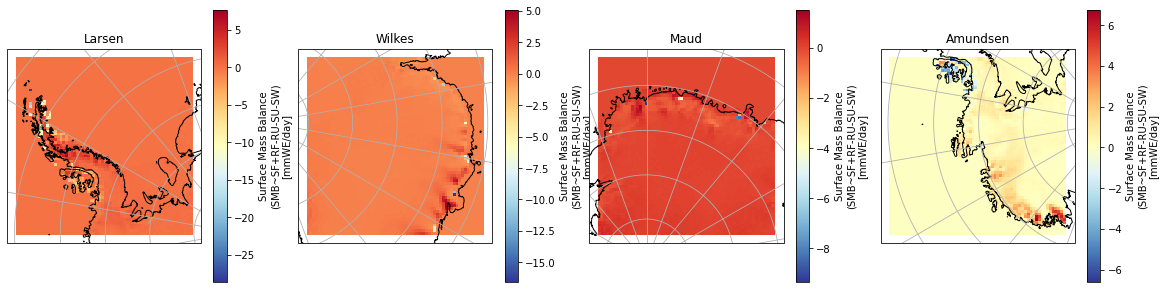

In [ ]:
f = plt.figure(figsize=(20, 5))
i = 1
for r in REGIONS:
    targets, target_times = target_maker(target_dataset, region=r, resize=False)
    full_target_test = np.concatenate(targets, axis=0)[0, :, :, :]
    ax = plt.subplot(1, 4, i, projection=ccrs.SouthPolarStereo())
    vmin = np.min(full_target_test)
    vmax = np.max(full_target_test)
    plotTarget(target_dataset, full_target_test, ax, vmin, vmax, region=r)
    ax.set_title(r)
    i += 1

In [ ]:
%%time
# Load datasets and U-Net
train_loss_e, val_loss_e, train_set, test_set, net = trainFlow(
    full_input,
    full_target,
    region=REGION,
    regions = REGIONS,
    train=True, # train True so that actually trains
    randomSplit = False, # don't take random time samples but take future as test
    **trainingParam
)

INFO: Using device cuda
INFO: Network:
	7 input channels X
	17 input channels Z
	32 size
	64 filter
	Transposed conv upscaling
INFO: Test set size: 580
Train set size: 5228

INFO: Train set size: 1045
Validation set size: 4183



<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


INFO: Starting training:
		Epochs:          300
		Batch size:      32
		Learning rate:   0.005
		Training size:   4183
		Validation size: 1045
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 1/300: 100%|██████████| 4183/4183 [00:27<00:00, 150.21timestep/s, loss (batch)=0.668]
INFO: Checkpoint 1 saved!
Epoch 2/300:  60%|██████    | 2528/4183 [00:16<00:19, 85.42timestep/s, loss (batch)=0.871]

Epoch 00016: reducing learning rate of group 0 to 5.0000e-04.


Epoch 2/300: 100%|██████████| 4183/4183 [00:27<00:00, 152.70timestep/s, loss (batch)=0.556]
INFO: Checkpoint 2 saved!
Epoch 3/300: 100%|██████████| 4183/4183 [00:27<00:00, 153.11timestep/s, loss (batch)=1.22]
INFO: Checkpoint 3 saved!
Epoch 4/300: 100%|██████████| 4183/4183 [00:27<00:00, 152.47timestep/s, loss (batch)=0.799]
INFO: Checkpoint 4 saved!
Epoch 5/300: 100%|██████████| 4183/4183 [00:27<00:00, 153.41timestep/s, loss (batch)=0.8]
INFO: Checkpoint 5 saved!
Epoch 6/300: 100%|██████████| 4183/4183 [00:27<00:00, 151.84timestep/s, loss (batch)=0.819]
INFO: Checkpoint 6 saved!
Epoch 7/300: 100%|██████████| 4183/4183 [00:27<00:00, 153.03timestep/s, loss (batch)=0.877]
INFO: Checkpoint 7 saved!
Epoch 8/300: 100%|██████████| 4183/4183 [00:27<00:00, 153.44timestep/s, loss (batch)=1.07]
INFO: Checkpoint 8 saved!
Epoch 9/300: 100%|██████████| 4183/4183 [00:27<00:00, 152.76timestep/s, loss (batch)=1.33]
INFO: Checkpoint 9 saved!
Epoch 10/300: 100%|██████████| 4183/4183 [00:27<00:00, 153.70

Epoch 00115: reducing learning rate of group 0 to 5.0000e-05.


Epoch 12/300: 100%|██████████| 4183/4183 [00:27<00:00, 151.35timestep/s, loss (batch)=0.457]
INFO: Checkpoint 12 saved!
Epoch 13/300: 100%|██████████| 4183/4183 [00:28<00:00, 148.36timestep/s, loss (batch)=0.527]
INFO: Checkpoint 13 saved!
Epoch 14/300: 100%|██████████| 4183/4183 [00:26<00:00, 155.85timestep/s, loss (batch)=0.868]
INFO: Checkpoint 14 saved!
Epoch 15/300:  40%|███▉      | 1664/4183 [00:10<00:30, 81.90timestep/s, loss (batch)=0.602]

Epoch 00145: reducing learning rate of group 0 to 5.0000e-06.


Epoch 15/300:  90%|█████████ | 3776/4183 [00:24<00:04, 92.90timestep/s, loss (batch)=0.771]

Epoch 00150: reducing learning rate of group 0 to 5.0000e-07.


Epoch 15/300: 100%|██████████| 4183/4183 [00:26<00:00, 155.28timestep/s, loss (batch)=0.907]
INFO: Checkpoint 15 saved!
Epoch 16/300:  39%|███▉      | 1632/4183 [00:10<00:33, 75.74timestep/s, loss (batch)=0.56] 

Epoch 00155: reducing learning rate of group 0 to 5.0000e-08.


Epoch 16/300:  89%|████████▊ | 3712/4183 [00:24<00:06, 73.69timestep/s, loss (batch)=0.694]

Epoch 00160: reducing learning rate of group 0 to 5.0000e-09.


Epoch 16/300: 100%|██████████| 4183/4183 [00:27<00:00, 153.11timestep/s, loss (batch)=0.762]
INFO: Checkpoint 16 saved!
Epoch 17/300: 100%|██████████| 4183/4183 [00:27<00:00, 154.75timestep/s, loss (batch)=0.642]
INFO: Checkpoint 17 saved!
Epoch 18/300: 100%|██████████| 4183/4183 [00:26<00:00, 154.99timestep/s, loss (batch)=0.526]
INFO: Checkpoint 18 saved!
Epoch 19/300: 100%|██████████| 4183/4183 [00:28<00:00, 148.60timestep/s, loss (batch)=0.814]
INFO: Checkpoint 19 saved!
Epoch 20/300: 100%|██████████| 4183/4183 [00:27<00:00, 149.54timestep/s, loss (batch)=0.423]
INFO: Checkpoint 20 saved!
Epoch 21/300: 100%|██████████| 4183/4183 [00:27<00:00, 149.90timestep/s, loss (batch)=0.777]
INFO: Checkpoint 21 saved!
Epoch 22/300: 100%|██████████| 4183/4183 [00:27<00:00, 149.60timestep/s, loss (batch)=0.818]
INFO: Checkpoint 22 saved!
Epoch 23/300: 100%|██████████| 4183/4183 [00:27<00:00, 149.74timestep/s, loss (batch)=0.706]
INFO: Checkpoint 23 saved!
Epoch 24/300: 100%|██████████| 4183/4183

RuntimeError: ignored

In [ ]:
# Load saved model
#today = str(date.today())
# Load datasets and U-Net
train_set, test_set, net = trainFlow(
    full_input,
    full_target,
    region=REGION,
    train=False,
    randomSplit = True,
    **trainingParam
)
loader_args = dict(batch_size=1, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_set, shuffle=False, **loader_args)

#today = '2022-05-05'
#today = date.today()
today = '2022-05-05'
model = f"MODEL_{today}_{REGION}_{NUM_EPOCHS}_{BATCH_SIZE}.pth"
downloadModel = True
if downloadModel:
    #downloadFileFromGC(pathModel, "", model)
    # Download from google drive
    linkModel = 'https://drive.google.com/file/d/1rooLD6OJQX3YmJq-WqRm1ya6j8cLm48a/view?usp=sharing'
    idModel = '1rooLD6OJQX3YmJq-WqRm1ya6j8cLm48a'
    downloaded = drive.CreateFile({'id':idModel}) 
    downloaded.GetContentFile(model)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# make predictions
preds_Comb, x_Comb, z_Comb, true_smb_Comb, r_Comb = predict(net, device, test_loader, model)

f = plt.figure(figsize=(20, 40))

# plot predictions
# plot predictions
plotRandomPredictions(
    preds_Comb,
    x_Comb,
    z_Comb,
    true_smb_Comb,
    r_Comb,
    GCMLike,
    VAR_LIST,
    target_dataset,
    N=10,
    regions=REGIONS)
today = str(date.today())
nameFig = '{}_pred_{}_{}_{}.png'.format(today, REGION,trainingParam['num_epochs'],trainingParam['batch_size'])
plt.savefig(nameFig)
#files.download(nameFig)